In [ ]:
# This is the main code for paper calculation and plotting

# Definitions

In [149]:
import os
import math
import pandas as pd
import numpy as np
import xarray as xr 

from scipy import optimize as opt
from sklearn.metrics import r2_score

import cmocean
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axisartist.parasite_axes import HostAxes, ParasiteAxes

from datetime import datetime


# Mute SettingWithCopyWarning
pd.options.mode.chained_assignment = None 


figpath = './figure/'
datapath = './data/'

## Self-defined Packages

In [3]:
from function.watervapor import * # water related
from function.readdata.maskdf import flag_pre
from function.mymath import linear
from function.slp2sp import slp2sp
from function.conp import * # calculate conditional probability

## Function: categorize, rename_df_columns

In [4]:
def categorize(df):
    '''
    determine sounding type based on number of positive and negative
    areas and freezing level
    
    return: type0, type1, type2, others
    '''
    nPA = (~df.loc[:, 'posi_area1':'posi_area3'].isna()).sum(axis=1)
    nNA = (~df.loc[:, 'nega_area1':'nega_area3'].isna()).sum(axis=1)
    nFL = (~df.loc[:, 'freezing_level1':'freezing_level3'].isna()).sum(axis=1)
    
    type0 = df.loc[
                   ((nPA==0) & (nNA==0) & (nFL==0)) |
                   ((nPA==0) & (nNA==1) & (nFL==0)) |
                   ((nPA==1) & (nNA==0) & (nFL==0)) 
                  ]
    type1 = df.loc[
                   ((nPA==1) & (nNA==0) & (nFL==1)) 
                  ]  
    type2 = df.loc[
                   ((nPA==1) & (nNA==1) & (nFL==1)) 
                  ] 
    others= df.loc[
                   ((nPA==1) & (nNA==2) & (nFL==1)) |
                   ((nPA==2) & (nNA==0) & (nFL==1)) |
                   ((nPA==2) & (nNA==1) & (nFL==1)) |
                   ((nPA==2) & (nNA==1) & (nFL==2)) |
                   ((nPA==2) & (nNA==2) & (nFL==2)) 
                  ]
    # bad data: 1 1 0
    return type0, type1, type2, others


def rename_df_columns(df, tstr):
    '''rename columns of df
    if tstr is 't', then rename those with subscripts _t
    if tstr is 'tw', then remove the subscripts _tw'''
    if tstr=='t':
        columns_mapper={'posi_area1_t':'posi_area1', 
                        'posi_area2_t':'posi_area2', 
                        'posi_area3_t':'posi_area3', 
                        'nega_area1_t':'nega_area1', 
                        'nega_area2_t':'nega_area2', 
                        'nega_area3_t':'nega_area3',
                        'freezing_level1_t':'freezing_level1', 
                        'freezing_level2_t':'freezing_level2', 
                        'freezing_level3_t':'freezing_level3'}
    elif tstr=='tw':
        columns_mapper={'posi_area1_tw':'posi_area1', 
                    'posi_area2_tw':'posi_area2', 
                    'posi_area3_tw':'posi_area3', 
                    'nega_area1_tw':'nega_area1', 
                    'nega_area2_tw':'nega_area2', 
                    'nega_area3_tw':'nega_area3',
                    'freezing_level1_tw':'freezing_level1', 
                    'freezing_level2_tw':'freezing_level2', 
                    'freezing_level3_tw':'freezing_level3'}
    df1 = df.copy()
    df1.rename(columns=columns_mapper, inplace=True)
    return df1

## Funtion for evaluation: print_metrics

In [5]:
def print_metrics(pre_rain, pre_snow):
    TP = sum(pre_snow==2)
    FP = sum(pre_snow==1)
    P = len(pre_snow)
    TN = sum(pre_rain==1)
    FN = sum(pre_rain==2)
    N = len(pre_rain)
    accuracy = (TP+TN)/(P+N)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    f1score = 1/((TP+FN)/TP+(TP+FP)/TP)
    strform = 'True positive: %d | False positive: %d | P_PRE:%d\n' +\
              'False negative: %d | True negative: %d | N_PRE:%d \n' +\
               'P_OBS: %d | N_OBS: %d\n | TOTAL: %d \n\n' +\
              'Accuracy: %5.3f \n' +\
              'Recall: %5.3f \n' +\
              'Precision: %5.3f \n' +\
              'F1Score: %5.3f'
    print(strform %(TP, FP, TP+FP, FN, TN, TN+FN, TP+FN, FP+TN, P+N, 
                    accuracy, recall, precision, f1score))
    return accuracy, recall, precision, f1score

## Functions for Plotting: basemap, colormap

In [6]:
from skimage import measure
# define map properties
leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 85.5)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15
proj = ccrs.PlateCarree(central_longitude=0)
def plot_basemap(ax, img_extent, dlon, dlat):
    ''' 
    basic settings of the basemap. No output. Would work on the axis.
    
    Input:
        ax1: figure axis.
        img_extent: [leftlon, rightlon, lowerlat, upperlat]
        dlon, dlat: intervals of longitude/latitude
    '''
    ax.set_extent(img_extent, crs=proj)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), lw=0.2)
    
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    xticks = np.arange(leftlon, rightlon+dlon, dlon)
    yticks = np.arange(lowerlat, upperlat, dlat)
    ax.set_xticks(xticks, crs=proj)
    ax.set_yticks(yticks, crs=proj)
    ax.set_extent(img_extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), lw=0.2)
    ax.add_feature(cfeature.NaturalEarthFeature(
                   'cultural', 'admin_1_states_provinces_lines', '50m',
                   edgecolor='black', facecolor='none', lw=0.2)
                  )
    # set gridlines
    gl = ax.gridlines(crs=proj, draw_labels=False,
            linewidth=0.3, linestyle=':', color=(0.2,0.2,0.2), alpha=0.8)
    gl.xlocator = mticker.FixedLocator(xticks)
    gl.ylocator = mticker.FixedLocator(yticks)


# Colormap
wbgyr = pd.read_csv('C:\Files\Research\Colormaps\WhiteBlueGreenYellowRed.txt',
                    header=None, delim_whitespace=True)
wbgyr /= 255
wbgyr = wbgyr.values

blue = np.array([14, 126, 191])/255
red = np.array([235, 57, 25])/255
gray = np.array([0.8, 0.8, 0.8])
green = np.array([77,175,74])/255
yellow = np.array([255, 201, 77])/255

## Function LDA

In [7]:
def LDA_boundary_line(x_r, x_s):
    '''
    x_r, x_s: two columns indicate two groups
    Output: slope and intercept of the boundary line
    '''
    mu_r = x_r.mean(axis=0)
    mu_s = x_s.mean(axis=0)

    cov_r = np.cov(x_r, rowvar=False)
    cov_s = np.cov(x_s, rowvar=False)
    W = ((len(x_r)-1)*cov_r + (len(x_s)-1)*cov_s) / (len(x_r)+len(x_s)-2) # pooled within group covariance
    W_1 = np.linalg.inv(W)

    # T = np.cov(np.concatenate([x_r, x_s]), rowvar=False)
    # B = T-W
    # S = np.dot(W_1, B)

    # the boundary line is perpendicular to this line, crossing the midpoint of the centroids
    line = np.dot(W_1, (mu_s - mu_r))     
    midpoint = (mu_r+mu_s)/2
    
    slope = -line[0]/line[1]
    intercept = midpoint[1]-slope*midpoint[0]
    return slope, intercept

# Import data

## station information

In [281]:
final = pd.read_csv(datapath + 'final_all_cleaned_data.txt')

In [282]:
final

datetime    lat     lon   elev     t    td          p  \
0       1978-01-02 00:00:00  53.97  258.90  271.0 -11.0 -12.0   982.4000   
1       1978-01-02 12:00:00  53.97  258.90  271.0 -10.0 -12.0   983.1000   
2       1978-01-03 00:00:00  53.97  258.90  271.0 -11.0 -12.0   979.7000   
3       1978-01-03 12:00:00  53.97  258.90  271.0 -15.0 -17.0   981.8000   
4       1978-01-06 12:00:00  53.97  258.90  271.0 -27.0 -31.0   992.8000   
...                     ...    ...     ...    ...   ...   ...        ...   
284673  2007-02-06 00:00:00  27.77  277.37    2.0  12.8   3.3  1027.3546   
284674  2007-02-12 12:00:00  27.77  277.37    2.0  17.0  13.0        NaN   
284675  2007-02-18 12:00:00  27.77  277.37    2.0  11.7   8.3  1015.5565   
284676  2007-02-26 12:00:00  27.77  277.37    2.0  20.6  18.9  1014.4641   
284677  2011-07-09 00:00:00  27.77  277.37    2.0  25.0  24.0        NaN   

           slp    ww     tw  ...  lowest_z_tw  IGRA_lon  IGRA_lat  \
0       1017.0  71.0 -11.25  ...        270.0  258.9000   53.9667   
1       1017.7  71.0 -10.50  ...        270.0  258.9000   53.9667   
2       1014.1  76.0 -11.25  ...        270.0  258.9000   53.9667   
3       1016.4  71.0 -15.38  ...        270.0  258.9000   53.9667   
4       1029.4  71.0 -27.31  ...        270.0  258.9000   53.9667   
...        ...   ...    ...  ...          ...       ...       ...   
284673  1027.6  61.0   8.04  ...         13.0  277.5994   27.7053   
284674     NaN  61.0    NaN  ...         13.0  277.5994   27.7053   
284675  1015.8  61.0   9.81  ...         13.0  277.5994   27.7053   
284676  1014.7  61.0  19.42  ...         13.0  277.5994   27.7053   
284677     NaN  61.0  24.00  ...         13.0  277.5994   27.7053   

            IGRA_ID  NCEP_ID     ID       PA_t  NA_t      PA_tw   NA_tw  
0       CAM00071867    71867  71867     0.0000  -0.0     0.0000 -0.0000  
1       CAM00071867    71867  71867     0.0000  -0.0     0.0000 -0.0000  
2       CAM00071867    71867  71867     0.0000  -0.0     0.0000 -0.0000  
3       CAM00071867    71867  71867     0.0000  -0.0     0.0000 -0.0000  
4       CAM00071867    71867  71867     0.0000  -0.0     0.0000 -0.0000  
...             ...      ...    ...        ...   ...        ...     ...  
284673  USM00072210     KSPG   KSPG   774.7055  -0.0   129.5878  5.3960  
284674  USM00072210     KSPG   KSPG     0.0000  -0.0   752.7093 -0.0000  
284675  USM00072210     KSPG   KSPG   273.9407  -0.0   153.7993  4.0901  
284676  USM00072210     KSPG   KSPG  1545.3079  -0.0  1047.9524  2.3904  
284677  USM00072210     KSPG   KSPG     0.0000  -0.0     0.0000 -0.0000  

[284678 rows x 46 columns]

In [150]:
stations = pd.read_csv('../02-Output/NCEP_IGRA_collocated_stations_cleaned.txt')
stations.set_index('NCEP_ID', inplace=True)

# Figure 1: Bias in snow probability using only temperature

need to use this figure to show that using temperature or Tw alone would lead to relatively large bias in estimating precipitation phase. That's why we developed the lapse rate one -- but the lapse rate would fail in Type 2 soundings. ---This is the motivation of this paper. we further consider the energy area method.

In [68]:
bias = pd.read_csv('../02-Output/NA/snow_fraction_bias_temp_and_probsnow.txt', index_col=0)

abs(bias).mean(axis=0)

t              0.043868
tw             0.028918
probsnow_t     0.026528
probsnow_tw    0.016172
dtype: float64

## Plotting

In [24]:
# lat and lon of the stations
bias_loc = stations.loc[bias.index]
bias_loc = bias_loc[~bias_loc.index.duplicated()]


In [28]:
rgb = np.array([
    [7, 47, 107],
    [8, 82, 156],
[  33, 113, 181],
[  66, 146, 199],
[  90, 160, 205],
[ 120, 191, 214],
[ 170, 220, 230],
[ 219, 245, 255],

[ 255, 224, 224],
[ 252, 187, 170],
[ 252, 146, 114],
[ 251, 106,  74],
[ 240,  60,  43],
[ 204,  24,  30],
[166, 15, 20],
[120, 10, 15]])/255

# rgb = pd.read_csv('diff_14colors.txt', delim_whitespace=True, header=None).values/255
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       'mymap', rgb[1:-1], len(rgb)-2)
cmap.set_under(rgb[0])
cmap.set_over(rgb[-1])

bounds = [-6, -5,-4, -3, -2, -1, -0.1, 0, 0.1, 1, 2, 3, 4, 5, 6] # in %
# bounds = [-0.06, -0.05,-0.04, -0.03, -0.02, -0.01, -0.001, 0, 0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]
boundlabels=bounds
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=len(rgb)-2)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_iches" which is no longer supported as of 3.3 and will become an error in 3.6
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


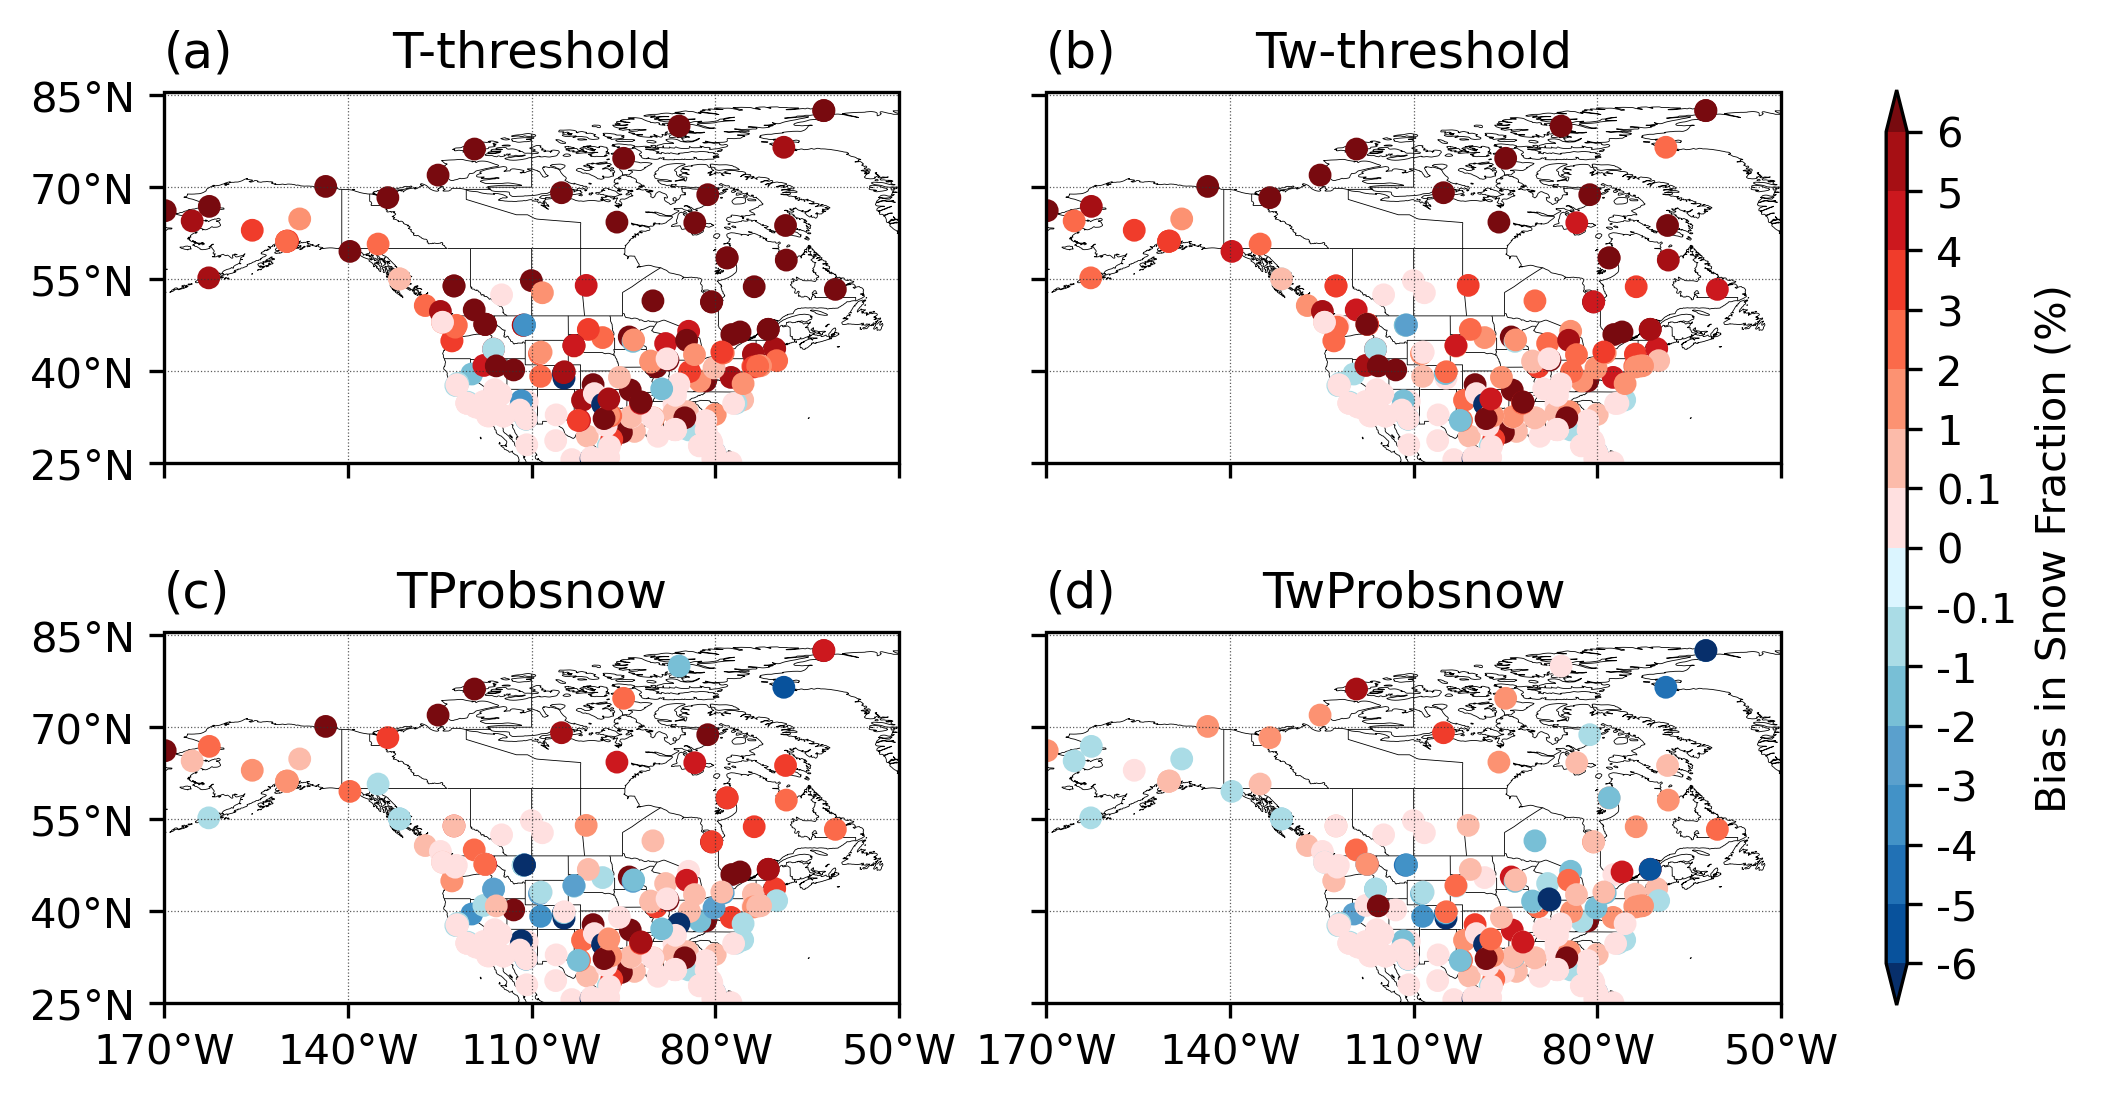

In [32]:
fig = plt.figure(figsize=(7, 5), dpi=300)  
ax1 = fig.add_axes([0.10, 0.48, 0.35, 0.33], projection=proj)
ax2 = fig.add_axes([0.52, 0.48, 0.35, 0.33], projection=proj)
ax3 = fig.add_axes([0.10, 0.12, 0.35, 0.33], projection=proj)
ax4 = fig.add_axes([0.52, 0.12, 0.35, 0.33], projection=proj)

position1 = fig.add_axes([0.92, 0.16, 0.01, 0.610])
# position2 = fig.add_axes([0.76, 0.10, 0.01, 0.33])

leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 85.5)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15

plot_basemap(ax1, img_extent, dlon, dlat)
ax1.set_xticklabels([])
sct1= ax1.scatter(bias_loc['LON'], bias_loc['LAT'],
                  c=bias['t']*100,s=20,
                  cmap=cmap,
                 norm=norms)
ax1.set_title('T-threshold', fontsize=12)
ax1.set_title('(a)', loc='left', fontsize=12)
cb = plt.colorbar(sct1, cax=position1 ,orientation='vertical', fraction=.1, extend='both')
cb.ax.tick_params(labelsize=10)
cb.set_ticks(bounds)
cb.set_ticklabels(boundlabels)
cb.set_label('Bias in Snow Fraction (%)')

plot_basemap(ax2, img_extent, dlon, dlat)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
sct2= ax2.scatter(bias_loc['LON'], bias_loc['LAT'],
                  c=bias['tw']*100,s=20,
                  cmap=cmap,
                  norm=norms)
ax2.set_title('Tw-threshold', fontsize=12)
ax2.set_title('(b)', loc='left', fontsize=12)

plot_basemap(ax3, img_extent, dlon, dlat)
sct3= ax3.scatter(bias_loc['LON'], bias_loc['LAT'],
                  c=bias['probsnow_t']*100, s=20,
                  cmap=cmap,
                  norm=norms)
ax3.set_title('TProbsnow', fontsize=12)
ax3.set_title('(c)', loc='left', fontsize=12)

plot_basemap(ax4, img_extent, dlon, dlat)
ax4.set_yticklabels([])
sct4= ax4.scatter(bias_loc['LON'], bias_loc['LAT'],
                  c=bias['probsnow_tw']*100,s=20,
                  cmap=cmap,
                 norm=norms)
ax4.set_title('TwProbsnow', fontsize=12)
ax4.set_title('(d)', loc='left', fontsize=12)

fig.savefig(figpath+'Figure1', dpi=300, bbox_inches='tight')
fig.savefig(figpath+'Figure1.eps', format='eps', dpi=300, bbox_iches='tight')

# Figure 2: Sounding Type

In [359]:
path = '../02-Output/sounding/'
df_t = pd.read_csv(path +'CAM00071625_71625_temp_sounding.txt')
df_h = pd.read_csv(path +'CAM00071625_71625_gph_sounding.txt')
df_t.set_index(pd.to_datetime(df_t.loc[:, 'year':'hour']), inplace=True)
df_h.set_index(pd.to_datetime(df_h.loc[:, 'year':'hour']), inplace=True)

df_t2 = pd.read_csv(path +'USM00072203_72203_temp_sounding.txt')
df_t2.set_index(pd.to_datetime(df_t2.loc[:, 'year':'hour']), inplace=True)

df_t3 = pd.read_csv(path +'USM00072208_72208_temp_sounding.txt')
df_t3.set_index(pd.to_datetime(df_t3.loc[:, 'year':'hour']), inplace=True)

df_t3 = pd.read_csv(path +'USM00070231_70231_temp_sounding.txt')
df_t3.set_index(pd.to_datetime(df_t3.loc[:, 'year':'hour']), inplace=True)
df_rh3 = pd.read_csv(path +'USM00070231_70231_rh_sounding.txt')
df_rh3.set_index(pd.to_datetime(df_rh3.loc[:, 'year':'hour']), inplace=True)

# TYPE 0A ALL COLD 71625
time = '2005-11-17 15:00:00'
time = '2005-11-15 14:00:00'
time = '1987-03-04 12:00:00'
p01 = df_t.loc[time, '0':'10'].map(lambda x:x.split(',')[0]).astype(float)
t01 = df_t.loc[time, '0':'10'].map(lambda x:x.split(',')[1]).astype(float)
h01 = df_h.loc[time, '0':'10'].map(lambda x:x.split(',')[1]).astype(float)
t01 = t01[~t01.isna() & ~p01.isna()]
p01 = p01[~t01.isna() & ~p01.isna()]

#TYPE0B 72203 all warm
time = '1978-11-08 00:00:00'
p02 = df_t2.loc[time, '0':'10'].map(lambda x:x.split(',')[0]).astype(float)
t02 = df_t2.loc[time, '0':'10'].map(lambda x:x.split(',')[1]).astype(float)
t02 = t02[~t02.isna() & ~p02.isna()]
p02 = p02[~t02.isna() & ~p02.isna()]

# TYPE1  WARM LAYER 71625 1988 10 11 12
time = '1988-10-11 12:00:00'
p1 = df_t.loc[time, '0':'10'].map(lambda x:x.split(',')[0]).astype(float)
t1 = df_t.loc[time, '0':'10'].map(lambda x:x.split(',')[1]).astype(float)
h1 = df_h.loc[time, '0':'10'].map(lambda x:x.split(',')[1]).astype(float)
t1 = t1[~t1.isna() & ~p1.isna()]
p1 = p1[~t1.isna() & ~p1.isna()]

#TYPE 2 MELT AND REFREEZING
time = '1978-02-09 12:00:00'
time = '1986-11-02 12:00:00'
# time = '1986-11-03 12:00:00'
p2 = df_t3.loc[time, '0':'10'].map(lambda x:x.split(',')[0]).astype(float)
t2 = df_t3.loc[time, '0':'10'].map(lambda x:x.split(',')[1]).astype(float)
t2 = t2[~t2.isna() & ~p2.isna()]
p2 = p2[~t2.isna() & ~p2.isna()]
rh2 = df_rh3.loc[time, '0':'10'].map(lambda x:x.split(',')[1]).astype(float)
rh2 = rh2.loc[t2.index]
tw2 = t2.copy()
for i in range(len(t2)):
    tw2[i] =rh2tw(p2[i], t2[i], rh2[i])
tw2[5] = 2.9

sounding0A = pd.DataFrame(columns=['p', 't'])
sounding0B = pd.DataFrame(columns=['p', 't'])
sounding1 = pd.DataFrame(columns=['p', 't'])
sounding2 = pd.DataFrame(columns=['p', 't'])

sounding0A['p'] = p01
sounding0A['t'] = t01
sounding0B['p'] = p02
sounding0B['t'] = t02
sounding1['p'] = p1
sounding1['t'] = t1
sounding2['p'] = p2
sounding2['t'] = t2

In [500]:
sounding0A.to_csv('sounding0A.txt', index=False)
sounding0B.to_csv('sounding0B.txt', index=False)
sounding1.to_csv('sounding1.txt', index=False)
sounding2.to_csv('sounding2.txt', index=False)

In [448]:
def linear(t1, p1, t2, p2):
    slope = (p2 - p1)/(t2 - t1)
    intercept = p1 - slope*t1
    return slope, intercept

def sounding_linear_functions(xs, ys):
    nlines = len(xs)-1
    slope, intercept = np.zeros(nlines), np.zeros(nlines)

    for i in range(nlines):
        x1, y1 = xs[i], ys[i]
        x2, y2 = xs[i+1], ys[i+1]
        slope[i], intercept[i] = linear(x1, y1, x2, y2)        
        
    return slope, intercept


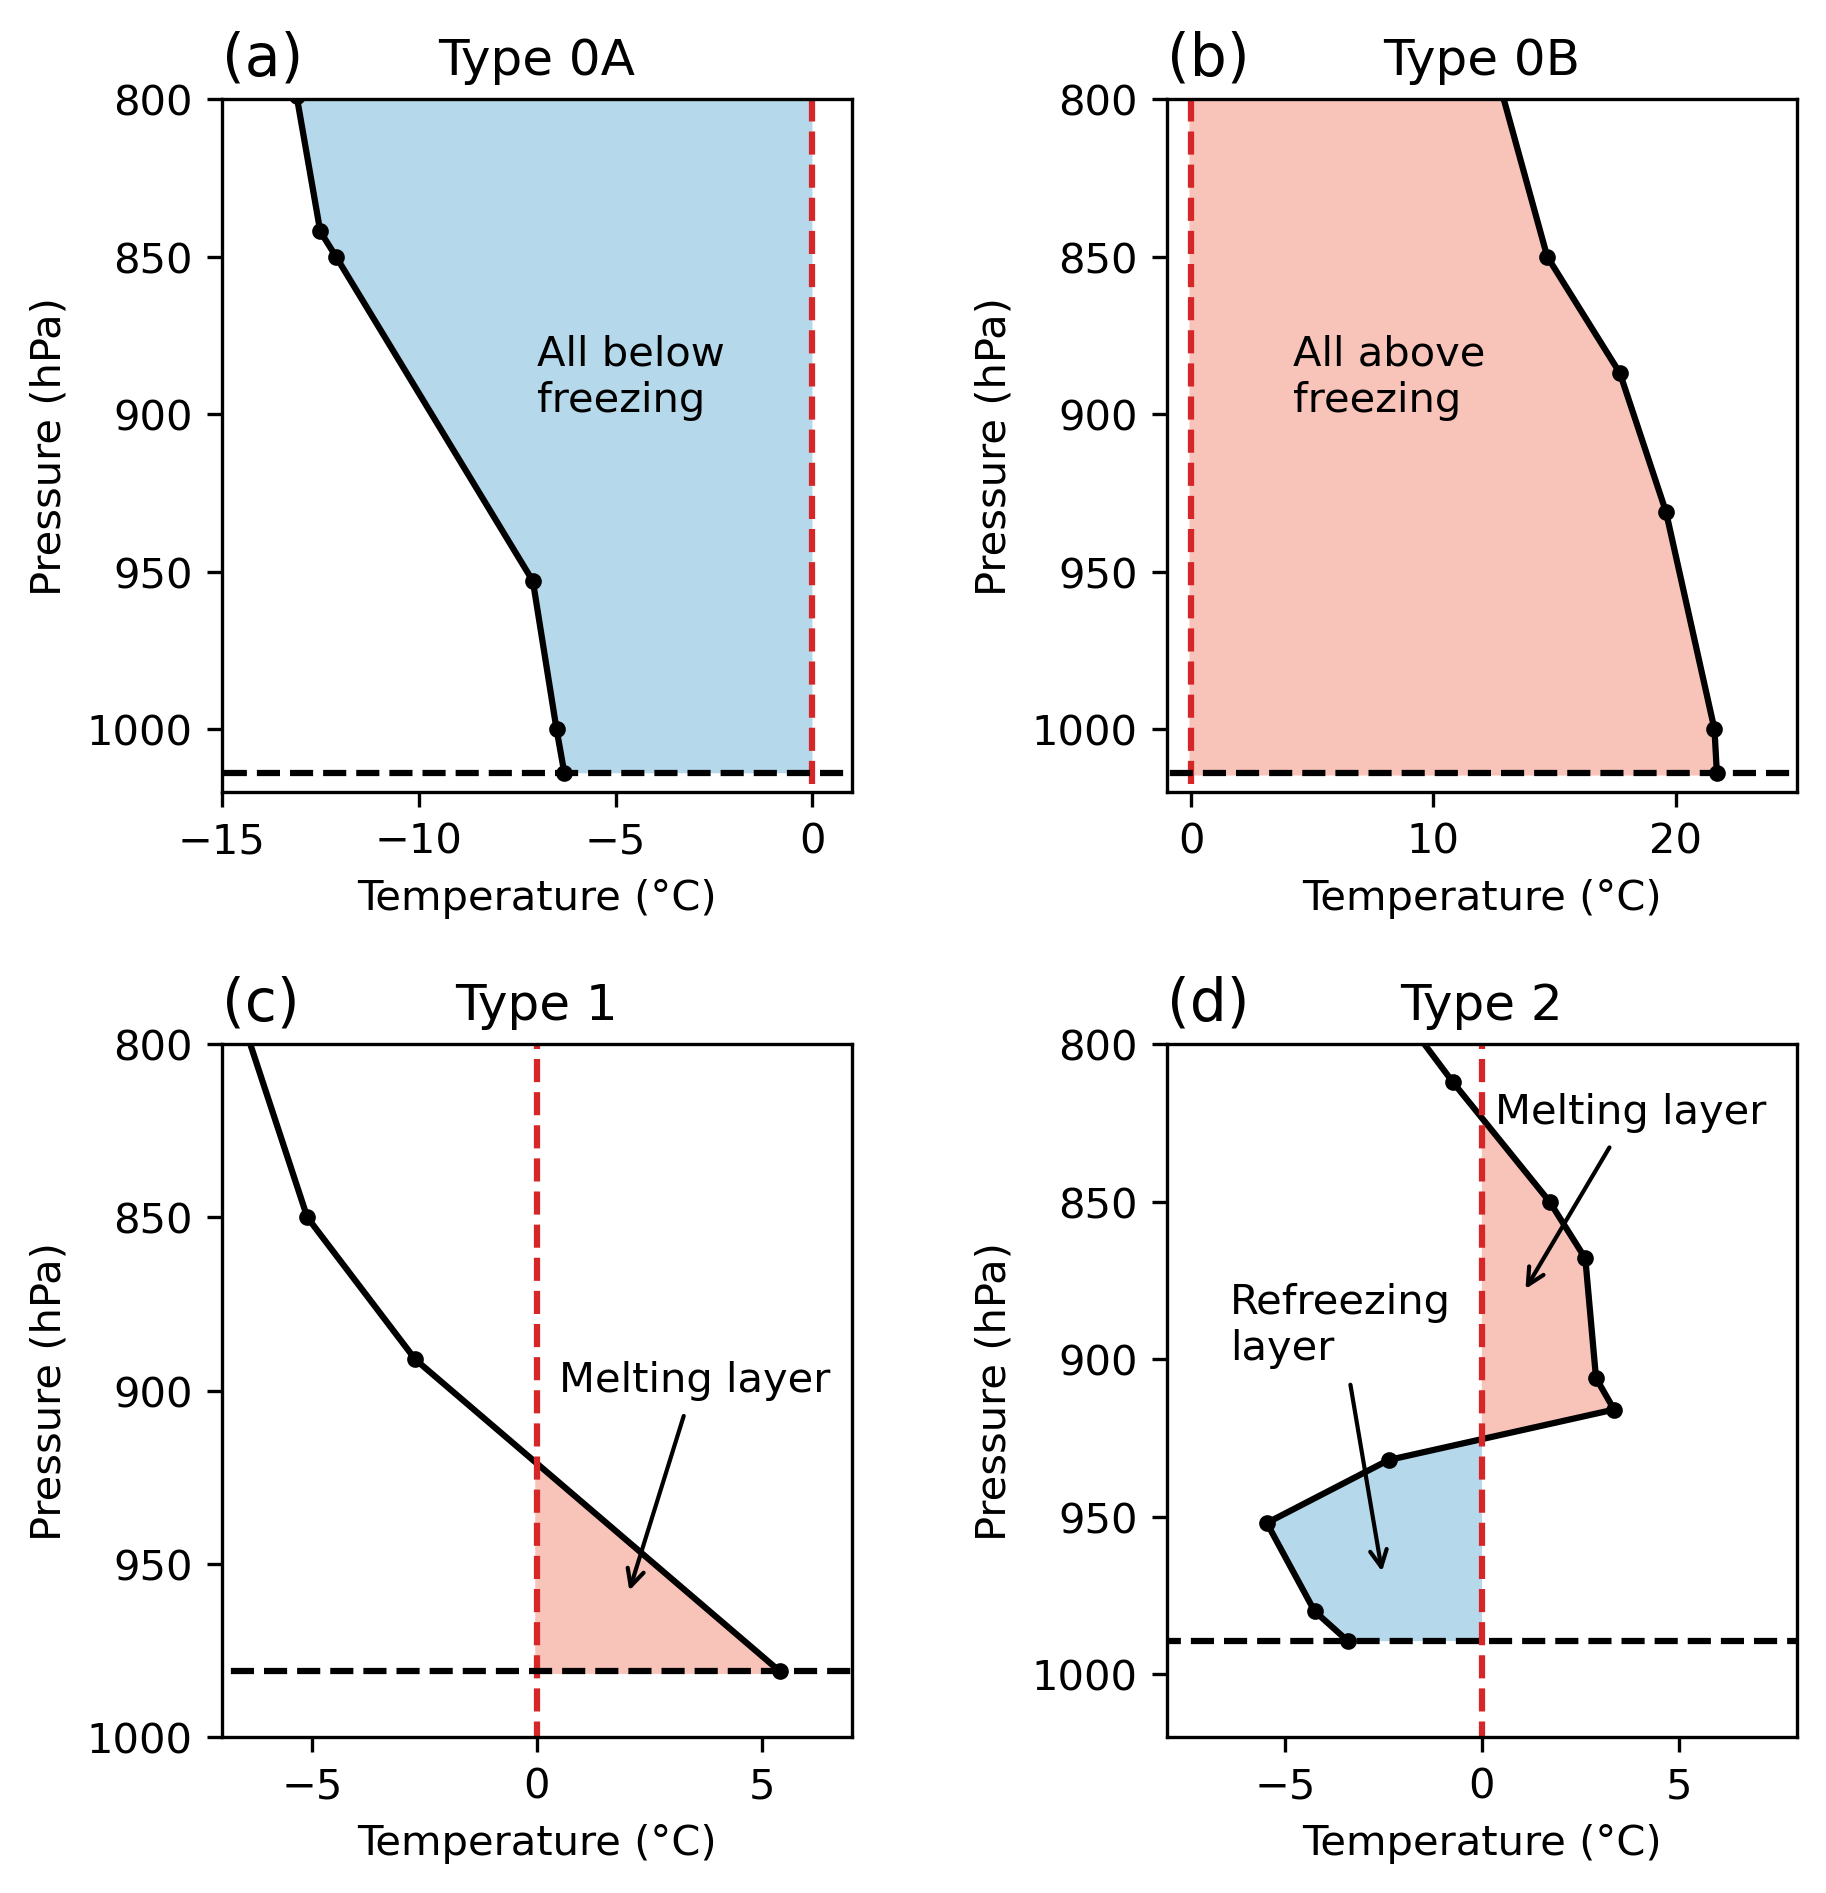

In [493]:
lightblue = np.array([182, 216, 235])/255
lightred = np.array([248, 195, 185])/255
fig = plt.figure(figsize=(7, 7), dpi=300) 
position1 = [0.10, 0.55, 0.3, 0.33]
position2 = [0.55, 0.55, 0.3, 0.33]
position3 = [0.10, 0.1, 0.3, 0.33]
position4 = [0.55, 0.1, 0.3, 0.33]

ax1 = fig.add_axes(position1)
ax2 = fig.add_axes(position2)
ax3 = fig.add_axes(position3)
ax4 = fig.add_axes(position4)
# ax12 = ax11.twinx()
# ax22 = ax21.twinx()
# ax32 = ax31.twinx()
# ax42 = ax41.twinx()

ax1.plot(t01, p01, 'k.-')
ax1.plot([0, 0], [-2000, 2000], '--', color='tab:red')
ax1.plot([-20, 26], [max(p01), max(p01)], 'k--')
ax1.set_xlabel('Temperature ('+chr(176)+'C)')
ax1.set_ylabel('Pressure (hPa)')
# ax1.grid()
ax1.set_xlim([-15, 1])
ax1.set_ylim([1020, 800])
ax1.set_yticks(np.arange(1000, 750, -50))
ax1.set_title('Type 0A')

ax2.plot(t02, p02, 'k.-')
ax2.plot([0, 0], [-2000, 2000], '--', color='tab:red')
ax2.plot([-20, 30], [max(p02), max(p02)], 'k--')
ax2.set_xlabel('Temperature ('+chr(176)+'C)')
ax2.set_ylabel('Pressure (hPa)')
ax2.set_xlim([-1, 25])
ax2.set_ylim([1020, 800])
ax2.set_yticks(np.arange(1000, 750, -50))
ax2.set_title('Type 0B')

ax3.plot(t1, p1, 'k.-')
ax3.plot([0, 0], [0, 2000], '--', color='tab:red')
ax3.plot([-20, 20], [max(p1), max(p1)], 'k--')
ax3.set_xlabel('Temperature ('+chr(176)+'C)')
ax3.set_ylabel('Pressure (hPa)')
ax3.set_xlim([-7, 7])
ax3.set_ylim([1000, 800])
ax3.set_yticks(np.arange(1000, 750, -50))
ax3.set_title('Type 1')

ax4.plot(tw2, p2, 'k.-')
ax4.plot([0, 0], [0, 2000], '--', color='tab:red')
ax4.plot([-20, 20], [max(p2), max(p2)], 'k--')
ax4.set_xlabel('Temperature ('+chr(176)+'C)')
ax4.set_ylabel('Pressure (hPa)')
ax4.set_xlim([-8, 8])
ax4.set_ylim([1020, 800])
ax4.set_yticks(np.arange(1000, 750, -50))
ax4.set_title('Type 2')

ax1.set_title('(a)', loc='left', fontsize=14)
ax2.set_title('(b)', loc='left', fontsize=14)
ax3.set_title('(c)', loc='left', fontsize=14)
ax4.set_title('(d)', loc='left', fontsize=14)


# fill the patches with blue or red to indicate freezing or melting layer
def slope(tt1, tt2, pp1, pp2):
    return (pp2-pp1)/(tt2-tt1)
def intercept(tt1, tt2, pp1, pp2):
    return pp1 - tt1* (pp2-pp1)/(tt2-tt1)

t800 = (800-intercept(t01[4], t01[5], p01[4], p01[5]) )/slope(t01[4], t01[5], p01[4], p01[5])
x = [t800] + np.flipud(t01[0:5]).tolist() +[0]
lower_bound = [800] + np.flipud(p01[0:5]).tolist() + [p01[0]]
upper_bound = [800]*7
ax1.fill_between(x, lower_bound, upper_bound, 
                 color=lightblue, edgecolor='none', interpolate=True)

t800 = (800-intercept(t02[4], t02[5], p02[4], p02[5]) )/slope(t02[4], t02[5], p02[4], p02[5])
xx1 = [0] + [t800] + np.flipud(t02[0:5]).tolist() 
yy1 = [800, 800] + np.flipud(p02[0:5]).tolist()
yy2 = [p02[0]]*7
ax2.fill_between(xx1, yy1, yy2,
                 color=lightred, interpolate=True)

surface=[p1[0], p1[0]]
warm = [ intercept(t1[0], t1[1], p1[0], p1[1]) , p1[0]]
ax3.fill_between([0, t1[0]], surface, warm, 
                 color=lightred, interpolate=True)

x1 = np.arange(tw2[2], tw2[1], 0.01)
x0 = np.arange(tw2[1], tw2[0], 0.01)
x00 = np.arange(tw2[0], 0.01, 0.01)

x2 = np.arange(tw2[2], tw2[3], 0.01)
x3 = np.arange(tw2[3], 0.01, 0.01)

x = np.concatenate([x2, x3])

slope, intercept = sounding_linear_functions(tw2[0:5], p2[0:5])
lower_bound = np.concatenate((
                    x1*slope[1] + intercept[1],
                    x0*slope[0] + intercept[0],    
                        ))
upper_bound = np.concatenate((
                    x2*slope[2]+intercept[2],
                    x3*slope[3]+intercept[3]
                            ))
lower_bound = np.concatenate((lower_bound, 
                              np.array([p2[0]]*(len(upper_bound)-len(lower_bound)))
                             ))
ax4.fill_between(x, lower_bound, upper_bound, 
                 color=lightblue, edgecolor='none', interpolate=True)



x1 = np.arange(0,      tw2[7], 0.01)
x2 = np.arange(tw2[7], tw2[6], 0.01)
x3 = np.arange(tw2[6], tw2[5], 0.01)
x4 = np.arange(tw2[5], tw2[4]+0.01, 0.01)
x = np.concatenate([x1, x2, x3, x4])

slope, intercept = sounding_linear_functions(tw2[3:9], p2[3:9])
lower_bound = slope[0]*x + intercept[0]
upper_bound = np.concatenate((
                    x1*slope[-1]+intercept[-1],
                    x2*slope[-2]+intercept[-2],
                    x3*slope[-3]+intercept[-3],
                    x4*slope[-4]+intercept[-4]))
ax4.fill_between(x, upper_bound, lower_bound, 
                  color=lightred, edgecolor='none', interpolate=True)

ax1.text(0.5, 0.55, 'All below\nfreezing', transform=ax1.transAxes)
ax2.text(0.2, 0.55, 'All above\nfreezing', transform=ax2.transAxes)
ax3.annotate("Melting layer", xy=(2, 960), xytext=(0.5, 900),
             arrowprops=dict(arrowstyle="->"))
ax4.annotate("Melting layer", xy=(1, 880), xytext=(0.33, 825),
             arrowprops=dict(arrowstyle="->"))
ax4.annotate("Refreezing\nlayer", xy=(-2.5, 970), xytext=(-6.4, 900),
             arrowprops=dict(arrowstyle="->"))

plt.savefig(figpath+'Figure2', bbox_inches='tight',dpi=300)
plt.savefig(figpath+'Figure2.eps', format='eps', bbox_inches='tight',dpi=300)

#轴名称，刻度值的颜色
#ax_host.axis['left'].label.set_color(ax_host.get_color())
# ax_pres.axis['right'].label.set_color('tab:red')
# ax_h.axis['right2'].label.set_color('tab:blue')
# ax_pres.axis['right'].major_ticks.set_color('tab:red')
# ax_h.axis['right2'].major_ticks.set_color('tab:blue')
# ax_pres.axis['right'].major_ticklabels.set_color('tab:red')
# ax_h.axis['right2'].major_ticklabels.set_color('tab:blue')
# ax_pres.axis['right'].line.set_color('tab:red')
# ax_h.axis['right2'].line.set_color('tab:blue')

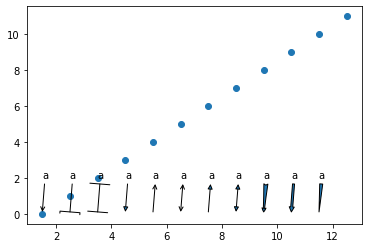

In [ ]:
styles = ['->',
'-[',
'|-|',
'-|>',
'<-',
'<->',
'<|-',
'<|-|>',
'fancy',
'simple',
'wedge']
xxss = np.arange(1.5, 12.6, 1)

fig, ax = plt.subplots()
ax.scatter(xxss, np.arange(12))
for i in range(11):
    ax.annotate("a", xy=(xxss[i], 0), xytext=(xxss[i], 2),
            arrowprops=dict(arrowstyle=styles[i]))

# Figure 3: Sounding percentage for snow events
need to show that type 2 sounding is also important in snow events, besides all cold soundings, and with surface temperature between -10 and 10C

the size of the pie chart correspond to the number of data 

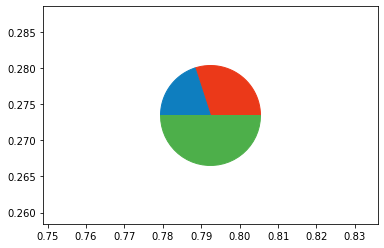

In [146]:
def drawPieMarker(ax, xs, ys, ratios, sizes, colors):
    '''
    draw a pie marker at a given location
    https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
    
    xs, ys: arrays of xs and ys
    
    '''
    # assert sum(ratios) <= 1, 'sum of ratios needs to be <= 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous # angle
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0] # polygon
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        
        #for wedges that never reach the min or max x or y, you need a rescaling
        sizes_scaled = np.abs(xy).max()**2*np.array(sizes)  
        
        markers.append({'marker':xy, 's':sizes_scaled, 'facecolor':color}) 

    # scatter each of the pie pieces to create pies
    for marker in markers:
        sct = ax.scatter(xs, ys, **marker)
    return sct

# green = np.array([102,194,165])/255
fig, ax = plt.subplots()
drawPieMarker(ax,xs=np.random.rand(1),
              ys=np.random.rand(1),
              ratios=[.3, .2, .5],
              sizes=[ 10000],
              colors=[red, blue, green])
plt.show()

In [15]:
# type0_t, type1_t, type2_t, others_t = categorize(df_t)
# type0_tw, type1_tw, type2_tw, others_tw = categorize(df_tw)


In [18]:
final_data = pd.read_csv(datapath+'final_all_cleaned_data.txt', index_col=0)
df_t = rename_df_columns(final_data, 't')
df_tw = rename_df_columns(final_data, 'tw')

df_t10 = df_t[(df_t.t>=-10) & (df_t.t<=10)]
df_tw10 = df_tw[(df_tw.tw>=-10) & (df_tw.tw<=10)]
df_t10_snow = df_t10[df_t10.wwflag==2]
df_tw10_snow = df_tw10[df_tw10.wwflag==2]

In [21]:
def count_num_sounding(df_t10):
    '''
    Output: 
        num_sounding_t10, with columns 'total', 'type0', 'type1', 'type2' and 'othhers'
            and the station ID as indexes
            total: number of precipitation events
            type0: record the number of soundings excluding all warm or all cold ones.
            type1 is one warm layer (cat2)
            type2 is melting layer + refreezing layer
        
    '''
    type0_t10, type1_t10, type2_t10, others_t10 = categorize(df_t10)
    
    ID_t10 = df_t10.ID.unique()
    num_sounding_t10 = pd.DataFrame(data=0, index=ID_t10, columns=['total', 'type0', 'type1', 'type2', 'others'])
    for ID in ID_t10:
        num_sounding_t10.loc[ID, 'total'] = len(df_t10[df_t10.ID==ID]) # -len(cat0_t10[cat0_t10.ID==ID])-len(cat1_t10[cat1_t10.ID==ID])
        num_sounding_t10.loc[ID, 'type0'] = len(type0_t10[type0_t10.ID==ID])
        num_sounding_t10.loc[ID, 'type1'] = len(type1_t10[type1_t10.ID==ID])
        num_sounding_t10.loc[ID, 'type2'] = len(type2_t10[type2_t10.ID==ID])
        num_sounding_t10.loc[ID, 'others'] = len(others_t10[others_t10.ID==ID])
    return num_sounding_t10

num_sounding_t10 = count_num_sounding(df_t10)
num_sounding_t10_snow = count_num_sounding(df_t10_snow)

num_sounding_tw10 = count_num_sounding(df_tw10)
num_sounding_tw10_snow = count_num_sounding(df_tw10_snow)

def cal_sounding_percentage(num_sounding_t10):
    # percentage in all soundings
    ratio_pre_t10 = pd.DataFrame(index=num_sounding_t10.index, columns=['type0', 'type1', 'type2', 'others'])
    ratio_pre_t10['type0'] = num_sounding_t10['type0']/num_sounding_t10['total']
    ratio_pre_t10['type1'] = num_sounding_t10['type1']/num_sounding_t10['total']
    ratio_pre_t10['type2'] = num_sounding_t10['type2']/num_sounding_t10['total']
    ratio_pre_t10['others'] = num_sounding_t10['others']/num_sounding_t10['total']
    return ratio_pre_t10

def cal_sounding_percentage_excluding_type0(num_sounding_t10):
    ratio_pre_t10 = pd.DataFrame(index=num_sounding_t10.index, columns=['type0', 'type1', 'type2', 'others'])
    ratio_pre_t10['type0'] = np.nan
    total = num_sounding_t10['type1'] + num_sounding_t10['type2'] + num_sounding_t10['others']
    ratio_pre_t10['type1'] = num_sounding_t10['type1']/total
    ratio_pre_t10['type2'] = num_sounding_t10['type2']/total
    ratio_pre_t10['others'] = num_sounding_t10['others']/total
    return ratio_pre_t10

ratio_t10 = cal_sounding_percentage(num_sounding_t10)
ratio_tw10 = cal_sounding_percentage(num_sounding_tw10)
ratio_t10_snow = cal_sounding_percentage(num_sounding_t10_snow)
ratio_tw10_snow = cal_sounding_percentage(num_sounding_tw10_snow)

ratio_excluded_t10 = cal_sounding_percentage_excluding_type0(num_sounding_t10)
ratio_excluded_tw10 = cal_sounding_percentage_excluding_type0(num_sounding_tw10)
ratio_excluded_t10_snow = cal_sounding_percentage_excluding_type0(num_sounding_t10_snow)
ratio_excluded_tw10_snow = cal_sounding_percentage_excluding_type0(num_sounding_tw10_snow)


## Figure 3: excluding type0, Tw

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


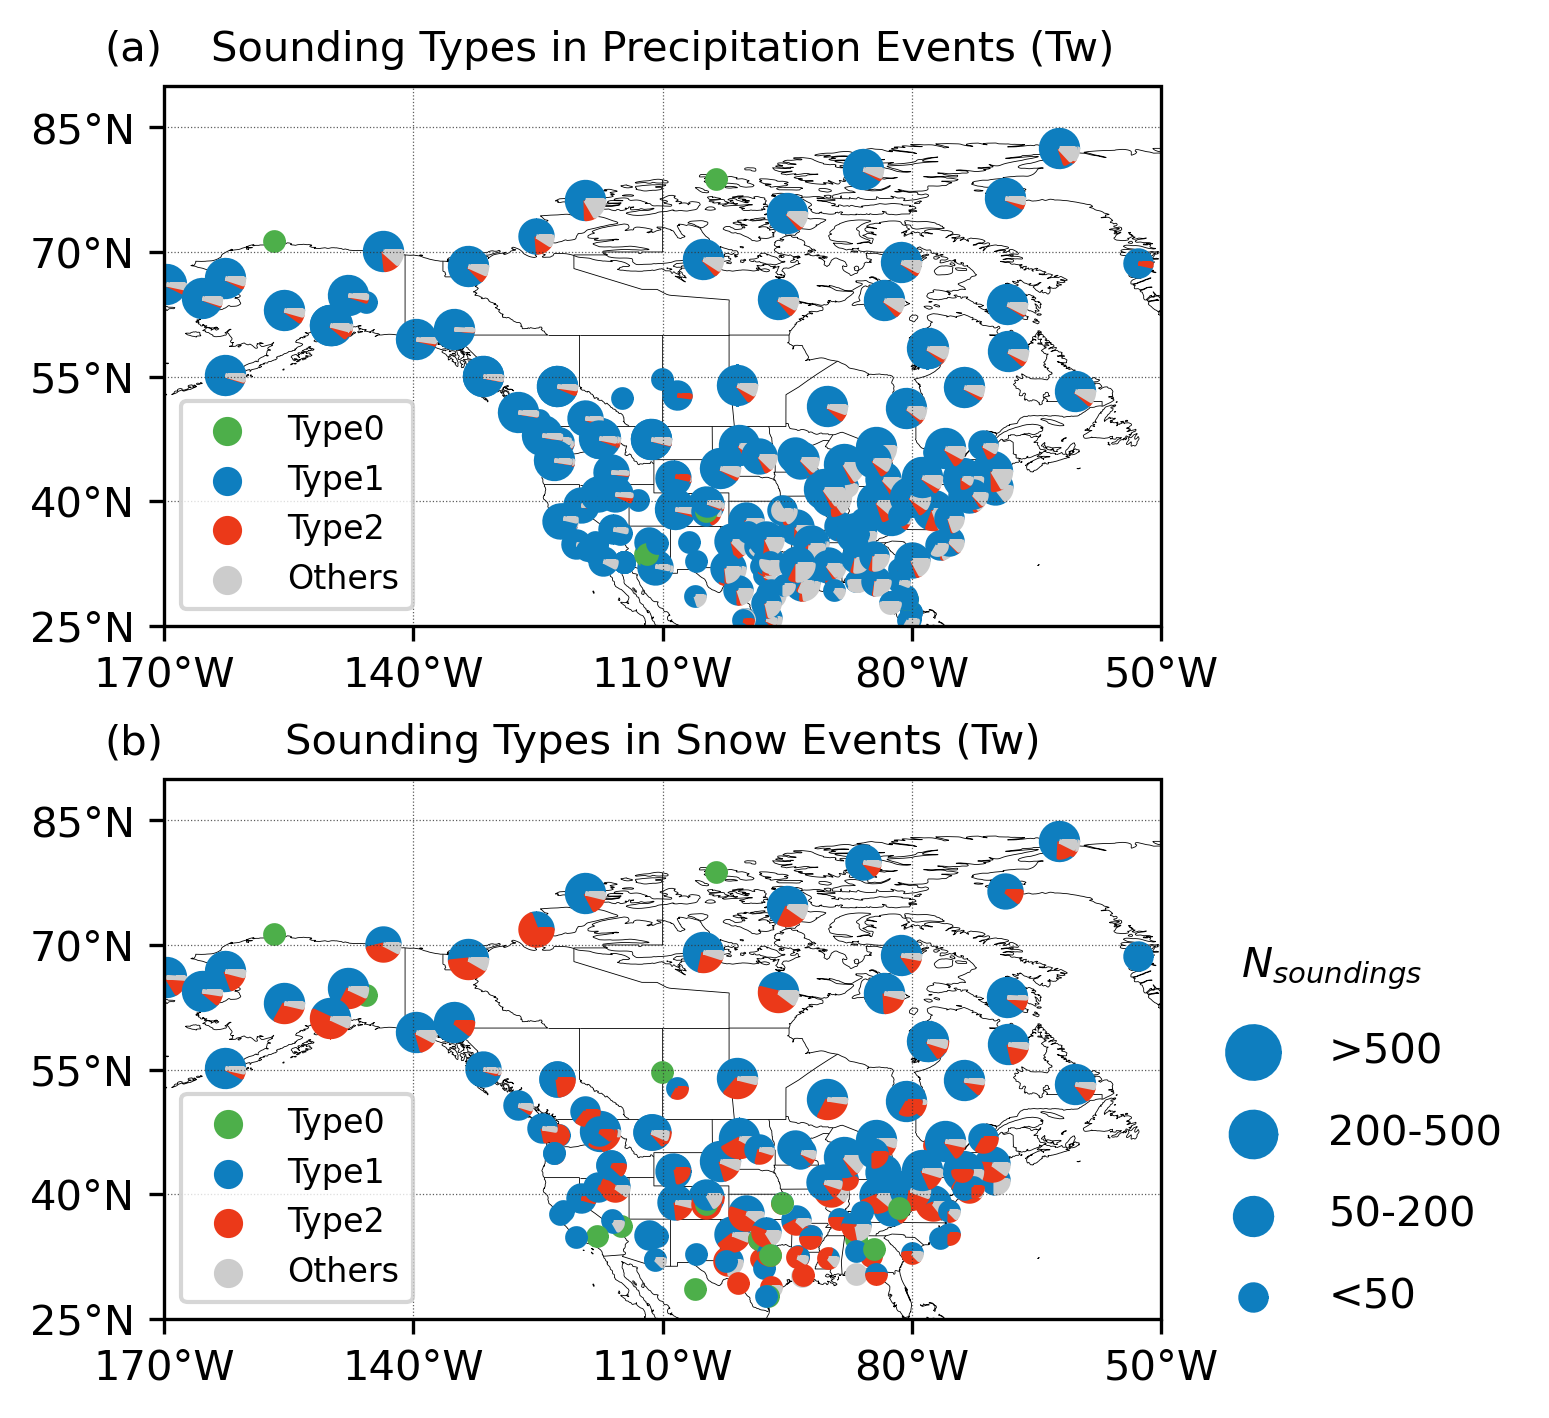

In [110]:
leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 90)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15

fig = plt.figure(figsize=(7.5, 6), dpi=300)  
ax1  = fig.add_axes([0.15, 0.55, 0.65, 0.3], projection=proj)
plot_basemap(ax1, img_extent, dlon, dlat)

stations_t10 = stations.loc[ratio_tw10.index]
for ID in stations_t10.index:
    num = num_sounding_tw10.loc[ID, 'total']
    if num<=50:
        rsize = 20
    elif num<=200:
        rsize=40
    elif num<=500:
        rsize=60
    else:
        rsize=80
        
    if ratio_tw10.loc[ID, 'type0']==1:
        drawPieMarker(ax1,
                      xs=stations_t10.loc[ID, 'LON'],
                      ys=stations_t10.loc[ID, 'LAT'],
                      ratios=[1],
                      sizes=[rsize],
                      colors=[green])
        continue
        
    if ratio_excluded_tw10.loc[ID, 'type1'] == 1:
        ratios = [1]
        colors = [blue]
    elif ratio_excluded_tw10.loc[ID, 'type2'] == 0:
        ratios = [ratio_excluded_tw10.loc[ID, 'type1'],
                  ratio_excluded_tw10.loc[ID, 'others']]
        colors = [blue, gray]
    elif ratio_excluded_tw10.loc[ID, 'others'] == 0:
        ratios = [ratio_excluded_tw10.loc[ID, 'type1'],
                  ratio_excluded_tw10.loc[ID, 'type2']]
        colors = [blue, red]
    else:
        ratios = [
                  ratio_excluded_tw10.loc[ID, 'type1'], 
                  ratio_excluded_tw10.loc[ID, 'type2'],
                  ratio_excluded_tw10.loc[ID, 'others'],
                 ]
        colors = [blue, red, gray]
    drawPieMarker(ax1,
                  xs=stations_t10.loc[ID, 'LON'],
                  ys=stations_t10.loc[ID, 'LAT'],
                  ratios=ratios,
                  sizes=[rsize],
                  colors=colors)
ax1.set_title('Sounding Types in Precipitation Events (Tw)', fontsize=10)
ax1.set_title('(a)', loc='left',x=-0.06, fontsize=10)
sct0 = ax1.scatter(-130, 0, facecolor=green)
sct1 = ax1.scatter(-130, 0, facecolor=blue)
sct2 = ax1.scatter(-130, 0, facecolor=red)
sct3 = ax1.scatter(-130, 0, facecolor=gray)
ax1.legend( [sct0, sct1, sct2, sct3], 
           ['Type0', 'Type1','Type2','Others'],
          loc='lower left',
          fontsize=8)


ax2  = fig.add_axes([0.15, 0.165, 0.65, 0.3], projection=proj)
plot_basemap(ax2, img_extent, dlon, dlat)
stations_t10 = stations.loc[ratio_tw10_snow.index]
for ID in stations_t10.index:
    num = num_sounding_tw10_snow.loc[ID, 'total']
    if num<=50:
        rsize = 20
    elif num<=200:
        rsize=40
    elif num<=500:
        rsize=60
    else:
        rsize=80
        
    if ratio_tw10_snow.loc[ID, 'type0']==1:
        drawPieMarker(ax2,
                      xs=stations_t10.loc[ID, 'LON'],
                      ys=stations_t10.loc[ID, 'LAT'],
                      ratios=[1],
                      sizes=[rsize],
                      colors=[green])
        continue
        
    if ratio_excluded_tw10_snow.loc[ID, 'type1'] == 1:
        ratios = [1]
        colors = [blue]
    elif ratio_excluded_tw10_snow.loc[ID, 'type2'] == 0:
        ratios = [ratio_excluded_tw10_snow.loc[ID, 'type1'],
                  ratio_excluded_tw10_snow.loc[ID, 'others']]
        colors = [blue, gray]
    elif ratio_excluded_tw10_snow.loc[ID, 'others'] == 0:
        ratios = [ratio_excluded_tw10_snow.loc[ID, 'type1'],
                  ratio_excluded_tw10_snow.loc[ID, 'type2']]
        colors = [blue, red]
    else:
        ratios = [
                  ratio_excluded_tw10_snow.loc[ID, 'type1'], 
                  ratio_excluded_tw10_snow.loc[ID, 'type2'],
                  ratio_excluded_tw10_snow.loc[ID, 'others'],
                 ]
        colors = [blue, red, gray]
    drawPieMarker(ax2,
                  xs=stations_t10.loc[ID, 'LON'],
                  ys=stations_t10.loc[ID, 'LAT'],
                  ratios=ratios,
                  sizes=[rsize],
                  colors=colors)

ax2.set_title('Sounding Types in Snow Events (Tw)', fontsize=10)
ax2.set_title('(b)', loc='left', x=-0.06, fontsize=10)

sct11 = drawPieMarker(ax2, 30, 40, [1], [160], [blue])
sct12 = drawPieMarker(ax2, 30, 40, [1], [120], [blue])
sct13 = drawPieMarker(ax2, 30, 40, [1], [80], [blue])
sct14 = drawPieMarker(ax2, 30, 40, [1], [40], [blue])
legend2 = plt.legend([sct11, sct12, sct13, sct14],
                     ['>500', '200-500', '50-200', '<50'],
                     bbox_to_anchor=[1.38, .60],
                     frameon=False,
                     labelspacing=1)
ax2.add_artist(legend2)
ax2.text(1.08, 0.63, '$N_{soundings}$',transform=ax2.transAxes)

sct0 = ax2.scatter(30, 0, facecolor=green)
sct1 = ax2.scatter(30, 0, facecolor=blue)
sct2 = ax2.scatter(30, 0, facecolor=red)
sct3 = ax2.scatter(30, 0, facecolor=gray)
ax2.legend( [sct0, sct1, sct2, sct3], 
           ['Type0', 'Type1','Type2','Others'],
          loc='lower left',
          fontsize=8)

plt.savefig(figpath+'Figure3', dpi=300, bbox_inches='tight')
plt.savefig(figpath+'Figure3.eps',format='eps', dpi=300, bbox_inches='tight')

In [149]:
stations_t10[(stations_t10.LON>-105) & (stations_t10.LON<-95)  & (stations_t10.LAT>60) & (stations_t10.LAT<70)]

IGRA_ID   LAT    LON  ELEV
NCEP_ID                                
CYBK     CAM00071926  64.3 -96.08    18

In [152]:
ratio_excluded_tw10_snow.loc['CYBK']

type0          NaN
type1     0.461538
type2     0.435897
others    0.102564
Name: CYBK, dtype: float64

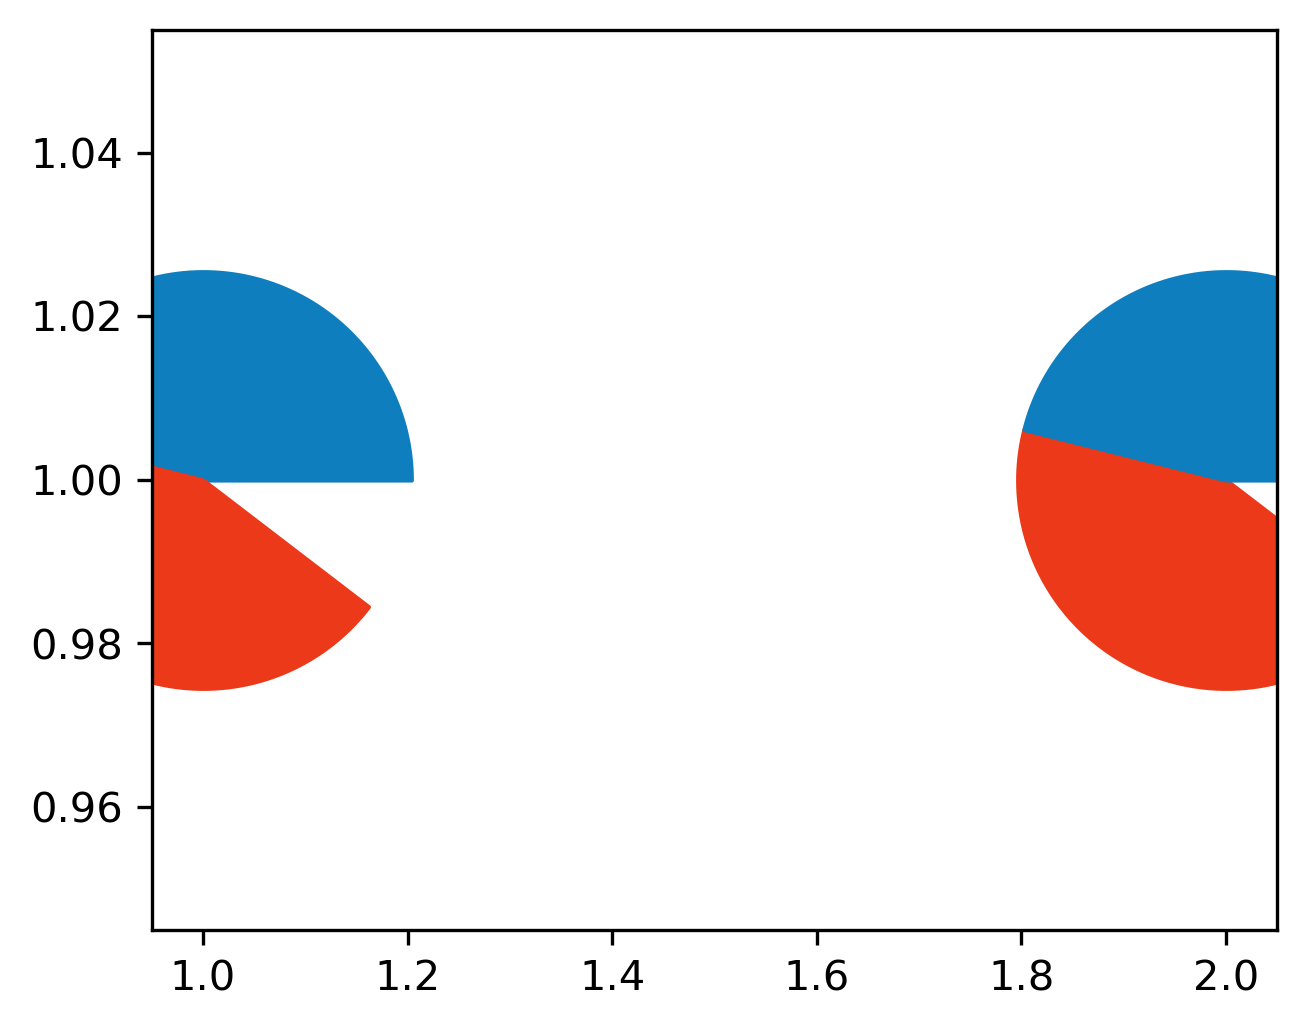

In [ ]:
def drawPieMarker(ax, xs, ys, ratios, sizes, colors):
    '''
    draw a pie marker at a given location
    https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
    
    xs, ys: arrays of xs and ys
    
    '''
    # assert sum(ratios) <= 1, 'sum of ratios needs to be <= 1'

    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous # angle
        x  = [0] + np.cos(np.linspace(previous, this, 100)).tolist() + [0] # polygon
        y  = [0] + np.sin(np.linspace(previous, this, 100)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        
        #for wedges that never reach the min or max x or y, you need a rescaling
        sizes_scaled = np.abs(xy).max()**2*np.array(sizes)  
        
        markers.append({'marker':xy, 's':sizes_scaled, 'facecolor':color}) 

    # scatter each of the pie pieces to create pies
    for marker in markers:
        sct = ax.scatter(xs, ys, **marker)
    return sct

# green = np.array([102,194,165])/255
fig = plt.figure(figsize=(5, 4), dpi=300)  
ax  = fig.add_axes([0.15, 0.15, 0.75, 0.75])
ratios=[.461, .435]
sizes=[ 10000]
colors=[blue, red]
xss = [1, 2]
yss = [1, 2]

markers = []
previous = 0

# calculate the points of the pie pieces
color = colors[0]
ratio = ratios[0]
this = 2 * np.pi * ratio + previous # angle
x  = [0] + np.cos(np.linspace(previous, this, 100)).tolist() + [0] # polygon
y  = [0] + np.sin(np.linspace(previous, this, 100)).tolist() + [0]
xy = np.column_stack([x, y])
previous = this

#for wedges that never reach the min or max x or y, you need a rescaling
sizes_scaled = np.abs(xy).max()**2*np.array(sizes)  
args = {'marker':xy, 's':sizes_scaled, 'facecolor':color}

sct = ax.scatter(1, 1, **args)
        
    
color = colors[1]
ratio = ratios[1]
this = 2 * np.pi * ratio + previous # angle
x  = [0] + np.cos(np.linspace(previous, this, 100)).tolist() + [0] # polygon
y  = [0] + np.sin(np.linspace(previous, this, 100)).tolist() + [0]
xys = np.column_stack([x, y])
previous = this

#for wedges that never reach the min or max x or y, you need a rescaling
sizes_scaled = np.abs(xy).max()**2*np.array(sizes)  
argss = {'marker':xys, 's':sizes_scaled, 'facecolor':color}

sct = ax.scatter(1, 1, **argss)


sct = ax.scatter(2, 1, **argss)
sct = ax.scatter(2, 1, **args)

        
# drawPieMarker(ax,xs=np.random.rand(1),
#               ys=np.random.rand(1),
#               ratios=[.461, .435],
#               sizes=[ 10000],
#               colors=[blue, red
#                      ])
plt.show()

In [167]:
color

array([0.05490196, 0.49411765, 0.74901961])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


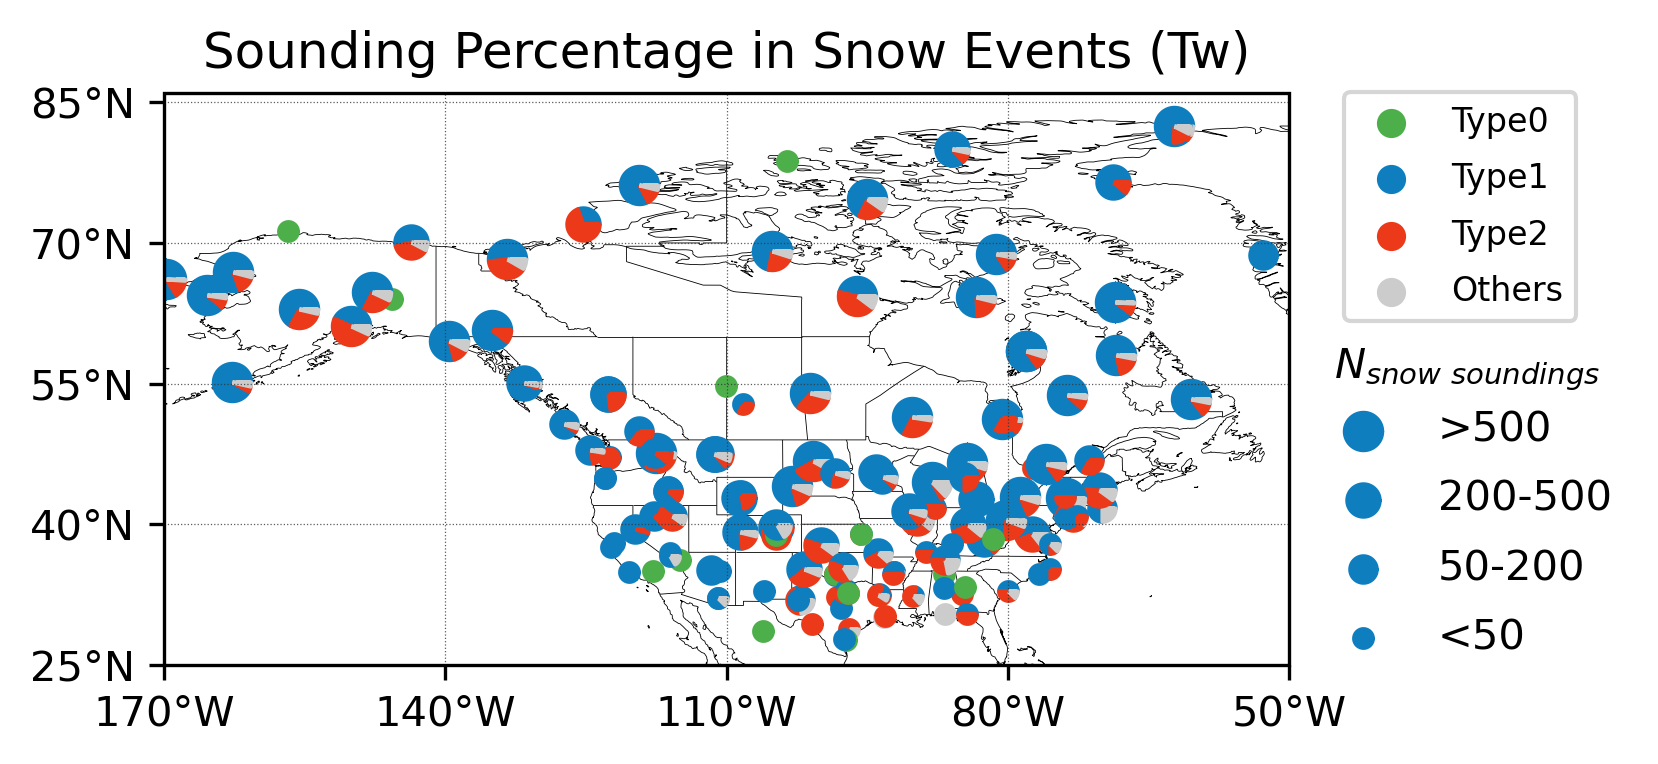

In [187]:
leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 86)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15

proj = ccrs.PlateCarree(central_longitude=0)   
fig = plt.figure(figsize=(5, 4), dpi=300)  
ax  = fig.add_axes([0.15, 0.15, 0.75, 0.75], projection=proj)

plot_basemap(ax, img_extent, dlon, dlat)
stations_t10 = stations.loc[ratio_tw10_snow.index]

for ID in stations_t10.index:
    num = num_sounding_tw10_snow.loc[ID, 'total']
    if num<=50:
        rsize = 20
    elif num<=200:
        rsize=40
    elif num<=500:
        rsize=60
    else:
        rsize=80
        
    if ratio_tw10_snow.loc[ID, 'type0']==1:
        drawPieMarker(ax,
                      xs=stations_t10.loc[ID, 'LON'],
                      ys=stations_t10.loc[ID, 'LAT'],
                      ratios=[1],
                      sizes=[rsize],
                      colors=[green])
        continue
        
    if ratio_excluded_tw10_snow.loc[ID, 'type1'] == 1:
        ratios = [1]
        colors = [blue]
    elif ratio_excluded_tw10_snow.loc[ID, 'type2'] == 0:
        ratios = [ratio_excluded_tw10_snow.loc[ID, 'type1'],
                  ratio_excluded_tw10_snow.loc[ID, 'others']]
        colors = [blue, gray]
    elif ratio_excluded_tw10_snow.loc[ID, 'others'] == 0:
        ratios = [ratio_excluded_tw10_snow.loc[ID, 'type1'],
                  ratio_excluded_tw10_snow.loc[ID, 'type2']]
        colors = [blue, red]
    else:
        ratios = [
                  ratio_excluded_tw10_snow.loc[ID, 'type1'], 
                  ratio_excluded_tw10_snow.loc[ID, 'type2'],
                  ratio_excluded_tw10_snow.loc[ID, 'others'],
                 ]
        colors = [blue, red, gray]
    drawPieMarker(ax,
                  xs=stations_t10.loc[ID, 'LON'],
                  ys=stations_t10.loc[ID, 'LAT'],
                  ratios=ratios,
                  sizes=[rsize],
                  colors=colors)

ax.set_title('Sounding Percentage in Snow Events (Tw)', fontsize=12)

sct11 = drawPieMarker(ax, 30, 40, [1], [80], [blue])
sct12 = drawPieMarker(ax, 30, 40, [1], [60], [blue])
sct13 = drawPieMarker(ax, 30, 40, [1], [40], [blue])
sct14 = drawPieMarker(ax, 30, 40, [1], [20], [blue])
legend2 = plt.legend([sct11, sct12, sct13, sct14], 
                     ['>500', '200-500', '50-200', '<50'], 
                     bbox_to_anchor=[1.32, .51],
                     frameon=False,
                     labelspacing=0.7,
                     fontsize=10
                    )
ax.add_artist(legend2)
sct0 = ax.scatter(30, 0, facecolor=green)
sct1 = ax.scatter(30, 0, facecolor=blue)
sct2 = ax.scatter(30, 0, facecolor=red)
sct3 = ax.scatter(30, 0, facecolor=gray)
ax.legend( [sct0, sct1, sct2, sct3], 
           ['Type0', 'Type1','Type2','Others'],
          bbox_to_anchor=[1.27, 1.03],
          fontsize=8, labelspacing=0.7)
           # 

ax.text(1.04, 0.50, '$N_{snow\ soundings}$',transform=ax.transAxes)

# plt.savefig('../03-Figure/20220530_scheme/'+'Figure3', dpi=300, bbox_inches='tight')
plt.savefig(figpath+'Figure3_2', dpi=300, bbox_inches='tight')
plt.savefig(figpath+'Figure3_2.eps',format='eps', dpi=300, bbox_inches='tight')

# ---------- Type I ----------

# One layer, snow probability-PA | compare t and tw

## data

non missing t, tw, PA_t, PA_tw, lapse rate based on t and tw

In [283]:
datapath = '../02-Output/NA/'

compare_type1_t_de = pd.read_csv(datapath+'compare_type1_t_de.txt', index_col=0)
compare_type1_tw_de = pd.read_csv(datapath+'compare_type1_tw_de.txt', index_col=0)

In [284]:
compare_type1_t_de

datetime    lat     lon    elev     t   td      p     slp  \
46      1978-04-17 12:00:00  53.97  258.90   271.0   2.0 -1.0  981.1  1014.5   
48      1978-04-23 00:00:00  53.97  258.90   271.0   5.0  4.0  978.2  1011.7   
52      1978-05-25 12:00:00  53.97  258.90   271.0   6.0  5.0  971.2  1004.0   
53      1978-05-30 12:00:00  53.97  258.90   271.0   8.0  7.0  983.0  1016.0   
54      1978-06-03 12:00:00  53.97  258.90   271.0  10.0  4.0  982.6  1015.6   
...                     ...    ...     ...     ...   ...  ...    ...     ...   
331018  2018-09-28 00:00:00  47.47  248.62  1131.0   3.9  3.9  895.8  1026.1   
331019  2018-09-30 00:00:00  47.47  248.62  1131.0   1.1  1.1  894.6  1026.4   
331021  2018-10-05 00:00:00  47.47  248.62  1131.0   2.2  2.2  884.0  1015.1   
331022  2018-10-10 00:00:00  47.47  248.62  1131.0   4.4  1.1  889.7  1021.0   
331025  2018-11-01 00:00:00  47.47  248.62  1131.0   5.6 -1.1  883.1  1012.6   

          ww    tw  ...  lowest_z_tw  IGRA_lon  IGRA_lat      IGRA_ID  \
46      80.0  0.74  ...        270.0  258.9000   53.9667  CAM00071867   
48      61.0  4.51  ...        270.0  258.9000   53.9667  CAM00071867   
52      61.0  5.49  ...        270.0  258.9000   53.9667  CAM00071867   
53      80.0  7.46  ...        441.0  258.9000   53.9667  CAM00071867   
54      61.0  6.95  ...        270.0  258.9000   53.9667  CAM00071867   
...      ...   ...  ...          ...       ...       ...          ...   
331018  61.0  3.90  ...       1134.0  248.6153   47.4614  USM00072776   
331019  61.0  1.10  ...       1134.0  248.6153   47.4614  USM00072776   
331021  61.0  2.20  ...       1134.0  248.6153   47.4614  USM00072776   
331022  61.0  2.82  ...       1134.0  248.6153   47.4614  USM00072776   
331025  61.0  2.52  ...       1134.0  248.6153   47.4614  USM00072776   

        NCEP_ID     ID      PA_t  NA_t     PA_tw  NA_tw  
46        71867  71867   66.4804  -0.0   32.3724   -0.0  
48        71867  71867  142.0810  -0.0   95.9844   -0.0  
52        71867  71867  640.1040  -0.0  454.4277   -0.0  
53        71867  71867  483.5777  -0.0  351.9293   -0.0  
54        71867  71867  556.2194  -0.0  340.1034   -0.0  
...         ...    ...       ...   ...       ...    ...  
331018    72776  72776   39.3982  -0.0   37.0470   -0.0  
331019    72776  72776   12.8772  -0.0    8.9670   -0.0  
331021    72776  72776   12.4845  -0.0    3.9863   -0.0  
331022    72776  72776   44.9144  -0.0   21.0731   -0.0  
331025    72776  72776   77.1626  -0.0   15.8530   -0.0  

[29932 rows x 46 columns]

## calculation function

In [189]:
# fit with exponential
def ConpExp(x, m, t):
    '''exponential function crossing (0, 1)'''
    return m * np.exp(-t * x) + 1-m 
from sklearn.metrics import r2_score

def conp_PA(df):
    df_rain = df[df.wwflag==1]
    df_snow = df[df.wwflag==2]

    pre_rain = df_rain.loc[:, 'posi_area1']
    pre_snow = df_snow.loc[:, 'posi_area1']

    binsize=5
    num_rain = pd.DataFrame(data=0, index=[0], columns=np.arange(binsize/2, 200, binsize))
    num_snow = pd.DataFrame(data=0, index=[0], columns=np.arange(binsize/2, 200, binsize))
    for col in num_rain.columns:
        num_rain.loc[0, col] += ((pre_rain>col-binsize/2) & (pre_rain<=col+binsize/2)).sum()
        num_snow.loc[0, col] += ((pre_snow>col-binsize/2) & (pre_snow<=col+binsize/2)).sum()
    conp = num_snow/(num_snow+num_rain)

    xs, ys = conp.columns.values, conp.loc[0]
    popt, pcov = opt.curve_fit(ConpExp, xs, ys)
    y_pred = ConpExp(xs, *popt)
    r2_score(ys, y_pred)

    x50 = -np.log((0.5+popt[0]-1)/popt[0])/popt[1]

    return conp, x50, popt 

## Result

In [190]:
conp_t,  tPA, popt_t  = conp_PA(compare_type1_t_de)
conp_tw, twPA, popt_tw = conp_PA(compare_type1_tw_de)

In [191]:
tPA

7.022454571146805

In [192]:
twPA

2.9723513421567658

In [ ]:
popt_

## Evaluation: PA threshold

In [61]:
test = pd.read_csv(datapath+'compare_evaluation_data.txt', index_col=0)

In [74]:
# t PA threshold
pre_rain = test[test.PA_t>tPA]['wwflag']
pre_snow = test[test.PA_t<=tPA]['wwflag']
print('\n---t, PA')
print_metrics(pre_rain, pre_snow)

# tw PA threshold
pre_rain = test[test.PA_tw>twPA]['wwflag']
pre_snow = test[test.PA_tw<=twPA]['wwflag']
print('\n--- Tw, PA')
print_metrics(pre_rain, pre_snow)


---t, PA
True positive: 1316 | False positive: 638 | P_PRE:1954
False negative: 945 | True negative: 43951 | N_PRE:44896 
P_OBS: 2261 | N_OBS: 44589
 | TOTAL: 46850 

Accuracy: 0.966 
Recall: 0.582 
Precision: 0.673 
F1Score: 0.312

--- Tw, PA
True positive: 1637 | False positive: 800 | P_PRE:2437
False negative: 624 | True negative: 43789 | N_PRE:44413 
P_OBS: 2261 | N_OBS: 44589
 | TOTAL: 46850 

Accuracy: 0.970 
Recall: 0.724 
Precision: 0.672 
F1Score: 0.348


(0.9696051227321238, 0.724015922158337, 0.671727533853098, 0.348446147296722)

## Plot: Figure 4

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


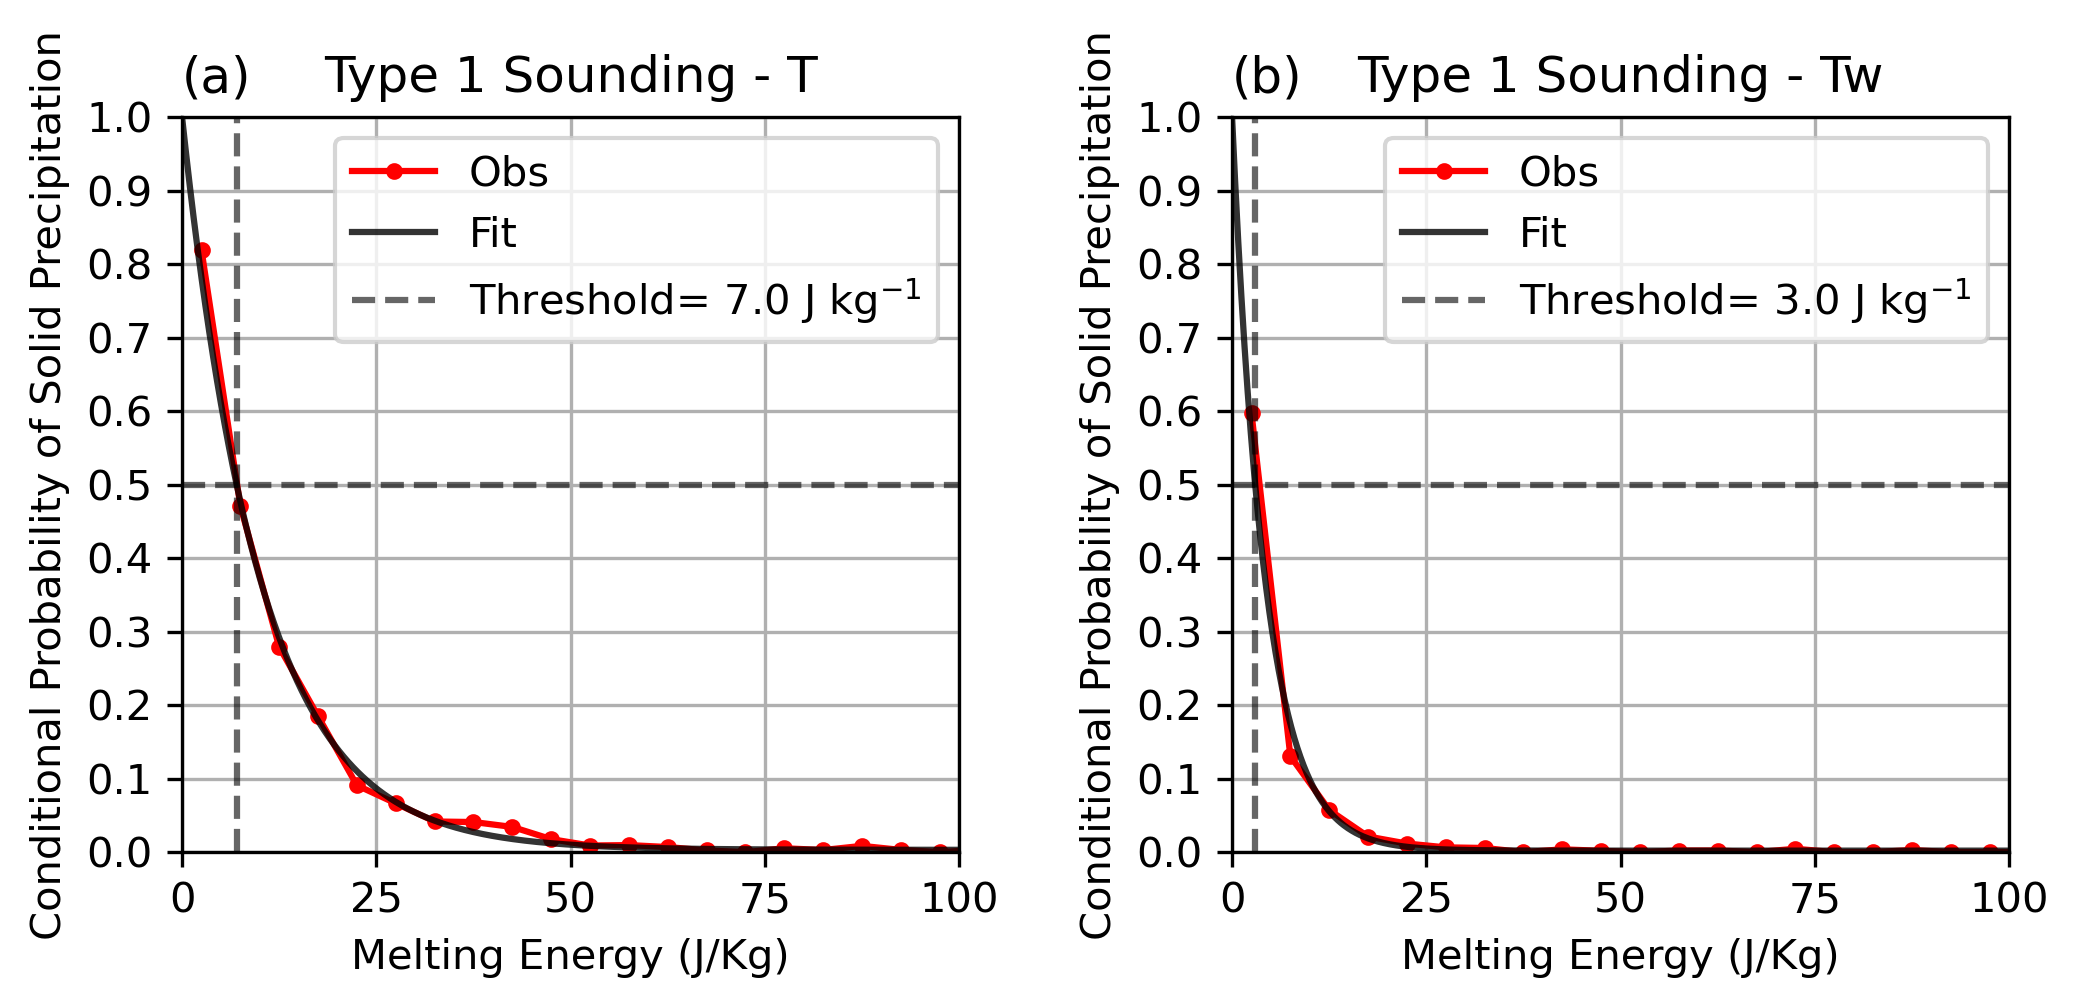

In [75]:
def plot_conp_PA(ax, conp, x50, popt, params):
    l1, = ax.plot(conp.columns.values, conp.loc[0], 'r.-')
    xfit = np.arange(0, 150, 0.1)
    l2, = ax.plot(xfit, ConpExp(xfit, *popt), 'k-', alpha=0.8)
    ax.plot([0, 1000], [0.5, 0.5], 'k--', alpha=0.6)
    l3, = ax.plot([x50, x50], [0, 1], 'k--', alpha=0.6)
    ax.set_xticks(np.arange(0, 525, 25))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 1])
    ax.grid()
    ax.legend([l1, l2, l3], ['Obs', 'Fit', 'Threshold={:4.1f}'.format(x50)+' J kg$^{-1}$'])
    ax.set_xlabel('Melting Energy (J/Kg)')
    ax.set_ylabel('Conditional Probability of Solid Precipitation')
    ax.set_title(params['title'])
    return

fig = plt.figure(figsize=(7, 3.5), dpi=300)
ax1 = fig.add_axes([0.10, 0.15, 0.37, 0.7])
ax2 = fig.add_axes([0.60, 0.15, 0.37, 0.7])

plot_conp_PA(ax1, conp_t,  tPA, popt_t, {'tstr':'T', 'title':'Type 1 Sounding - T'})
plot_conp_PA(ax2, conp_tw, twPA, popt_tw, {'tstr':'Tw', 'title':'Type 1 Sounding - Tw'})
ax1.set_title('(a)', loc='left')
ax2.set_title('(b)', loc='left')
# plt.savefig('test')
figpath = '../05-Paper/figure/final'
plt.savefig(figpath+'Figure4.eps', format='eps', bbox_inches='tight', dpi=300)
plt.savefig(figpath+'Figure4', bbox_inches='tight', dpi=300)

## use tw

In [76]:
type1_tw_de = pd.read_csv(datapath+'type1_tw_de.txt', index_col=0)
type1_tw_ev = pd.read_csv(datapath+'type1_tw_ev.txt', index_col=0)

In [78]:
conp_tw, twPA, popt_tw = conp_PA(type1_tw_de)
twPA

2.9723513421567658

In [79]:
# tw PA threshold
test = type1_tw_ev
pre_rain = test[test.PA_tw>twPA]['wwflag']
pre_snow = test[test.PA_tw<=twPA]['wwflag']
print('\n--- Tw, PA')
print_metrics(pre_rain, pre_snow)


--- Tw, PA
True positive: 1677 | False positive: 835 | P_PRE:2512
False negative: 653 | True negative: 49381 | N_PRE:50034 
P_OBS: 2330 | N_OBS: 50216
 | TOTAL: 52546 

Accuracy: 0.972 
Recall: 0.720 
Precision: 0.668 
F1Score: 0.346


(0.9716819548586001,
 0.7197424892703863,
 0.6675955414012739,
 0.34634448574969023)

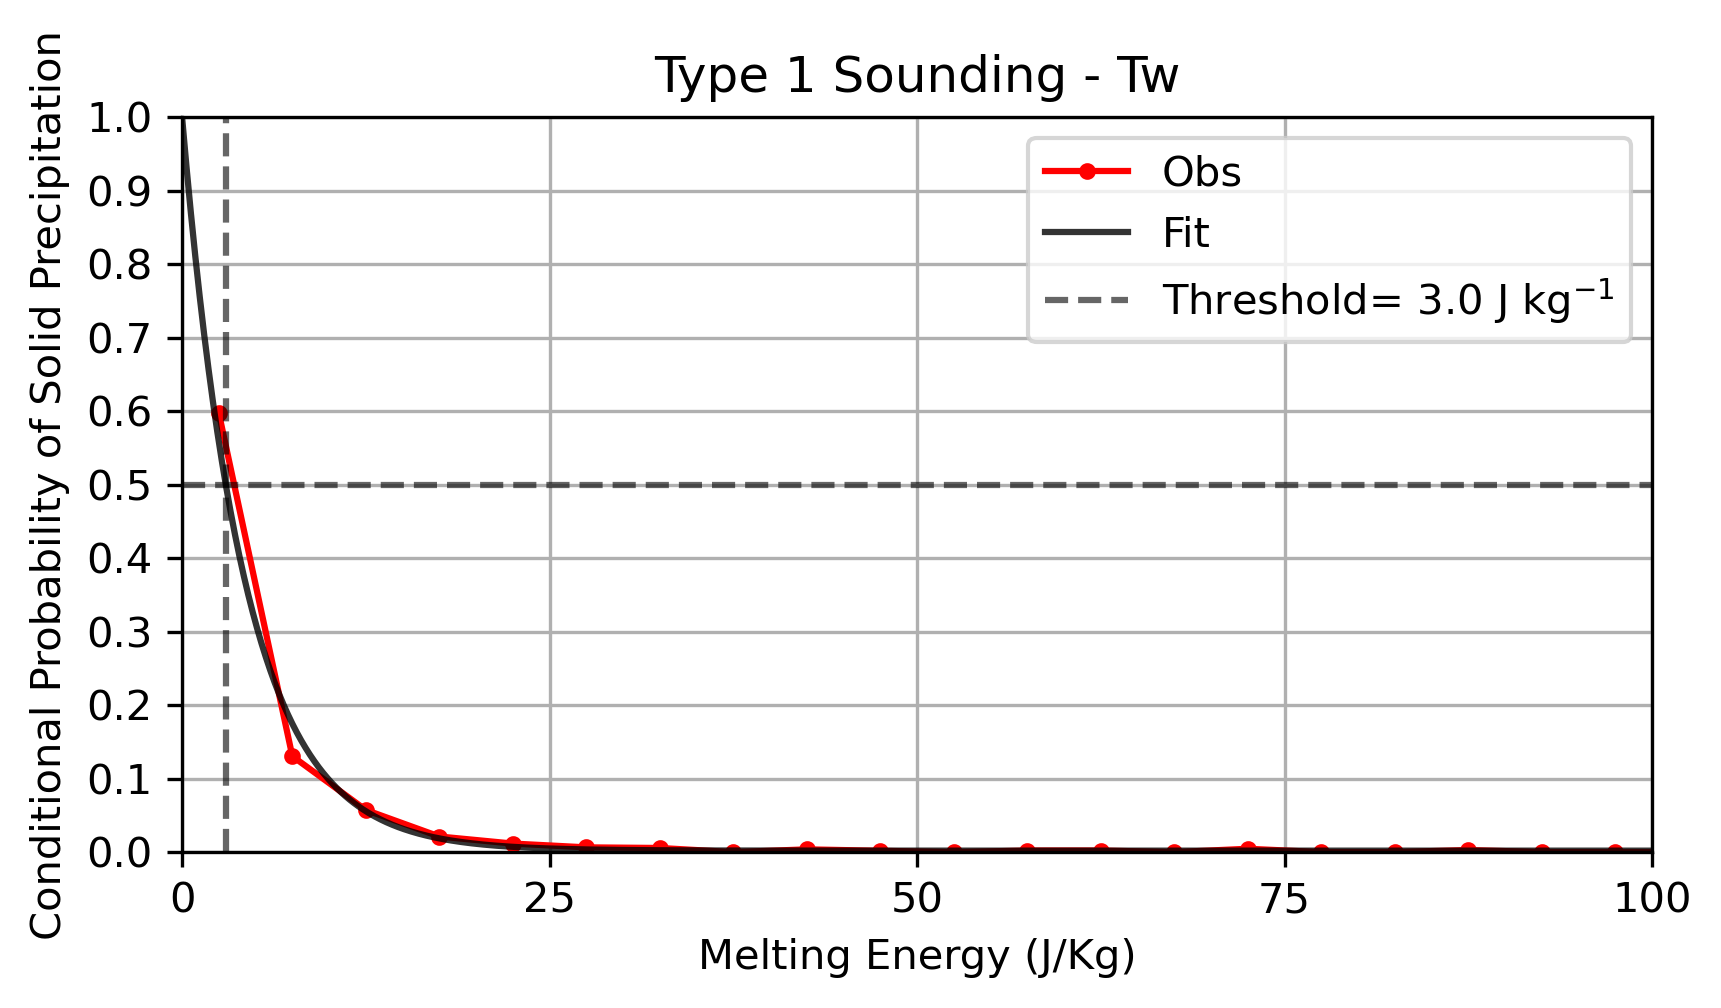

In [80]:
def plot_conp_PA(ax, conp, x50, popt, params):
    l1, = ax.plot(conp.columns.values, conp.loc[0], 'r.-')
    xfit = np.arange(0, 150, 0.1)
    l2, = ax.plot(xfit, ConpExp(xfit, *popt), 'k-', alpha=0.8)
    ax.plot([0, 1000], [0.5, 0.5], 'k--', alpha=0.6)
    l3, = ax.plot([x50, x50], [0, 1], 'k--', alpha=0.6)
    ax.set_xticks(np.arange(0, 525, 25))
    ax.set_yticks(np.arange(0, 1.1, 0.1))
    ax.set_xlim([0, 100])
    ax.set_ylim([0, 1])
    ax.grid()
    ax.legend([l1, l2, l3], ['Obs', 'Fit', 'Threshold={:4.1f}'.format(x50)+' J kg$^{-1}$'])
    ax.set_xlabel('Melting Energy (J/Kg)')
    ax.set_ylabel('Conditional Probability of Solid Precipitation')
    ax.set_title(params['title'])
    return

fig = plt.figure(figsize=(7, 3.5), dpi=300)
ax1 = fig.add_axes([0.10, 0.15, 0.7, 0.7])

plot_conp_PA(ax1, conp_tw, twPA, popt_tw, {'tstr':'Tw', 'title':'Type 1 Sounding - Tw'})

### vertical version

Text(0.0, 1.0, '(b)')

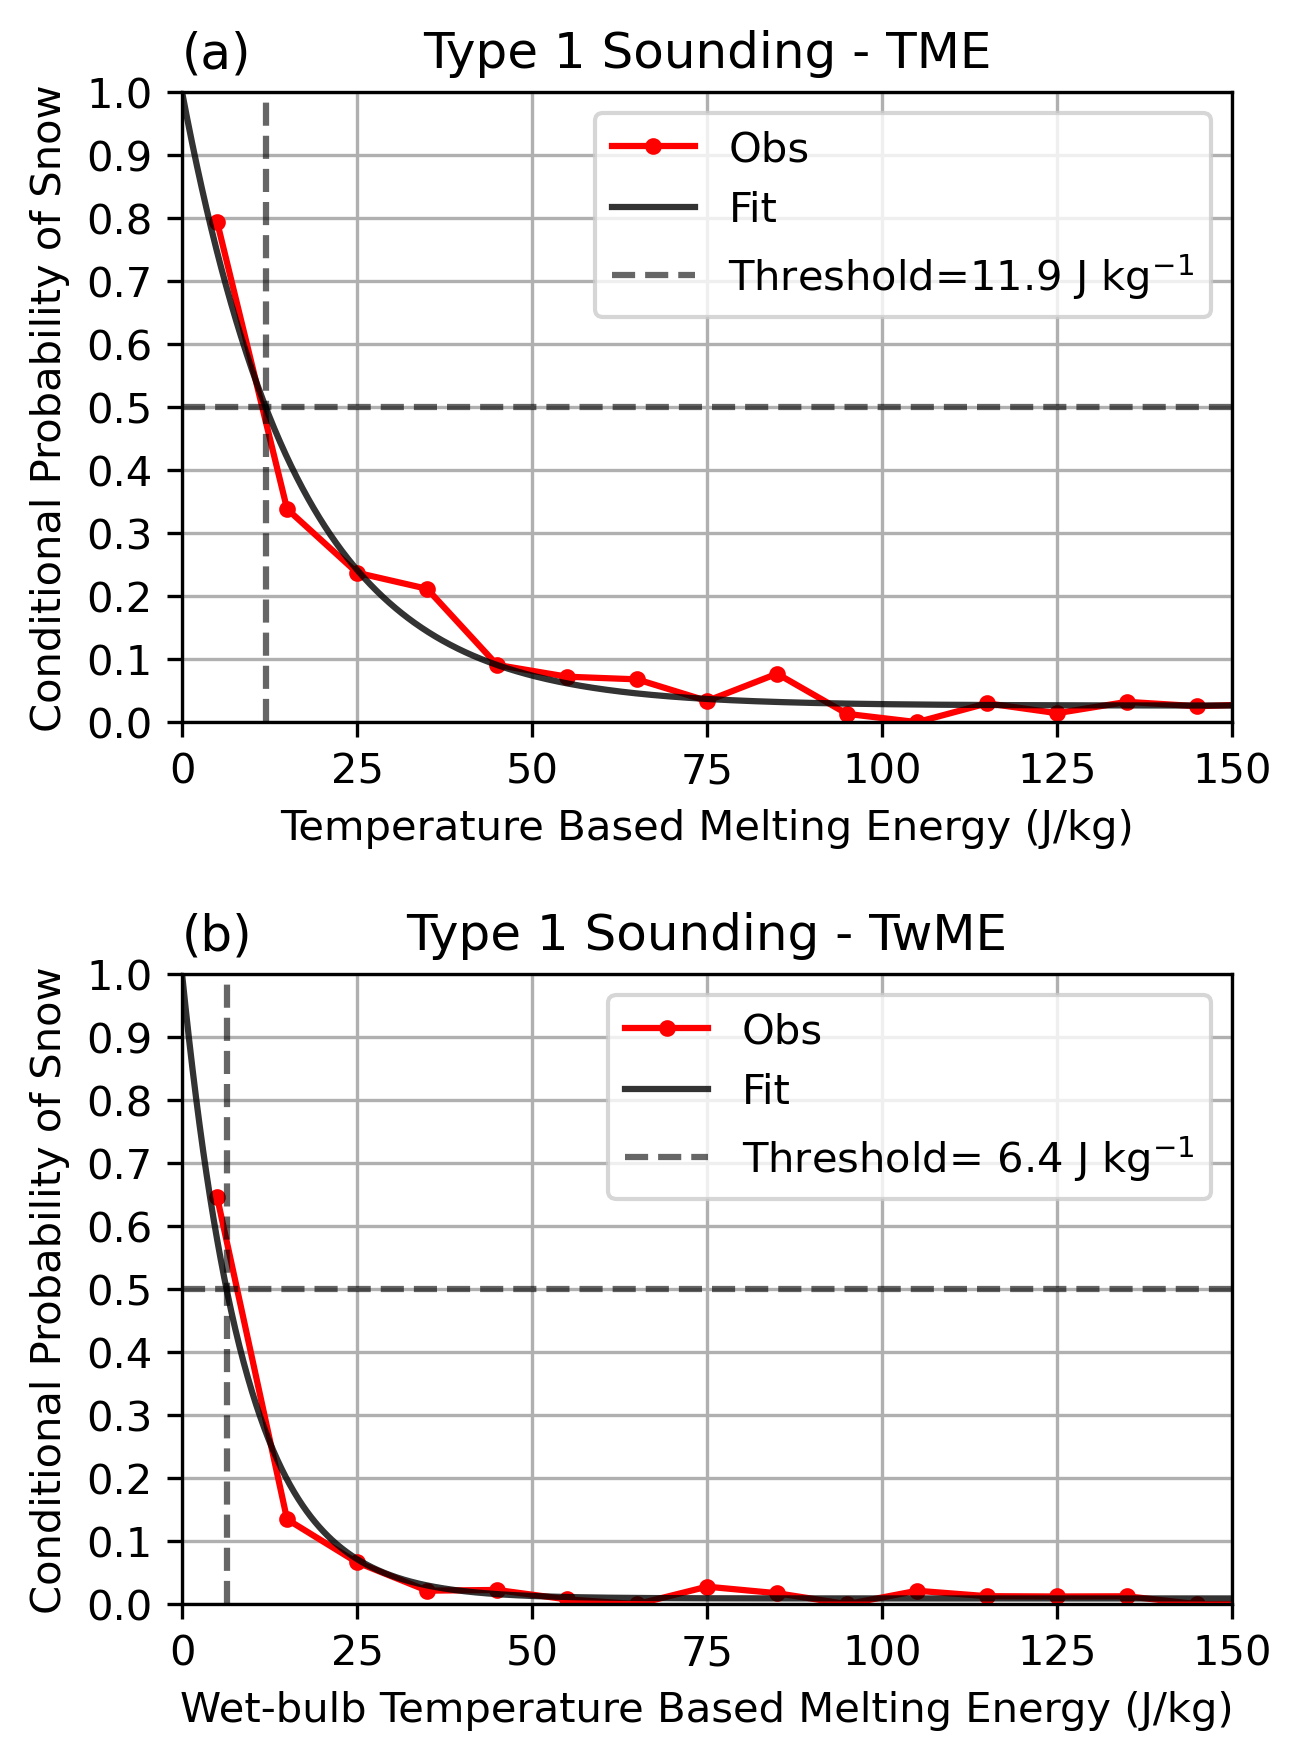

In [35]:
xfit = np.arange(0, 150, 0.1)

fig = plt.figure(figsize=(5, 7), dpi=300)

ax = fig.add_axes([0.15, 0.52, 0.7, 0.3])
ax2 = fig.add_axes([0.15, 0.1, 0.7, 0.3])

l1, = ax.plot(conp_t.columns.values, conp_t.loc[0], 'r.-')
l2, = ax.plot(xfit, monoExp(xfit, *popt_t), 'k-', alpha=0.8)
ax.plot([0, 1000], [0.5, 0.5], 'k--', alpha=0.6)
l3, = ax.plot([tPA, tPA], [0, 1], 'k--', alpha=0.6)
ax.set_xticks(np.arange(0, 525, 25))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xlim([0, 150])
ax.set_ylim([0, 1])
ax.grid()
ax.legend([l1, l2, l3], ['Obs', 'Fit', 'Threshold={:4.1f}'.format(tPA)+' J kg$^{-1}$'])
ax.set_xlabel('Temperature Based Melting Energy (J/kg)')
ax.set_ylabel('Conditional Probability of Snow')
ax.set_title('Type 1 Sounding - TME')

l1, = ax2.plot(conp_tw.columns.values, conp_tw.loc[0], 'r.-')
l2, = ax2.plot(xfit, monoExp(xfit, *popt_tw), 'k-', alpha=0.8)
ax2.plot([0, 1000], [0.5, 0.5], 'k--', alpha=0.6)
l3, = ax2.plot([twPA, twPA], [0, 1], 'k--', alpha=0.6)
ax2.set_xticks(np.arange(0, 525, 25))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.set_xlim([0, 150])
ax2.set_ylim([0, 1])
ax2.grid()
ax2.legend([l1, l2, l3], ['Obs', 'Fit', 'Threshold={:4.1f}'.format(twPA)+' J kg$^{-1}$'])
ax2.set_xlabel('Wet-bulb Temperature Based Melting Energy (J/kg)')
ax2.set_ylabel('Conditional Probability of Snow')
ax2.set_title('Type 1 Sounding - TwME')

ax.set_title('(a)', loc='left', fontsize=12)
ax2.set_title('(b)', loc='left', fontsize=12)

# ax.text(-0.06, 1.08, 'a', fontsize=12, fontweight='bold',transform=ax.transAxes)
# ax2.text(-0.06, 1.08, 'b', fontsize=12, fontweight='bold',transform=ax2.transAxes)

# plt.savefig('../05-Paper/figure/conp.eps', format='eps', bbox_inches='tight', dpi=300)
# plt.savefig('../05-Paper/figure/conp', bbox_inches='tight', dpi=300)

### evaluation of probsnow on server. try save the data and load

# Tw + TwME

## data

In [19]:
type1_tw_de = pd.read_csv(datapath+'type1_tw_de.txt', index_col=0)
rain = type1_tw_de[(type1_tw_de.wwflag==1)]
snow = type1_tw_de[(type1_tw_de.wwflag==2)]

type1_tw_de

datetime    lat     lon    elev     t   td      p     slp  \
40      1978-04-17 12:00:00  53.97  258.90   271.0   2.0 -1.0  981.1  1014.5   
42      1978-04-23 00:00:00  53.97  258.90   271.0   5.0  4.0  978.2  1011.7   
46      1978-05-25 12:00:00  53.97  258.90   271.0   6.0  5.0  971.2  1004.0   
47      1978-05-30 12:00:00  53.97  258.90   271.0   8.0  7.0  983.0  1016.0   
48      1978-06-03 12:00:00  53.97  258.90   271.0  10.0  4.0  982.6  1015.6   
...                     ...    ...     ...     ...   ...  ...    ...     ...   
279033  2018-09-28 00:00:00  47.47  248.62  1131.0   3.9  3.9  895.8  1026.1   
279034  2018-09-30 00:00:00  47.47  248.62  1131.0   1.1  1.1  894.6  1026.4   
279035  2018-10-05 00:00:00  47.47  248.62  1131.0   2.2  2.2  884.0  1015.1   
279036  2018-10-10 00:00:00  47.47  248.62  1131.0   4.4  1.1  889.7  1021.0   
279038  2018-11-01 00:00:00  47.47  248.62  1131.0   5.6 -1.1  883.1  1012.6   

          ww    tw  ...  lowest_z_tw  IGRA_lon  IGRA_lat      IGRA_ID  \
40      80.0  0.74  ...        270.0  258.9000   53.9667  CAM00071867   
42      61.0  4.51  ...        270.0  258.9000   53.9667  CAM00071867   
46      61.0  5.49  ...        270.0  258.9000   53.9667  CAM00071867   
47      80.0  7.46  ...        441.0  258.9000   53.9667  CAM00071867   
48      61.0  6.95  ...        270.0  258.9000   53.9667  CAM00071867   
...      ...   ...  ...          ...       ...       ...          ...   
279033  61.0  3.90  ...       1134.0  248.6153   47.4614  USM00072776   
279034  61.0  1.10  ...       1134.0  248.6153   47.4614  USM00072776   
279035  61.0  2.20  ...       1134.0  248.6153   47.4614  USM00072776   
279036  61.0  2.82  ...       1134.0  248.6153   47.4614  USM00072776   
279038  61.0  2.52  ...       1134.0  248.6153   47.4614  USM00072776   

        NCEP_ID     ID      PA_t  NA_t     PA_tw  NA_tw  
40        71867  71867   66.4804  -0.0   32.3724   -0.0  
42        71867  71867  142.0810  -0.0   95.9844   -0.0  
46        71867  71867  640.1040  -0.0  454.4277   -0.0  
47        71867  71867  483.5777  -0.0  351.9293   -0.0  
48        71867  71867  556.2194  -0.0  340.1034   -0.0  
...         ...    ...       ...   ...       ...    ...  
279033    72776  72776   39.3982  -0.0   37.0470   -0.0  
279034    72776  72776   12.8772  -0.0    8.9670   -0.0  
279035    72776  72776   12.4845  -0.0    3.9863   -0.0  
279036    72776  72776   44.9144  -0.0   21.0731   -0.0  
279038    72776  72776   77.1626  -0.0   15.8530   -0.0  

[31104 rows x 46 columns]

## Tw threshold for zero ME

In [20]:
from function.conp import *

def conp_1d(rain, snow, var, xmin, xmax, binsize):
    '''
    example: from -10 to 10, binsize=1
    columns: -9.5 to 9.5
    
    '''
    columns = np.arange(xmin, xmax, binsize)+binsize/2
    num_rain = pd.DataFrame(data=0, index=[0], columns=columns)
    num_snow = pd.DataFrame(data=0, index=[0], columns=columns)
    for col in num_rain.columns:
        num_rain.loc[0, col] += ((rain[var]>col-binsize/2) & (rain[var]<=col+binsize/2)).sum()
        num_snow.loc[0, col] += ((snow[var]>col-binsize/2) & (snow[var]<=col+binsize/2)).sum()
    conp = num_snow/(num_snow+num_rain)
    return conp, num_rain, num_snow

def conp_2d(rain, snow, xvar, yvar, params):
    '''
    on the plot, column is x axis, row is y axis
    
    Input:
        rain
        snow
        xvar, yvar: str
        params:  xmin, xmax, xbinsize, ymin, ymax, ybinsize
    Output:
        conp, num_rain, num_snow
    '''
    xmin, xmax, xbinsize, ymin, ymax, ybinsize = params
    
    # column is x axis, row is y axis on the plot
    num_rain = pd.DataFrame(data=0, 
                            index=np.arange(ymin, ymax, ybinsize)+ybinsize/2, 
                            columns=np.arange(xmin, xmax, xbinsize)+xbinsize/2)
    num_snow = pd.DataFrame(data=0, 
                            index=np.arange(ymin, ymax, ybinsize)+ybinsize/2, 
                            columns=np.arange(xmin, xmax, xbinsize)+xbinsize/2)
    for row in num_rain.index:
        for col in num_rain.columns:
            num_rain.loc[row, col] += ((rain[yvar]>row-ybinsize/2) & 
                                       (rain[yvar]<=row+ybinsize/2) & 
                                       (rain[xvar]>col-xbinsize/2) & 
                                       (rain[xvar]<=col+xbinsize/2)).sum()
            num_snow.loc[row, col] += ((snow[yvar]>row-ybinsize/2) & 
                                       (snow[yvar]<=row+ybinsize/2) &
                                       (snow[xvar]>col-xbinsize/2) & 
                                       (snow[xvar]<=col+xbinsize/2)).sum()
    conp = num_snow/(num_snow+num_rain)
    return conp, num_rain, num_snow

def fit_tanh(xs, conp):
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(tanh, xs, conp)
    return popt

def tanh(x, a, b, c, d):
    import sympy as sp
    return a*(np.tanh(b*(x-c)) - d)

def cal_t50(xs, conp):
    '''
    fit tanh function to the conditional probability
    and solve the temperature at 50% probability
    
    Input: 
        xs: temperature bins
        conp: probability at bin
    '''
    import sympy as sp
    from sympy import solve, symbols
    
    # fit tanh function
    popt = fit_tanh(xs, conp)
    
    x = symbols('x')
    
    a, b, c, d = popt
    tw50 = solve(sp.tanh(x) - 0.5/a - d, x)
    tw50 = tw50/b+c
    tw50 = tw50[0]
    return tw50

In [195]:
df = pd.read_csv(datapath+'final_all_cleaned_data.txt', index_col=0)

df_noarea = df[df.posi_area1_tw.isna() & df.nega_area1_tw.isna()]
noarea_rain = df_noarea[df_noarea.wwflag==1]
noarea_snow = df_noarea[df_noarea.wwflag==2]

conp1d,_,_ = conp_1d(noarea_rain, noarea_snow, 'tw', -10, 10, 1)
tw50_noarea = cal_t50(xs=np.arange(-9.5, 9.6, 1), conp=conp1d.values.reshape(1, 20)[0])

In [66]:
tw50_noarea

1.31833786771714

In [ ]:
tw50_noarea = 1.32

In [71]:
conp1d

-9.5      -8.5      -7.5      -6.5      -5.5      -4.5      -3.5  \
0  0.996739  0.995366  0.994226  0.993434  0.991164  0.992562  0.987981   

       -2.5      -1.5      -0.5      0.5       1.5   2.5   3.5   4.5   5.5  \
0  0.984502  0.979083  0.954294  0.89075  0.383562   0.0   0.0   0.0   0.0   

    6.5   7.5   8.5   9.5  
0   0.0   0.0   0.0   0.0

## Fit the 50% line with exponential function

(need to first plot the contours

In [235]:
params = [0, 2.5, 0.5,
           0, 8, 1]
conp, num_rain, num_snow = conp_2d(rain, snow, 'tw', 'posi_area1', params)

In [22]:
import sympy as sp
from sympy import solve, symbols
from scipy.optimize import curve_fit



def fit_50_contour(conp):
    contours = measure.find_contours(conp.values, 0.5)[0]
    X, Y = contours[:, 0], contours[:, 1]
    
    X, Y = select_data_points_for_fitting( conp)
    popt = fit_with_exp(X, Y)
    return popt, X, Y

## -------sub functions: 
def get_50_contour_values(pc):
    # input: contourf object
    # get the values of the contour line produced by Matplotlib
    X, Y = pc.collections[4].get_paths()[0].vertices.T
    idx = X.argsort()
    c50 = Y[idx]
    return c50

def monoExp(x, m, t, b):
    return m * np.exp(t * x +b) 

def select_data_points_for_fitting( conp):
    
    contours = measure.find_contours(conp.values, 0.5)[0]
    X, Y = contours[:, 0], contours[:, 1]
    
    # first column is x axis, second is y, and these are indexes that need to be 
    # broadcasted into original scale.

    # to select several data points from each bin for the function fitting
    binw = 0.2
    
    nbin = len(np.arange(0, 2+binw, binw))
    
    X = np.array(
                 X.tolist()+  
                 [6.7] +
                 [7.2] +
                 [8])
    
    Y = contours[:, 1]
    
    Y = np.array(Y.tolist() + 
                 [0.]  +
                 [0.]  +
                 [0.] )
    Y[0] = 1.32
    return X, Y



def fit_with_exp(X, Y):
    # Fit the contour with exp function
    from sklearn.metrics import r2_score
    popt, pcov = opt.curve_fit(monoExp, X, Y)
    y_pred = monoExp(X, *popt)
   
    return popt

## SupFigure 5

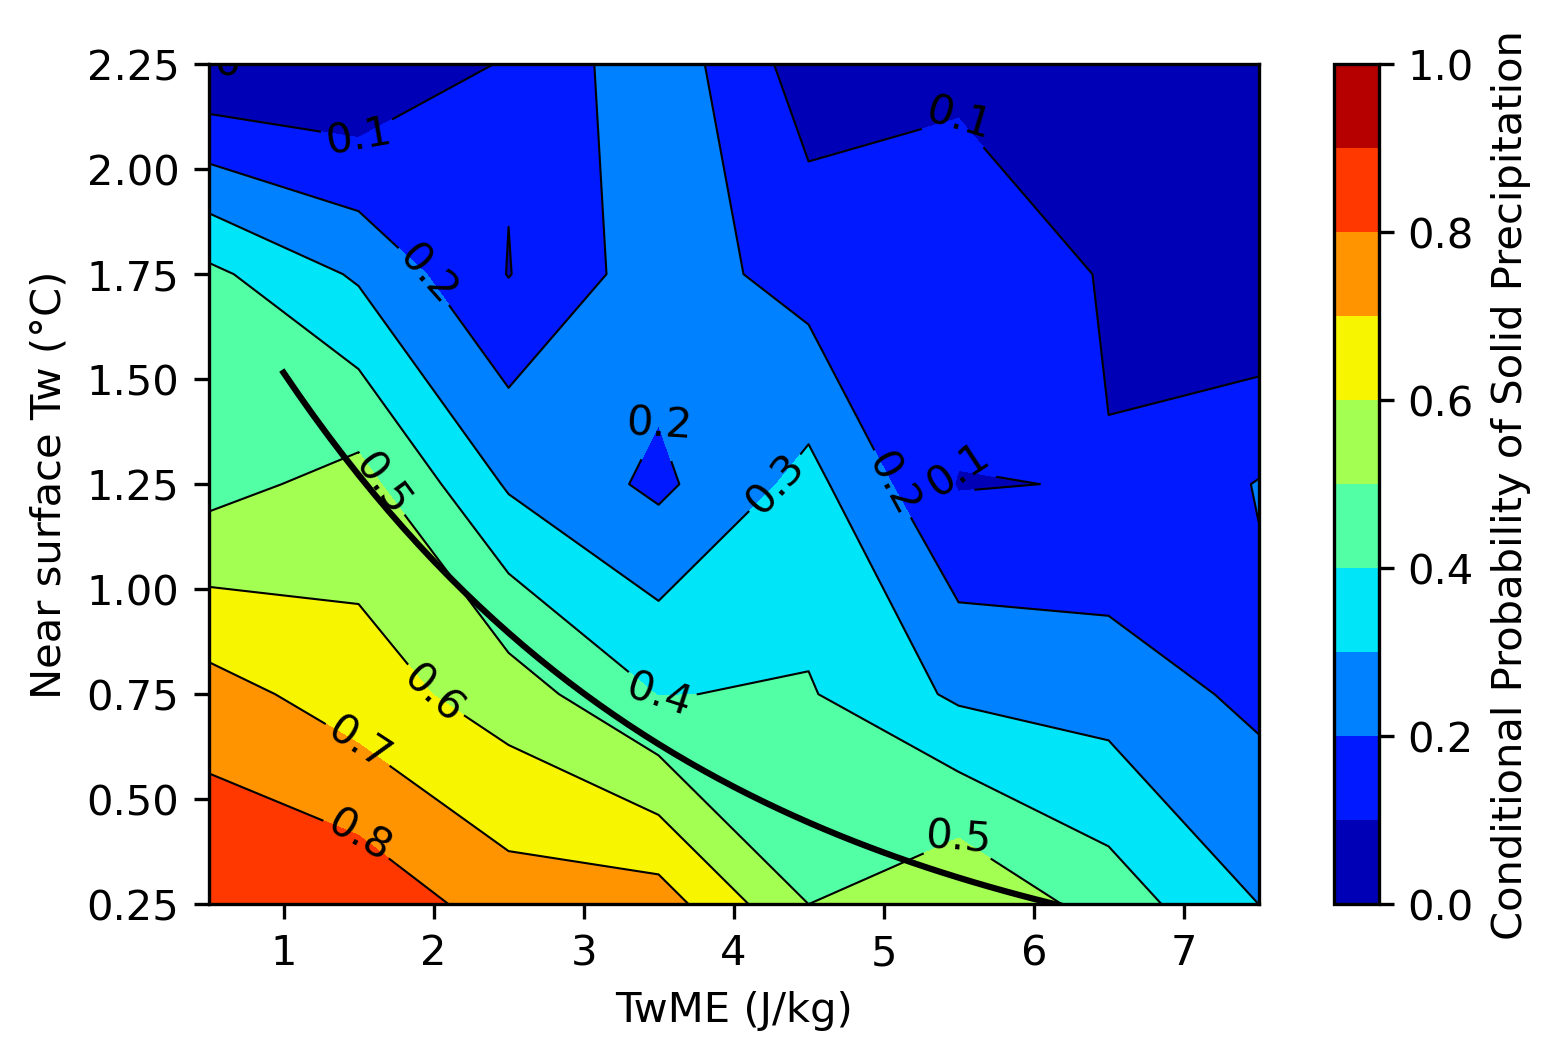

In [236]:
fig = plt.figure(figsize=(5, 4), dpi=300)
ax = fig.add_axes([0.15, 0.15, 0.7, 0.7])

# shadings
pc = ax.contourf(conp.index, conp.columns, conp.T, 
                 cmap='jet', 
                 origin='lower', levels=np.arange(0, 1.1, 0.1))
# contours
ct = ax.contour(conp.index, conp.columns, conp.T, 
                colors='k', linewidths=0.5,
                origin='lower', levels=np.arange(0, 1.1, 0.1))
ax.clabel(ct, ct.levels, inline=True, fmt='%3.1f', fontsize=10)

# plot the 50 contour
popt, X, Y = fit_50_contour(conp)
x = np.arange(1, 7., 0.1)
y = monoExp(x, *popt)## fit function
ax.plot(x, y, 'k')
# ax.plot(X, Y)
cb = plt.colorbar(pc, cax=fig.add_axes([0.9, 0.15, 0.03, 0.7]), 
                  label='Conditional Probability of Solid Precipitation')
ax.set_xlabel('TwME (J/kg)')
ax.set_ylabel('Near surface Tw ('+chr(176)+'C)')
ax.set_ylim([0.25, 2.25])
ax.set_xticks(np.arange(1, 8, 1))
# plt.savefig(figpath+'SupFigure5.eps', format='eps', dpi=300, bbox_inches='tight')
# plt.savefig(figpath+'SupFigure5',  dpi=300, bbox_inches='tight')


In [90]:
print('function is: %.2f * exp(%.2f*x + %.2f)' % (popt[0], popt[1], popt[2]))

function is: 4.34 * exp(-0.35*x + -0.70)


## Figure 5: Tw+TwME, scatter, separation

In [23]:

params = [0, 2.5, 0.5,
           0, 8, 1]
conp, num_rain, num_snow = conp_2d(rain, snow, 'tw', 'posi_area1', params)
popt, X, Y = fit_50_contour(conp)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


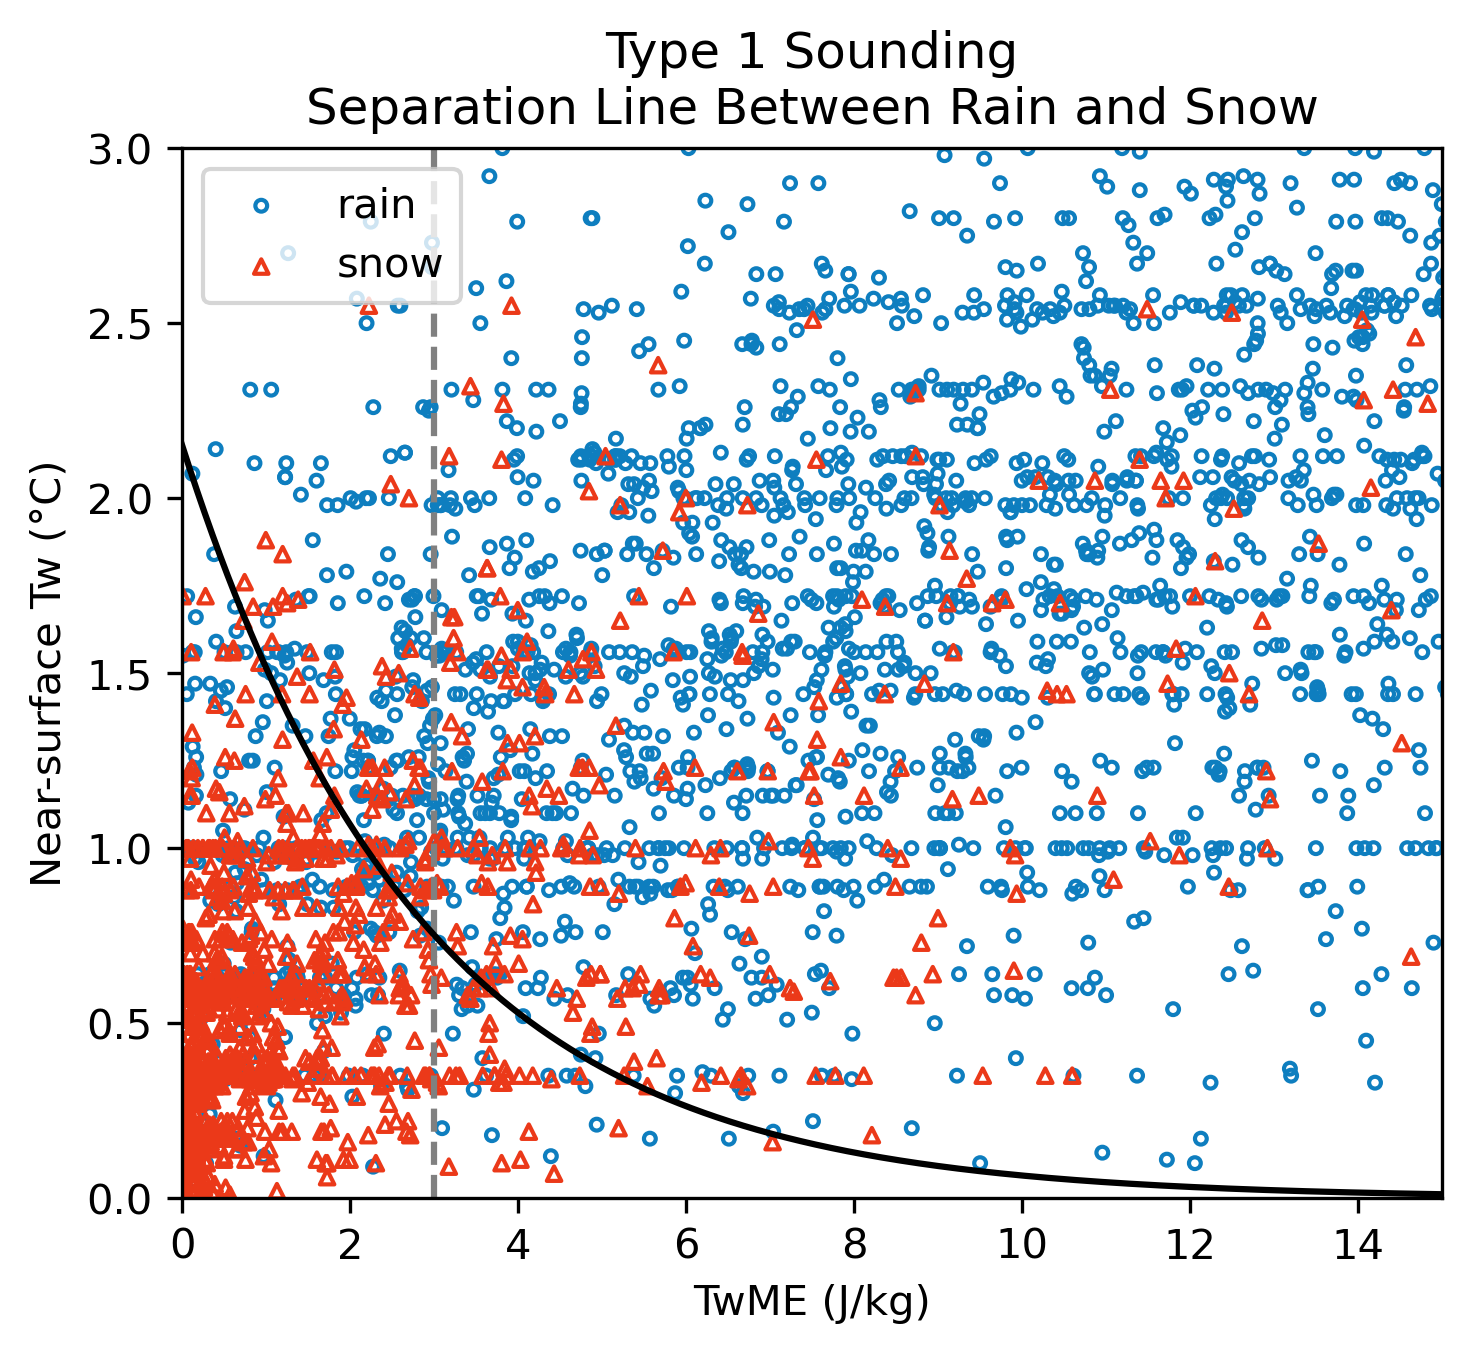

In [26]:
xmin=0
ymin=0
xmax = 15
ymax = 3

# # LDA for given range
# rain1 = rain[(rain.posi_area1<=xmax) & (rain.tw>=ymin) & (rain.tw<=ymax)]
# snow1 = snow[(snow.posi_area1<=xmax) & (snow.tw>=ymin) & (snow.tw<=ymax)]
# x_r = np.array((pd.concat([rain1.posi_area1, rain1.tw], axis=1)))
# x_s = np.array((pd.concat([snow1.posi_area1, snow1.tw], axis=1)))
# slope, intercept = LDA_boundary_line(x_r, x_s)


fig = plt.figure(figsize=(6, 5), dpi=300)
ax = fig.add_axes([0.15, 0.15, 0.7, 0.7])
s1 = ax.scatter(rain.posi_area1, rain.tw, color=blue, marker='o', facecolor='none', s=8)
s2 = ax.scatter(snow.posi_area1, snow.tw, color=red, marker='^',facecolor='none', s=12)

ax.plot([3, 3], [0, 3], '--', color='0.5')
# # LDA line
# xs = np.arange(0, xmax+0.1, 0.1)
# l1, = ax.plot(xs, (slope*xs)+intercept, '--y')

# ME
x = np.arange(0, xmax+0.01, 0.01)
y = monoExp(x, *popt) ## exp function
l2, = ax.plot(x, y, 'k')

lg = ax.legend([s1, s2], ['rain', 'snow'])
ax.set_xlim([xmin, xmax])
ax.set_ylim([xmin, ymax])
ax.set_xlabel('TwME (J/kg)')
ax.set_ylabel('Near-surface Tw ('+ chr(176) + 'C)')
ax.set_title('Type 1 Sounding\nSeparation Line Between Rain and Snow')

plt.savefig(figpath+'Figure5.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(figpath+'Figure5', dpi=300, bbox_inches='tight')


## Evaluation

In [285]:
type1_tw_ev = pd.read_csv(datapath+'type1_tw_ev.txt', index_col=0)
type1_tw_ev

datetime    lat     lon   elev     t    td          p  \
5180    1978-02-12 12:00:00  35.42  262.62  394.0   1.7   0.0   959.4665   
5185    1978-03-24 00:00:00  35.42  262.62  394.0   7.2   3.9   962.0087   
5186    1978-04-15 12:00:00  35.42  262.62  394.0  16.7  10.6   968.2962   
5191    1978-05-27 12:00:00  35.42  262.62  394.0  18.9  16.7   970.3538   
5198    1978-11-06 12:00:00  35.42  262.62  394.0   7.8   6.7   969.6379   
...                     ...    ...     ...    ...   ...   ...        ...   
284664  2007-01-01 12:00:00  27.77  277.37    2.0  21.1  19.4  1019.3634   
284665  2007-01-02 12:00:00  27.77  277.37    2.0  16.7  13.9  1020.8594   
284669  2007-02-02 12:00:00  27.77  277.37    2.0  21.7  20.6  1007.7666   
284671  2007-02-04 00:00:00  27.77  277.37    2.0  14.4  11.1  1023.7568   
284672  2007-02-05 12:00:00  27.77  277.37    2.0  12.2   2.8  1028.0539   

           slp    ww     tw  ...  lowest_z_tw  IGRA_lon  IGRA_lat  \
5180    1007.6  61.0   0.96  ...        839.0  262.4000   35.3830   
5185    1009.3  80.0   5.54  ...        528.0  262.4000   35.3830   
5186    1014.3  80.0  13.00  ...        861.0  262.4000   35.3830   
5191    1016.1  95.0  17.41  ...        391.0  262.4000   35.3830   
5198    1017.2  61.0   7.21  ...        511.0  262.4000   35.3830   
...        ...   ...    ...  ...          ...       ...       ...   
284664  1019.6  61.0  19.91  ...         13.0  277.5994   27.7053   
284665  1021.1  61.0  14.93  ...         13.0  277.5994   27.7053   
284669  1008.0  61.0  20.92  ...         13.0  277.5994   27.7053   
284671  1024.0  61.0  12.44  ...         13.0  277.5994   27.7053   
284672  1028.3  61.0   7.57  ...         13.0  277.5994   27.7053   

            IGRA_ID  NCEP_ID    ID       PA_t  NA_t      PA_tw  NA_tw  
5180    USM00072353      TIK   TIK     0.0000  -0.0   267.6080   -0.0  
5185    USM00072353      TIK   TIK     0.0000  -0.0   526.6886   -0.0  
5186    USM00072353      TIK   TIK   948.7428  -0.0   547.6594   -0.0  
5191    USM00072353      TIK   TIK  1271.0953  -0.0  1140.9921   -0.0  
5198    USM00072353      TIK   TIK   465.8898  -0.0   285.3307   -0.0  
...             ...      ...   ...        ...   ...        ...    ...  
284664  USM00072210     KSPG  KSPG  1500.9936  -0.0  1288.8366   -0.0  
284665  USM00072210     KSPG  KSPG     0.0000  -0.0  1185.8105   -0.0  
284669  USM00072210     KSPG  KSPG  1772.3178  -0.0  1568.1257   -0.0  
284671  USM00072210     KSPG  KSPG     0.0000  -0.0   973.2141   -0.0  
284672  USM00072210     KSPG  KSPG   739.3979  -0.0   488.0779   -0.0  

[52546 rows x 46 columns]

In [114]:
test = type1_tw_ev
pre_snow = test[test.tw <= monoExp(test.posi_area1, *popt)]['wwflag']
pre_rain = test[test.tw > monoExp(test.posi_area1, *popt)]['wwflag']

print('\n---tw + twPA combined')
print_metrics(pre_rain, pre_snow)


---tw + twPA combined
True positive: 1626 | False positive: 592 | P_PRE:2218
False negative: 704 | True negative: 49624 | N_PRE:50328 
P_OBS: 2330 | N_OBS: 50216
 | TOTAL: 52546 

Accuracy: 0.975 
Recall: 0.698 
Precision: 0.733 
F1Score: 0.358


(0.9753358961671678,
 0.6978540772532189,
 0.7330928764652841,
 0.35751978891820585)

# ---------- Type II ----------

# Function

In [305]:
PA = 'posi_area1'
NA = 'nega_area1'
xmax1, ymin, ymax = 500, 0, 500

def fit_ln_metrics_loop_turning_point(cat):
    accuracy, recall, precision, f1score = np.zeros(50), np.zeros(50),np.zeros(50),np.zeros(50)
    rain = cat[cat.wwflag==1]
    snow = cat[cat.wwflag==2]
    
    # loop different turning point between the two linear lines
    for i, xmin1 in enumerate(np.arange(1, 51, 1)):
        slope1, intercept1 = fit_LDA_for_greater_than(cat, xmin1)
        
        # find the best x intercept when must crossing (xmin1, f(xmin1) on LDA line)
        pa_intercept, aa, bb, cc, dd = find_x_intercept(cat, xmin1, slope1, intercept1)
    
        # linear function for x < xmin1
        slope2, intercept2 = fit_linear(x1=pa_intercept, y1=0, 
                                        x2=xmin1, y2=xmin1*slope1+intercept1)
        
        # Fit the two linear lines with ln function
        lnco = fit_ln_for_two_linear_lines(xmin1, pa_intercept, slope1, intercept1, slope2, intercept2)
        
        # test performance of this setting
        accuracy[i], recall[i], precision[i], f1score[i] = test_performance(pa_intercept, lnco)

    four = pd.DataFrame([accuracy, recall, precision, f1score])
    df = pd.DataFrame(four.T.values, index=np.arange(1, 51, 1), columns=['accuracy', 'recall', 'precision', 'f1score'])
    return df

def fit_LDA_for_greater_than(cat, xmin1):
    # LDA separation line for x>xmin1
    rain = cat[cat.wwflag==1]
    snow = cat[cat.wwflag==2]
    rain1 = rain[(rain[PA]<=xmax1) & (rain[PA]>=xmin1) & (rain[NA]>=ymin) & (rain[NA]<=ymax)]
    snow1 = snow[(snow[PA]<=xmax1) & (snow[PA]>=xmin1) & (snow[NA]>=ymin) & (snow[NA]<=ymax)]
    
    
    x_r1 = np.array((pd.concat([rain1[PA], rain1[NA]], axis=1)))
    x_s1 = np.array((pd.concat([snow1[PA], snow1[NA]], axis=1)))

    slope1, intercept1 = LDA_boundary_line(x_r1, x_s1)
    return slope1, intercept1

def find_x_intercept(cat, xmin1, slope1, intercept1):
    accuracy, recall, precision, f1score = np.zeros(3000), np.zeros(3000),np.zeros(3000),np.zeros(3000)

    for i, twPA in enumerate(np.arange(-10, 20, 0.01)):
        
        # linear function for x < xmin1
        slope2, intercept2 = fit_linear(x1=twPA, y1=0, 
                                        x2=xmin1, y2=xmin1*slope1+intercept1)

        pre_rain = cat[cat[NA]<cat[PA]*slope2+intercept2]['wwflag']
        pre_snow = cat[cat[NA]>=cat[PA]*slope2+intercept2]['wwflag']
        accuracy[i], recall[i], precision[i], f1score[i] = metrics(pre_rain, pre_snow)
    
    xs = np.arange(-10, 20, 0.01)
    # iacc = np.argmax(accuracy)
    iacc = np.argmax(accuracy+f1score) # edited 2022.10.20 
    x1 = xs[iacc]
    return x1, accuracy, recall, precision, f1score

def fit_linear(x1, y1, x2, y2):
    slope = (y2-y1) / (x2-x1)
    intercept = y1 - slope*x1
    return slope, intercept

def fit_ln_for_two_linear_lines(xmin1, pa_intercept, slope1, intercept1, slope2, intercept2):
    X1 = np.arange(xmin1, xmax1, 10) 
    Y1 = X1*slope1 + intercept1
    X2 = np.arange(pa_intercept, xmin1, 1) 
    Y2 = X2*slope2 + intercept2
    X = np.append(X2, X1)
    Y = np.append(Y2, Y1)
    lnco, pcov = opt.curve_fit(lnfunc, X, Y)
    y_pred = lnfunc(X, *lnco)

    # print('R2 score for fitting ln is %.4f' % r2_score(Y, y_pred))
    return lnco

def lnfunc(x, a, b, c):
    return a+b*np.log(c*x+ np.exp(-a/b)-pa_intercept*c) # should cross (pa_intercept, 0)

def test_performance(test, pa_intercept, lnco):
    if sum(np.isnan(lnco))>1:
        return np.nan, np.nan, np.nan, np.nan
    else:
        pre_snow0 = test[test[PA] <= pa_intercept]['wwflag']
        test1 = test[test[PA] > pa_intercept]
        pre_snow1 = test1[test1[NA] >= lnfunc(test1[PA], *lnco)]['wwflag']
        pre_rain = test1[test1[NA] < lnfunc(test1[PA], *lnco)]['wwflag']
        pre_snow = pd.concat([pre_snow0, pre_snow1])

        accuracy, recall, precision, f1score = metrics(pre_rain, pre_snow)
    return accuracy, recall, precision, f1score

def metrics(pre_rain, pre_snow):
    TP = sum(pre_snow==2)
    FP = sum(pre_snow==1)
    P = len(pre_snow)
    TN = sum(pre_rain==1)
    FN = sum(pre_rain==2)
    N = len(pre_rain)
    accuracy = (TP+TN)/(P+N)
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    f1score = 1/((TP+FN)/TP+(TP+FP)/TP)
    return accuracy, recall, precision, f1score

## Find turning point

In [171]:
accuracy, recall, precision, f1score = np.zeros(50),np.zeros(50),np.zeros(50),np.zeros(50)
# loop different turning point between the two linear lines
for i, xmin1 in enumerate(np.arange(1, 51, 1)):
    slope1, intercept1 = fit_LDA_for_greater_than(type2_tw_de, xmin1)

    # find the best x intercept when must crossing (xmin1, f(xmin1) on LDA line)
    pa_intercept, aa, bb, cc, dd = find_x_intercept(type2_tw_de, xmin1, slope1, intercept1)

    # linear function for x < xmin1
    slope2, intercept2 = fit_linear(x1=pa_intercept, y1=0, 
                                    x2=xmin1, y2=xmin1*slope1+intercept1)

    # Fit the two linear lines with ln function
    lnco = fit_ln_for_two_linear_lines(xmin1, pa_intercept, slope1, intercept1, slope2, intercept2)

    # test performance of this setting
    accuracy[i], recall[i], precision[i], f1score[i] = test_performance(type2_tw_ev, pa_intercept, lnco)
    print(datetime.now(), i)

four = pd.DataFrame([accuracy, recall, precision, f1score])
df_turning = pd.DataFrame(four.T.values, index=np.arange(1, 51, 1), columns=['accuracy', 'recall', 'precision', 'f1score'])
   

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in log


2023-03-21 16:12:09.979670 0
2023-03-21 16:12:18.784487 1
2023-03-21 16:12:30.280198 2
2023-03-21 16:12:39.324275 3
2023-03-21 16:12:47.760685 4
2023-03-21 16:13:10.676155 5
2023-03-21 16:13:25.326549 6
2023-03-21 16:13:35.534473 7
2023-03-21 16:13:44.682273 8
2023-03-21 16:14:01.581287 9
2023-03-21 16:14:18.874022 10
2023-03-21 16:14:27.301396 11
2023-03-21 16:14:36.356771 12
2023-03-21 16:14:45.044738 13
2023-03-21 16:14:55.231152 14
2023-03-21 16:15:04.867989 15
2023-03-21 16:15:15.179752 16
2023-03-21 16:15:35.031328 17
2023-03-21 16:15:43.785811 18
2023-03-21 16:16:02.998586 19
2023-03-21 16:16:19.099898 20
2023-03-21 16:16:30.114172 21
2023-03-21 16:16:40.086793 22
2023-03-21 16:16:48.780859 23
2023-03-21 16:16:58.635661 24
2023-03-21 16:17:07.180785 25
2023-03-21 16:17:15.682442 26
2023-03-21 16:17:24.227772 27
2023-03-21 16:17:33.246631 28
2023-03-21 16:17:45.773356 29
2023-03-21 16:17:56.818968 30
2023-03-21 16:18:05.642441 31
2023-03-21 16:18:14.781599 32
2023-03-21 16:18:23.

In [195]:
df_turning.index[(df_turning.accuracy+df_turning.f1score).argmax()]

26

In [158]:
df_turning.index[25]

26

In [152]:
df_turning.to_csv('turning_point_metrics.txt', index=False)

In [308]:
df_turning = pd.read_csv('turning_point_metrics.txt')

In [309]:
df_turning

accuracy    recall  precision   f1score
0   0.767236  0.829640   0.687715  0.376020
1   0.770772  0.837950   0.689852  0.378361
2   0.771361  0.840720   0.689773  0.378901
3   0.775486  0.854571   0.690929  0.382043
4   0.783147  0.836565   0.707260  0.383249
5   0.786093  0.832410   0.712930  0.384026
6   0.783147  0.819945   0.713253  0.381443
7   0.781379  0.832410   0.706228  0.382072
8   0.780790  0.793629   0.719849  0.377470
9   0.775486  0.756233   0.727031  0.370672
10  0.775486  0.756233   0.727031  0.370672
11  0.775486  0.757618   0.726428  0.370847
12  0.776075  0.760388   0.726190  0.371448
13  0.779611  0.777008   0.724806  0.375000
14  0.778433  0.770083   0.725849  0.373656
15  0.778433  0.779778   0.721795  0.374834
16  0.777843  0.768698   0.725490  0.373235
17  0.772540  0.760388   0.720472  0.369946
18  0.770183  0.761773   0.716146  0.369128
19  0.772540  0.782548   0.711587  0.372691
20  0.781968  0.835180   0.706089  0.382614
21  0.782557  0.846260   0.703107  0.384035
22  0.783147  0.844875   0.704388  0.384131
23  0.771951  0.779778   0.711757  0.372108
24  0.774897  0.786704   0.713568  0.374177
25  0.784915  0.860111   0.701695  0.386434
26  0.783147  0.855956   0.700680  0.385287
27  0.781968  0.857341   0.698646  0.384950
28  0.779611  0.837950   0.701856  0.381944
29  0.773129  0.803324   0.704739  0.375405
30  0.783736  0.865651   0.698324  0.386518
31  0.774308  0.800554   0.707466  0.375569
32  0.776665  0.861496   0.690344  0.383241
33  0.774897  0.858726   0.688889  0.382244
34  0.766647  0.795014   0.698297  0.371762
35  0.766647  0.806094   0.694511  0.373077
36  0.769004  0.813019   0.695498  0.374840
37  0.768415  0.810249   0.695600  0.374280
38  0.767826  0.807479   0.695704  0.373718
39  0.767236  0.803324   0.696279  0.372990
40  0.767236  0.803324   0.696279  0.372990
41  0.768415  0.807479   0.696535  0.373958
42  0.769593  0.813019   0.696323  0.375080
43  0.766647  0.847645   0.681514  0.377778
44  0.767236  0.849030   0.681869  0.378162
45  0.762522  0.815789   0.685681  0.372549
46  0.764290  0.850416   0.677704  0.377150
47  0.759576  0.817175   0.681293  0.371537
48  0.757808  0.822715   0.677309  0.371482
49  0.758397  0.818560   0.679310  0.371231

# Figure 6: Type 2, TwME+ TwRE

In [27]:
type2_tw_de = pd.read_csv(datapath+'type2_tw_de.txt', index_col=0)
type2_tw_ev = pd.read_csv(datapath+'type2_tw_ev.txt', index_col=0)
type2_tw_de.nega_area1 = -type2_tw_de.nega_area1
type2_tw_ev.nega_area1 = -type2_tw_ev.nega_area1
rain = type2_tw_de[type2_tw_de.wwflag==1]
snow = type2_tw_de[type2_tw_de.wwflag==2]

In [28]:
len(type2_tw_de)

790

In [29]:
len(type2_tw_ev)

1697

In [9]:
xmin1 = 26
slope1, intercept1 = fit_LDA_for_greater_than(type2_tw_de, xmin1)

# find the best x intercept when must crossing (xmin1, f(xmin1) on LDA line)
pa_intercept, aa, bb, cc, dd = find_x_intercept(type2_tw_de, xmin1, slope1, intercept1)

# linear function for x < xmin1
slope2, intercept2 = fit_linear(x1=pa_intercept, y1=0, 
                                x2=xmin1, y2=xmin1*slope1+intercept1)

# Fit the two linear lines with ln function
lnco = fit_ln_for_two_linear_lines(xmin1, pa_intercept, slope1, intercept1, slope2, intercept2)

# test performance of this setting
accuracy_test, recall_test, precision_test, f1score_test = test_performance(type2_tw_de, pa_intercept, lnco)


NameError: name 'fit_LDA_for_greater_than' is not defined

In [236]:
print(accuracy_test, recall_test, precision_test, f1score_test)
print(  [ '%.2f * x - %.2f' % (slope2, abs(intercept2)),
         '%.2f * x + %.2f' % (slope1, intercept1),
         '%.2f' % pa_intercept,
         '%.2f + %.2f * ln( %.2f*x - %.2f)' % (lnco[0], lnco[1], lnco[2], abs(np.exp(-lnco[0]/lnco[1])-pa_intercept*lnco[2]))]
       )

0.7924050632911392 0.8546511627906976 0.7205882352941176 0.39095744680851063
['4.02 * x - 11.80', '0.16 * x + 88.53', '2.94', '-41.15 + 28.71 * ln( 1.82*x - 1.15)']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


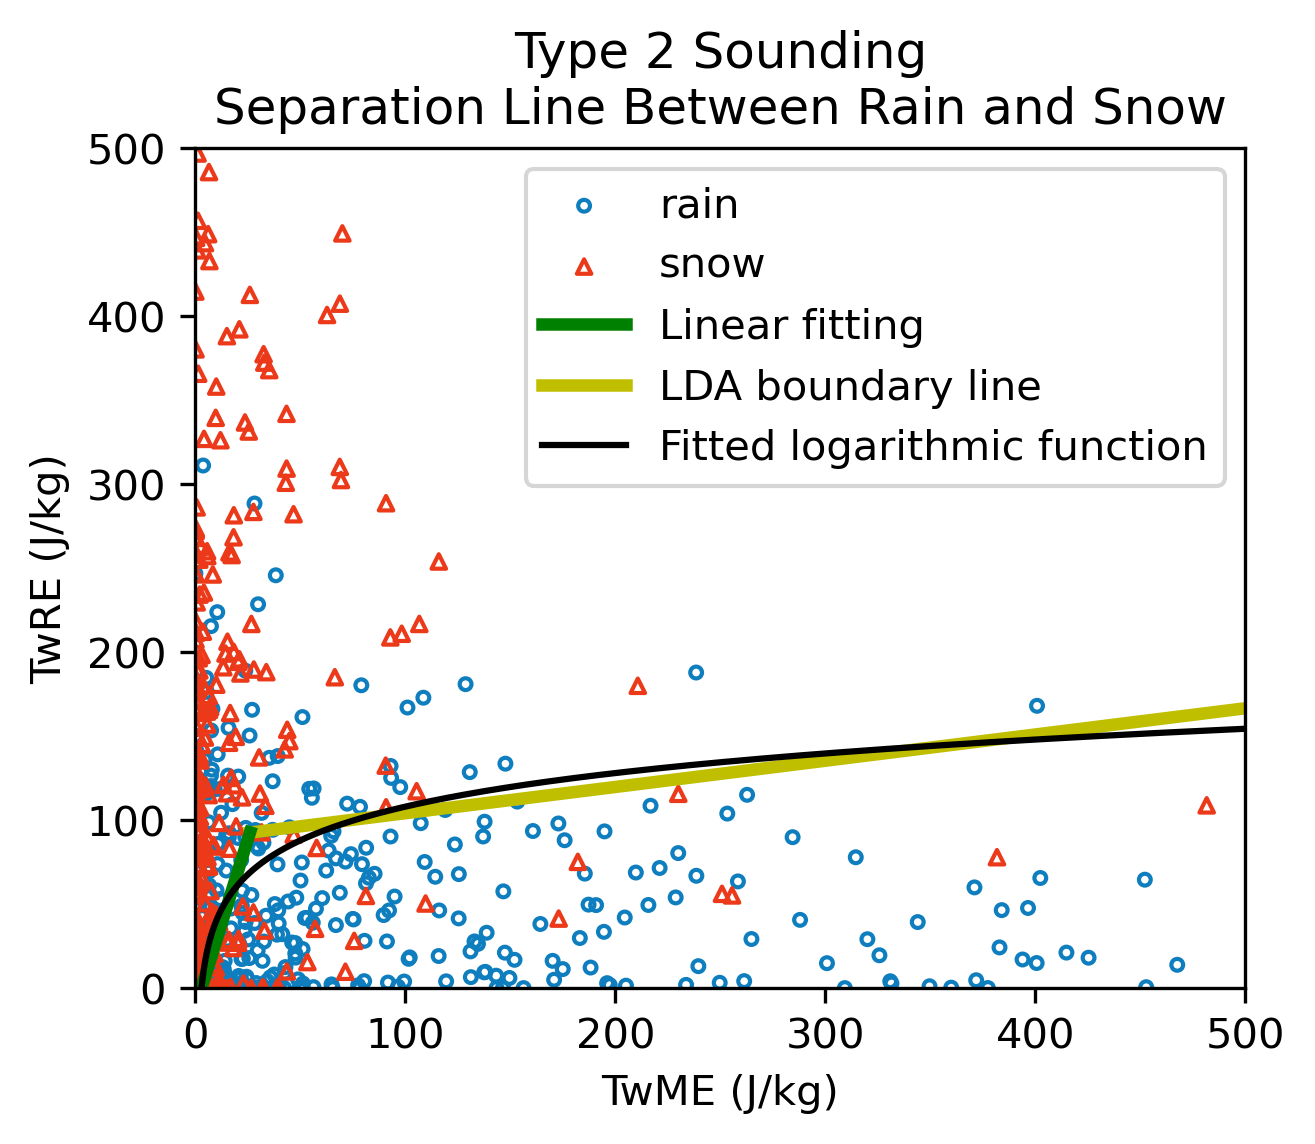

In [224]:
fig = plt.figure(figsize=(5, 4), dpi=300)
ax = fig.add_axes([0.15, 0.15, 0.7, 0.7])
s1 = ax.scatter(rain[PA], rain[NA], color=blue, marker='o', facecolor='none', s=8)
s2 = ax.scatter(snow[PA], snow[NA], color=red, marker='^',facecolor='none', s=12)

boundary=xmin1

xs = np.arange(boundary, 500+0.1, 0.1)
l1, = ax.plot(xs, (slope1*xs)+intercept1, 'y', linewidth=3) 

xs = np.arange(pa_intercept, boundary+0.1, 0.1)
l2, = ax.plot(xs, (slope2*xs)+intercept2, 'g', linewidth=3)

xs = np.arange(pa_intercept, 500, 0.1)
l3, = ax.plot(xs, lnfunc(xs, *lnco), 'k')

lg1 = ax.legend([s1, s2, l2, l1, l3],
                ['rain', 'snow',
                 'Linear fitting',
                 'LDA boundary line',
                 'Fitted logarithmic function']                 
                 )
               #   '%.2f * x - %.2f' % (slope2, abs(intercept2)),
               #   '%.2f * x + %.2f' % (slope1, intercept1),
               #   '%.2f + %.2f * ln( %.2f*x - %.2f)' % (lnco[0], lnco[1], lnco[2], abs(np.exp(-lnco[0]/lnco[1])-pa_intercept*lnco[2]))]
               # )

ax.set_xlim([0, 500])
ax.set_ylim([0, 500])
ax.set_xlabel('TwME (J/kg)')
ax.set_ylabel('TwRE (J/kg)')
ax.set_title('Type 2 Sounding\nSeparation Line Between Rain and Snow')
plt.savefig(figpath+'Figure6.eps', format='eps', bbox_inches='tight', dpi=300)
plt.savefig(figpath+'Figure6',  bbox_inches='tight', dpi=300)


In [265]:
sample = snow[(snow[NA]>lnfunc(snow[PA], *lnco)) & (snow.ww==79)]
sample[(sample[PA]<150) & (sample[NA]<150)]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


datetime    lat     lon    elev    t   td       p     slp  \
11176   1979-02-25 00:00:00  36.88  266.10   406.0 -1.0 -3.0   966.1  1019.4   
20555   1979-02-05 12:00:00  31.95  257.82   872.0 -2.0 -4.0   918.1  1019.0   
76846   1995-05-16 12:00:00  64.20  276.63    64.0 -3.6 -4.7  1003.2  1011.5   
82729   1983-12-04 00:00:00  40.67  270.32   202.0  1.1 -2.2   984.3  1008.8   
82751   1984-01-23 12:00:00  40.67  270.32   202.0 -2.2 -3.9   997.6  1022.6   
82753   1984-01-30 00:00:00  40.67  270.32   202.0 -2.2 -5.0   981.6  1006.5   
83272   1994-01-27 00:00:00  40.67  270.32   202.0 -2.8 -5.0   996.8  1021.8   
89669   1995-01-29 00:00:00  38.37  277.45   255.0 -0.6 -1.1   980.0  1010.9   
112274  1980-01-20 12:00:00  35.23  258.30  1099.0 -3.0 -5.0   900.1  1029.1   
138837  1980-12-27 00:00:00  46.77  259.25   506.0 -7.0 -8.0   955.6  1018.4   
139306  1986-11-19 12:00:00  46.77  259.25   506.0 -4.4 -6.1   937.7   999.3   
156421  1982-01-12 18:00:00  32.32  269.92   105.0 -1.7 -3.3  1006.5  1018.9   
156423  1982-01-14 00:00:00  32.32  269.92   105.0 -3.3 -4.4  1001.0  1013.3   

          ww    tw  ...  lowest_z_tw  IGRA_lon  IGRA_lat      IGRA_ID  \
11176   79.0 -1.77  ...        438.0  266.1000   36.8833  USM00072349   
20555   79.0 -2.77  ...        873.0  257.8108   31.9425  USM00072265   
76846   79.0 -3.98  ...         52.0  276.6333   64.2000  CAM00071915   
82729   79.0 -0.23  ...        200.0  270.3167   40.6667  USM00072532   
82751   79.0 -2.82  ...        200.0  270.3167   40.6667  USM00072532   
82753   79.0 -3.20  ...        200.0  270.3167   40.6667  USM00072532   
83272   79.0 -3.57  ...        202.0  270.3167   40.6667  USM00072532   
89669   79.0 -0.80  ...        246.0  277.4500   38.3667  USM00072425   
112274  79.0 -3.75  ...       1095.0  258.2908   35.2331  USM00072363   
138837  79.0 -7.31  ...        504.0  259.2406   46.7717  USM00072764   
139306  79.0 -4.99  ...        504.0  259.2406   46.7717  USM00072764   
156421  79.0 -2.29  ...         91.0  269.9200   32.3189  USM00072235   
156423  79.0 -3.69  ...         91.0  269.9200   32.3189  USM00072235   

        NCEP_ID     ID      PA_t      NA_t     PA_tw     NA_tw  
11176     72349  72349   36.7282  104.5124   18.6186  120.7817  
20555     72265  72265    4.7417   79.5311    4.7417   81.2856  
76846     71915  71915   10.3562  121.6277    4.5597  149.1648  
82729     72532  72532    0.8562   55.1303   17.0773  125.2017  
82751     72532  72532    9.9582   79.7259    8.6515   85.2689  
82753     72532  72532   17.6539   71.6984   16.1992   83.0277  
83272     72532  72532  126.3713  107.9778  105.3781  117.2408  
89669     72425  72425   11.5020   52.5285    2.8536   65.7890  
112274    72363  72363   46.8326   89.5346   46.8326   91.3853  
138837    72764  72764  182.0006  131.7913   90.6523  132.4779  
139306    72764  72764   89.8743  126.3519   42.5681  142.1384  
156421    72235  72235  111.8628   99.0102   90.8237  107.6706  
156423    72235  72235   52.3799  140.0905   44.7513  147.0453  

[13 rows x 46 columns]

In [70]:
sample = snow[(snow[PA]<100)& (snow[PA]>80) & (snow[NA]>250) & (snow[NA]<300)]
sample
'''
correct snow (large refreezing energy)
'72265'
'1982-11-25 00:00:00'
'''


"\ncorrect snow (large refreezing energy)\n'72265'\n'1982-11-25 00:00:00'\n"

In [71]:
print('[%s, %s]' % (sample.ID.values[0], sample.datetime.values[0]))

[72265, 1982-11-25 00:00:00]


In [130]:
# correct snow, small energy
sample = snow[(snow[PA]>0) & (snow[PA]<10) & (snow[NA]>60) & (snow[NA]<62)]
sample
sample.ID.astype(str).values[0], sample.datetime.astype(str).values[0]

('70231', '1995-10-08 12:00:00')

In [111]:
# correct rain,
sample = rain[(rain[PA]>80) & (rain[PA]<90) & (rain[NA]>20) & (rain[NA]<30) & (rain.ww==61)]
sample
sample.ID.astype(str).values[0], sample.datetime.astype(str).values[0]


('72425', '1983-01-22 00:00:00')

In [121]:
# wrong snow
sample = snow[(snow[PA]>70) & (snow[PA]<80) & (snow[NA]>0) & (snow[NA]<10)]
sample
sample.ID.astype(str).values[0], sample.datetime.astype(str).values[0]

('71867', '2004-04-27 12:00:00')

In [123]:
# wrong rain freezing rain
sample = rain[(rain[PA]>20) & (rain[PA]<50) & (rain[NA]>100) & (rain[NA]<150) & (rain.ww==66)]
sample
sample.ID.astype(str).values[0], sample.datetime.astype(str).values[0]

('72265', '1980-02-01 00:00:00')

In [129]:
# wrong rain  freezing rain 
sample = rain[(rain[NA]>lnfunc(rain[PA], *lnco)) & (rain.ww==66)]
sample.loc[120768]
# sample.ID.astype(str).values[0], sample.datetime.astype(str).values[0]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


datetime             1988-01-15 12:00:00
lat                                 32.9
lon                               279.97
elev                                15.0
t                                   -2.8
td                                  -3.9
p                                 1028.4
slp                               1030.4
ww                                  66.0
tw                                 -3.19
wwflag                               1.0
posi_area1_t                      32.752
posi_area2_t                         NaN
posi_area3_t                         NaN
nega_area1_t                   -108.7919
nega_area2_t                         NaN
nega_area3_t                         NaN
freezing_level1_t                 1684.0
freezing_level2_t                    NaN
freezing_level3_t                    NaN
lapse_rate_t                      6.8584
posi_area1                       20.4386
posi_area2                           NaN
posi_area3                           NaN
nega_area1      

(array([  6., 176.,   3.,   6.,   6.,   2.,  71.,   3.,   4.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  31.,   2.,
          0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,
          0.,   0.,  18.,   0.,   0.,   0.]),
 array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
        77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
        94, 95, 96, 97, 98, 99]),
 <BarContainer object of 39 artists>)

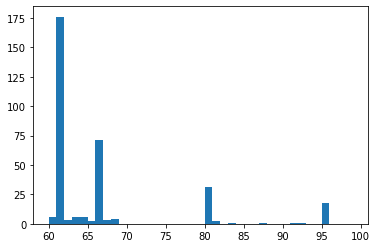

In [149]:
# correct rain, miex
sample = rain[(rain[NA]<lnfunc(rain[PA], *lnco))]
plt.hist(sample.ww, np.arange(60, 100, 1))
# sample.ID.astype(str).values[0], sample.datetime.astype(str).values[0]

In [154]:
sample = rain[(rain[NA]<lnfunc(rain[PA], *lnco)) & (rain.ww==83)]
sample


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


datetime    lat     lon    elev    t   td      p     slp  \
175135  1984-12-11 12:00:00  39.12  251.47  1475.0  1.1 -3.3  845.7  1010.5   

          ww    tw  ...  lowest_z_tw  IGRA_lon  IGRA_lat      IGRA_ID  \
175135  83.0 -0.77  ...       1472.0   251.475     39.12  USM00072476   

        NCEP_ID     ID    PA_t    NA_t   PA_tw   NA_tw  
175135    72476  72476  8.2342  0.4977  4.6305  4.2183  

[1 rows x 46 columns]

In [ ]:
def classify_two_layers(test):
    '''
    Separation for soundings with a melting layer and a refreezing layer
    '''
    params = [-41.15, 28.71, 1.82]
    pa_intercept = 2.94
    
    PA = 'posi_area1'
    NA = 'nega_area1'
​
    pre_snow0 = test[test[PA] <= pa_intercept]
    
    test1 = test[test[PA] > pa_intercept]
    pre_rain = test1[test1[NA] < type2_ln(test1[PA], *params)]
    pre_snow1 = test1[test1[NA] >= type2_ln(test1[PA], *params)]
    pre_snow = pd.concat([pre_snow0, pre_snow1])
    
    return pre_rain.wwflag, pre_snow.wwflag

In [53]:
type2_ev = pd.read_csv(datapath + 'type2_tw_ev.txt')

test = type2_ev[~type2_ev.t.isna() & 
                ~type2_ev.td.isna() & 
                ~type2_ev.p.isna() & 
                ~type2_ev.lapse_rate_t.isna() &
                ~type2_ev.lapse_rate_tw.isna()]

pre_rain, pre_snow =  classify_two_layers(test)
accuracy_test, recall_test, precision_test, f1score_test = metrics(pre_rain, pre_snow)

In [54]:
print(accuracy_test, recall_test, precision_test, f1score_test)

0.714371617558629 0.43319268635724334 0.8105263157894737 0.28230980751604035


# Supplementary Figure 2

In [306]:
xmin1 = 26
slope1, intercept1 = fit_LDA_for_greater_than(type2_tw_de, xmin1)

# find the best x intercept when must crossing (xmin1, f(xmin1) on LDA line)
pa_intercept, aa, bb, cc, dd = find_x_intercept(type2_tw_de, xmin1, slope1, intercept1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


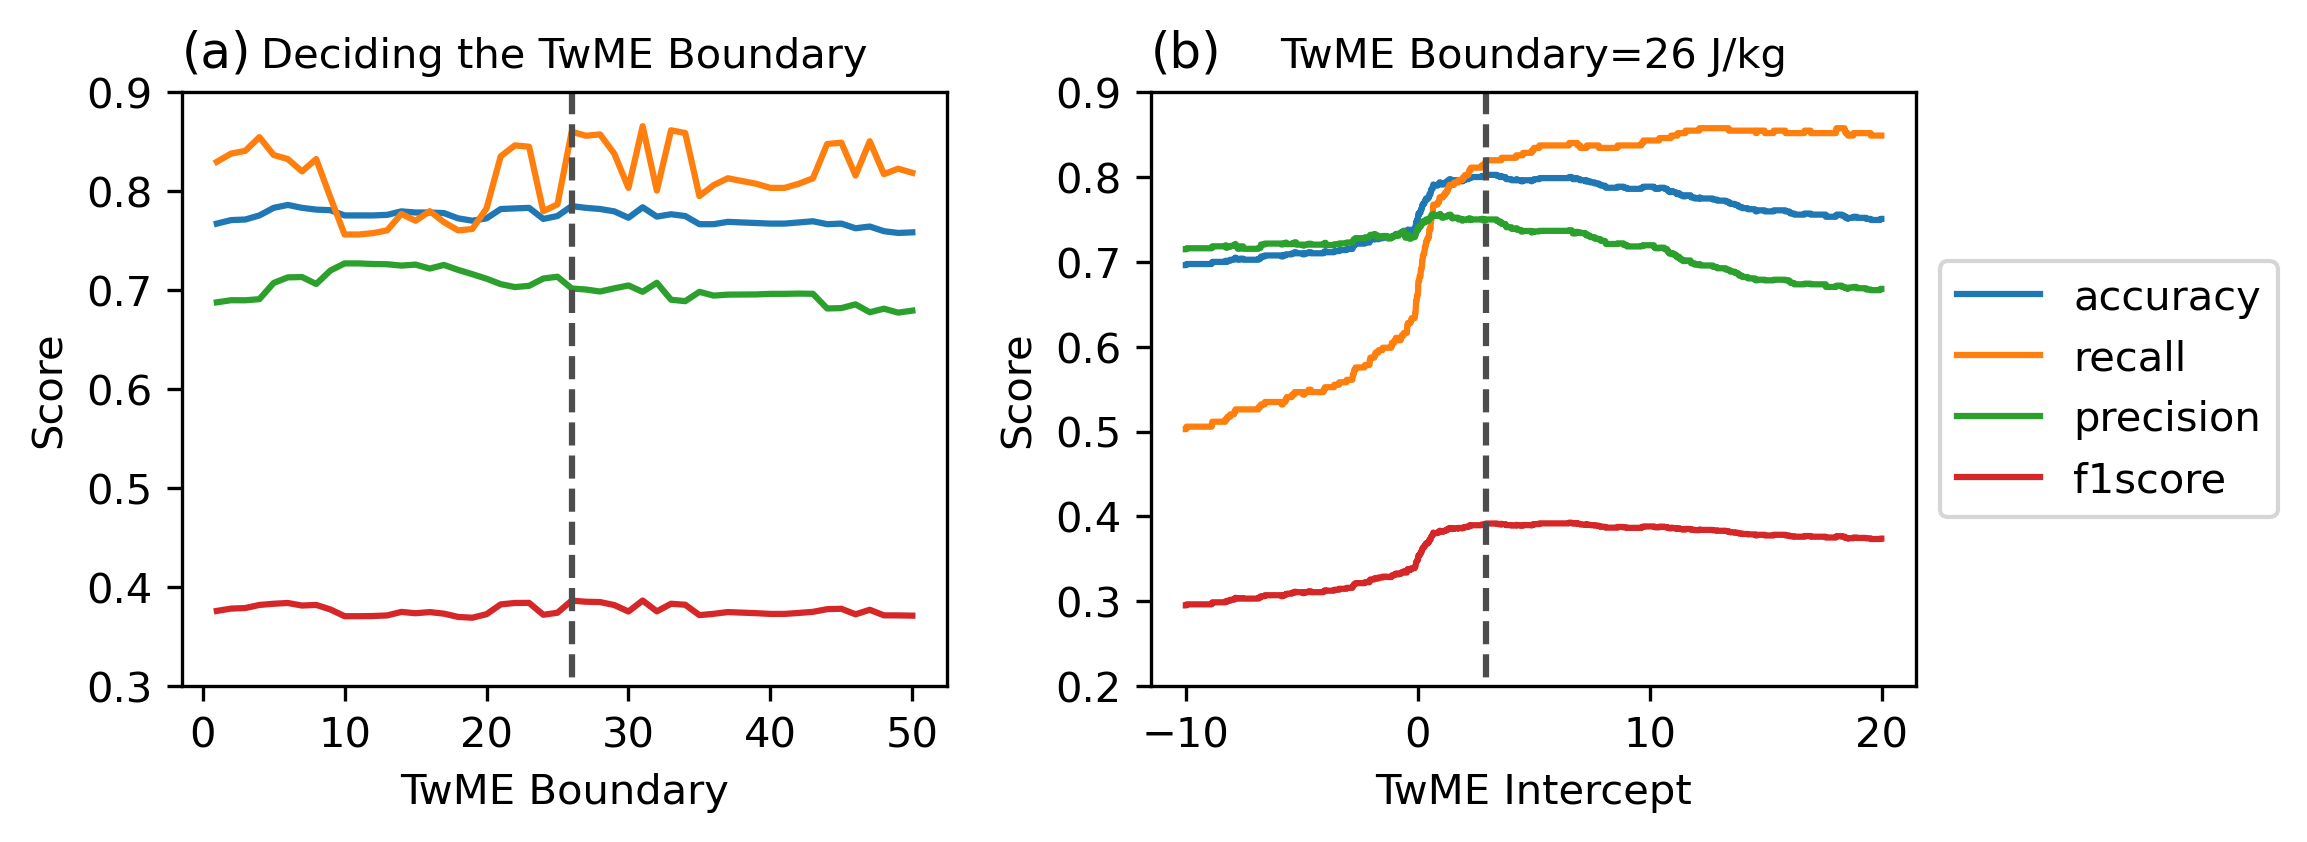

In [310]:
fig = plt.figure(figsize=(8.5, 6), dpi=300)
ax1 = fig.add_axes([0.1, 0.1, 0.3, 0.33])
ax2 = fig.add_axes([0.48, 0.1, 0.3, 0.33])

xs = np.arange(1, 51, 1)
ax1.plot(xs, df_turning.accuracy)
ax1.plot(xs, df_turning.recall)
ax1.plot(xs, df_turning.precision)
ax1.plot(xs, df_turning.f1score)
# idx = np.argmax(df_turning.sum(axis=1))
ax1.plot([xmin1, xmin1], [0, 1], '--', color='0.3')
ax1.set_ylim([0.3, 0.9])
ax1.set_title('Deciding the TwME Boundary', fontsize=10)
ax1.set_xlabel('TwME Boundary')
ax1.set_ylabel('Score')

xs = np.arange(-10, 20, 0.01)
idx = np.argmax(aa+dd)
ax2.plot(xs, aa)
ax2.plot(xs, bb)
ax2.plot(xs, cc)
ax2.plot(xs, dd)
ax2.plot([xs[idx], xs[idx]], [0, 1], '--', color='0.3')
ax2.set_ylim(0.2, 0.9)
ax2.legend(['accuracy', 'recall', 'precision', 'f1score'], loc='center right', bbox_to_anchor=(1.5, 0.5))
ax2.set_title('TwME Boundary=26 J/kg', fontsize=10)
ax2.set_xlabel('TwME Intercept')
ax2.set_ylabel('Score')

# ax1.text(-0.07, 1.04, '(a)', transform=ax1.transAxes, fontsize=12)
# ax2.text(-0.07, 1.04, '(b)', transform=ax2.transAxes, fontsize=12)
ax1.set_title('(a)', loc='left', fontsize=12)
ax2.set_title('(b)', loc='left', fontsize=12)
plt.savefig(figpath+'find_pa_intercept',bbox_inches='tight', dpi=300)
plt.savefig(figpath+'find_pa_intercept.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 7 Typical Soundings

In [69]:
type2_tw_de = pd.read_csv(datapath+'type2_tw_de.txt', index_col=0)
type2_tw_ev = pd.read_csv(datapath+'type2_tw_ev.txt', index_col=0)
type2_tw_de.nega_area1 = -type2_tw_de.nega_area1
type2_tw_ev.nega_area1 = -type2_tw_ev.nega_area1
rain = type2_tw_de[type2_tw_de.wwflag==1]
snow = type2_tw_de[type2_tw_de.wwflag==2]

# ['4.02 * x - 11.80', '0.16 * x + 88.53', '-41.15 + 28.71 * ln( 1.82*x - 1.15)']
def lnfunc(x, a, b, c):
    return a+b*np.log(c*x+ np.exp(-a/b)-pa_intercept*c) # should cross (pa_intercept, 0)
slope1, intercept1 = 0.16, 88.53
slope2, intercept2 = 4.02, -11.8
lnco = np.array([-41.15, 28.71, 1.82])
pa_intercept = 2.94

In [11]:
df1 = pd.read_csv(datapath+'sounding/'+'72425_USM00072425_19830122000000.txt')
df2 = pd.read_csv(datapath+'sounding/'+'70231_USM00070231_19951008120000.txt')
# df3 = pd.read_csv(datapath+'sounding/'+'72265_USM00072265_19821125000000.txt')
df3 = pd.read_csv(datapath+'sounding/'+'72235_USM00072235_19820112180000.txt')
df4 = pd.read_csv(datapath+'sounding/'+'71867_CAM00071867_20040427120000.txt')
df5 = pd.read_csv(datapath+'sounding/'+'72208_USM00072208_19880115120000.txt')
df6 = pd.read_csv(datapath+'sounding/'+'72655_USM00072655_19790306120000.txt')

df7 = pd.read_csv(datapath+'sounding/'+'72476_USM00072476_19841211120000.txt')

In [269]:
df3

p    t        tw      z
0   1009.1 -1.7 -2.322504   91.0
1   1000.0 -2.9 -3.390870  163.0
2    959.0 -5.3 -5.522199  494.0
3    932.0 -3.5 -3.698564  719.0
4    922.0 -0.9 -1.126467  805.0
..     ...  ...       ...    ...
58     NaN  NaN       NaN    NaN
59     NaN  NaN       NaN    NaN
60     NaN  NaN       NaN    NaN
61     NaN  NaN       NaN    NaN
62     NaN  NaN       NaN    NaN

[63 rows x 4 columns]

In [18]:
snow_ids = ['70231', '72235', '71867']
rain_ids = ['72425', '72208', '72655', '72476']
snow_times = ['1995-10-08 12:00:00', 
              '1982-01-12 18:00:00', 
              '2004-04-27 12:00:00',]
rain_times = ['1983-01-22 00:00:00', '1988-01-15 12:00:00', 
         '1979-03-06 12:00:00', '1984-12-11 12:00:00']
snow_me = [type2_tw_de.loc[(type2_tw_de.ID==ID) & (type2_tw_de.datetime==time), 
                           'posi_area1'].values[0] for ID, time in zip(snow_ids, snow_times)]
snow_re = [type2_tw_de.loc[(type2_tw_de.ID==ID) & (type2_tw_de.datetime==time), 
                           'nega_area1'].values[0] for ID, time in zip(snow_ids, snow_times)]
rain_me = [type2_tw_de.loc[(type2_tw_de.ID==ID) & (type2_tw_de.datetime==time), 
                           'posi_area1'].values[0] for ID, time in zip(rain_ids, rain_times)]
rain_re = [type2_tw_de.loc[(type2_tw_de.ID==ID) & (type2_tw_de.datetime==time), 
                           'nega_area1'].values[0] for ID, time in zip(rain_ids, rain_times)]

In [ ]:
'''
0327 lefted:
mark snow and rain with ligher colors
mark numbers or alphabets on the plot
lable a-h
write area values on the plot?
'''


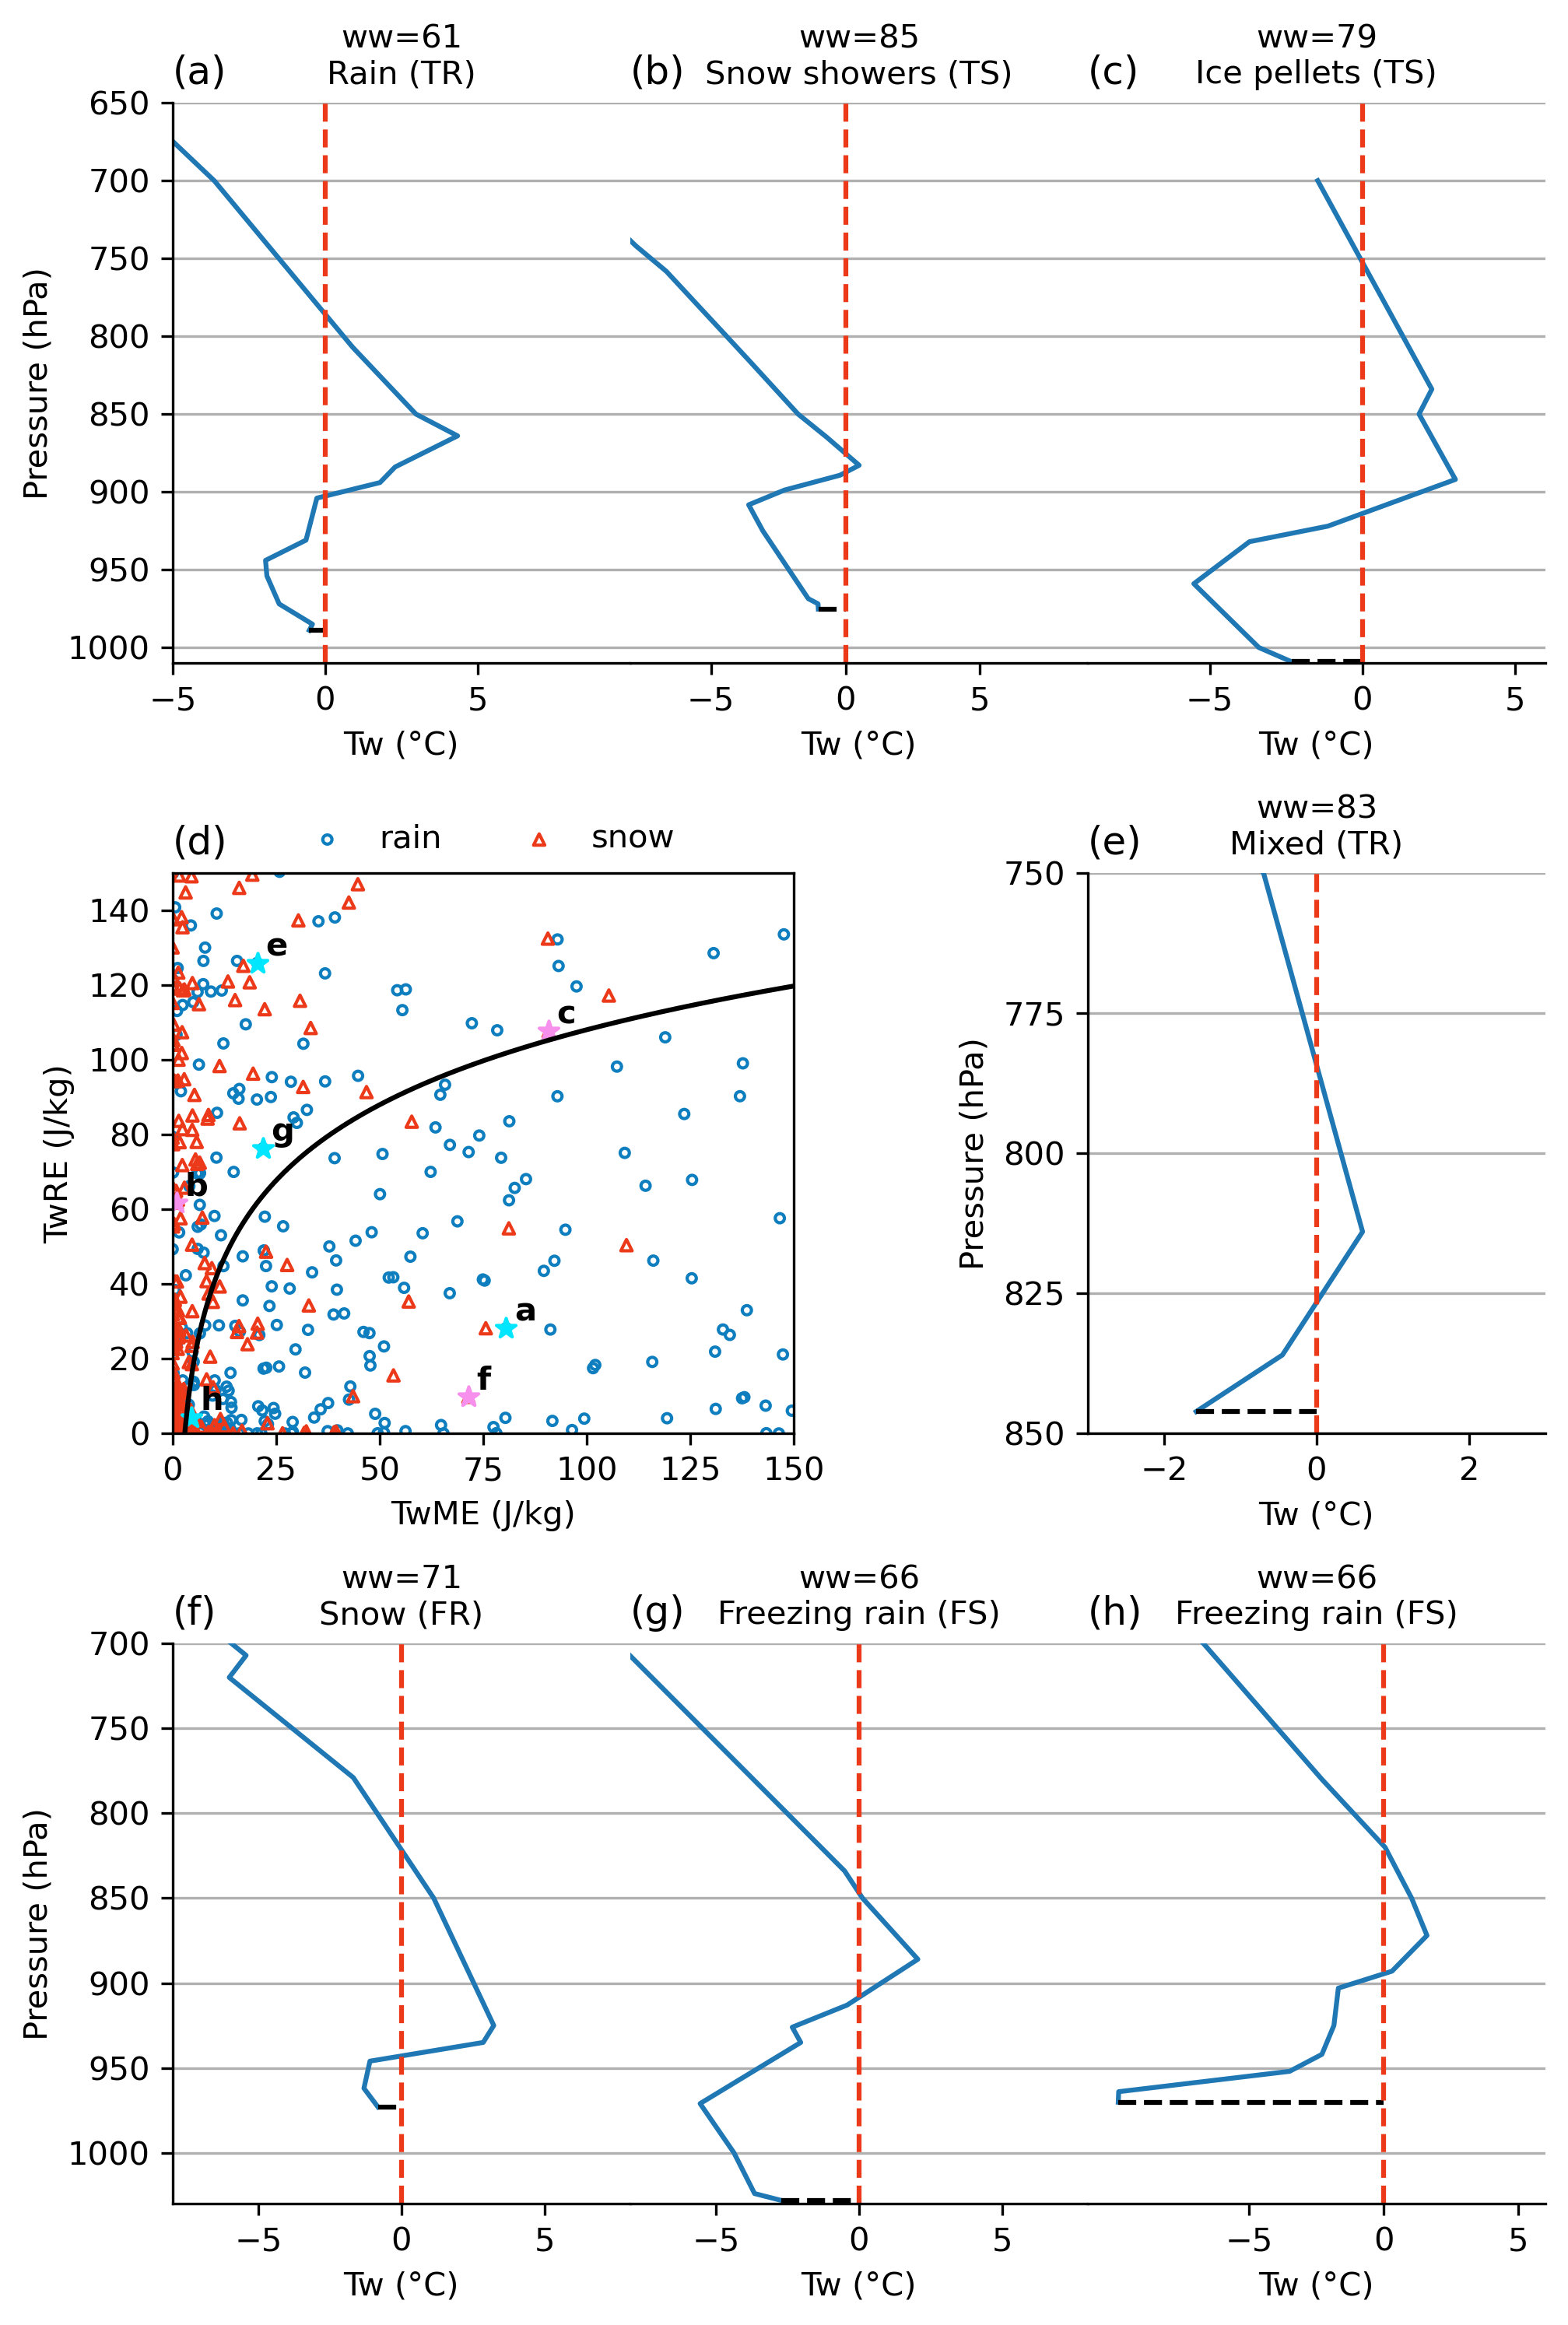

In [70]:
PA, NA ='posi_area1', 'nega_area1'

fig = plt.figure(figsize=(7, 10), dpi=300)
ax0  = fig.add_axes([0.10, 0.38, 0.38, 0.24])

ax7 = fig.add_axes([0.66, 0.38, 0.28, 0.24])

ax1 = fig.add_axes([0.10, 0.71, 0.28, 0.24])
ax2 = fig.add_axes([0.38, 0.71, 0.28, 0.24])
ax3 = fig.add_axes([0.66, 0.71, 0.28, 0.24])

ax4 = fig.add_axes([0.10, 0.05, 0.28, 0.24])
ax5 = fig.add_axes([0.38, 0.05, 0.28, 0.24])
ax6 = fig.add_axes([0.66, 0.05, 0.28, 0.24])


axes = [ax1, ax2, ax3, ax0, ax7, ax4, ax5, ax6]
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for ax, label in zip(axes, labels):
    ax.set_title('('+label+')', loc='left')

# plot the soundings
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
dfs = [df1, df2, df3, df4, df5, df6, df7]
wws = ['61\nRain (TR)', '85\nSnow showers (TS)', '79\nIce pellets (TS)', '71\nSnow (FR)', '66\nFreezing rain (FS)','66\nFreezing rain (FS)', '83\nMixed (TR)']
for ax, df, ww in zip(axes, dfs, wws):
    ax.plot(df.tw, -df.p)
    ax.plot([df.tw[0], 0], [-df.p[0], -df.p[0]],  '--', color='k')
    ax.set_title('ww='+ww, fontsize=10)
    ax.set_xlabel('Tw ('+chr(176)+'C)')

# 1-3
ax1.set_xlim(-5, 10)
ax2.set_xlim(-8, 9)
ax3.set_xlim(-9, 6)
# set yaxis
for ax in [ax1, ax2, ax3]:
    ax.set_xticks([-5, 0, 5])
    
    ax.plot([0, 0], [-1010, -650], '--', color=red)
    
    ax.set_ylim([-1010, -650])
    ax.set_yticks(np.arange(-1000, -600, 50))
    ax.set_yticklabels(-np.arange(-1000, -600, 50))

# 4-6
ax4.set_xlim(-8, 8)
ax5.set_xlim(-8, 8)
ax6.set_xlim(-11, 6)
for ax in [ax4, ax5, ax6]:
    ax.set_xticks([-5, 0, 5])
    
    ax.plot([0, 0], [-1030, -700], '--', color=red)
    
    ax.set_ylim([-1030, -700])
    ax.set_yticks(np.arange(-1000, -650, 50))
    ax.set_yticklabels(-np.arange(-1000, -650, 50))
    
# 7
ax7.plot([0, 0], [-850, -750], '--', color=red)
ax7.set_ylim([-850, -750])
ax7.set_yticks(np.arange(-850, -750+25, 25))
ax7.set_yticklabels(-np.arange(-850, -750+25, 25))
ax7.set_xlim(-3, 3)


# ------------------------------frame and grid settings
def remove_frame(ax2):
    '''remove left, top, right boundaries'''
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    return   
for ax in axes:
    remove_frame(ax)
for ax in [ax1, ax4, ax7]:
    ax.spines['left'].set_visible(True)
    ax.grid(axis='y')
    ax.set_ylabel('Pressure (hPa)')

def clean_y_axis(ax2):
    '''remove y axis labels and ticks, but keep y grids same as the leftmost plot'''
    ax2.grid(axis='y')
    ax2.yaxis.set_ticklabels([])
    for tick in ax2.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
    return
for ax in [ax2, ax3, ax5, ax6]:
    clean_y_axis(ax)


    
# -------------------scatter plot
s1 = ax0.scatter(rain[PA], rain[NA], color=blue, marker='o', facecolor='none', s=8)
s2 = ax0.scatter(snow[PA], snow[NA], color=red, marker='^',facecolor='none', s=12)


# boundary=xmin1

# xs = np.arange(boundary, 500+0.1, 0.1)
# l1, = ax0.plot(xs, (slope1*xs)+intercept1, 'y', linewidth=3) 

# xs = np.arange(pa_intercept, boundary+0.1, 0.1)
# l2, = ax0.plot(xs, (slope2*xs)+intercept2, 'g', linewidth=3)

xs = np.arange(pa_intercept, 500, 0.1)
l3, = ax0.plot(xs, lnfunc(xs, *lnco), 'k')


pink = np.array((247, 144, 236))/255
s3 = ax0.scatter(snow_me, snow_re, color=pink, marker='*', s=40)
labels = ['b', 'c', 'f']
for me, re, label in zip(snow_me, snow_re, labels):
    ax0.text(me+2, re+2, label, fontweight='bold')

cyan = np.array((0, 230, 255))/255
s3 = ax0.scatter(rain_me, rain_re, color=cyan, marker='*', s=40)
labels = ['a', 'e', 'g', 'h']
for me, re, label in zip(rain_me, rain_re, labels):
    ax0.text(me+2, re+2, label, fontweight='bold')

lg1 = ax0.legend([s1, s2],
                ['rain', 'snow'],
                 frameon=False, ncol=2, bbox_to_anchor=[0.15,1.14], handletextpad=0.6
                 )
ax0.set_xlim([0, 150])
ax0.set_ylim([0, 150])
ax0.set_xlabel('TwME (J/kg)')
ax0.set_ylabel('TwRE (J/kg)')


fig.savefig(figpath+'Figure7', bbox_inches='tight', dpi=300)
fig.savefig(figpath+'Figure7.eps', format='eps', bbox_inches='tight')

In [230]:
type2_tw_de = pd.read_csv(datapath+'type2_tw_de.txt', index_col=0)
type2_tw_de.nega_area1 = -type2_tw_de.nega_area1
cat = type2_tw_de
df_rain = cat[cat.wwflag==1]
df_snow = cat[cat.wwflag==2]

# freezing rain
df_fr = cat[(cat.ww==66) | (cat.ww==67)]
df_rain.drop(df_fr.index, inplace=True)

# ice pellets
df_pl = cat[cat.ww==79]
df_snow.drop(df_pl.index, inplace=True)

(array([52., 41., 23.,  8.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([  0.6131 ,  51.01724, 101.42138, 151.82552, 202.22966, 252.6338 ,
        303.03794, 353.44208, 403.84622, 454.25036, 504.6545 ]),
 <BarContainer object of 10 artists>)

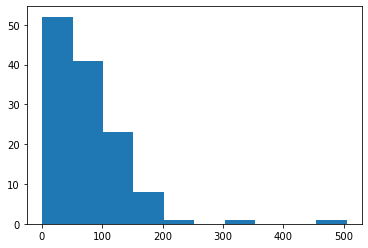

In [231]:
plt.hist(df_fr[NA])

In [232]:
df_fr[(df_fr[PA]<100) & (df_fr[NA]>200)]

datetime    lat     lon   elev    t    td          p  \
51401   1989-12-22 12:00:00  30.13  266.78    5.0 -6.1 -15.0  1034.2000   
130283  2003-11-24 12:00:00  53.76  286.32  306.0 -5.0  -6.0   968.9004   
141765  1978-11-15 00:00:00  37.77  260.03  790.0 -3.0  -4.0   931.7000   

           slp    ww    tw  ...  lowest_z_tw  IGRA_lon  IGRA_lat      IGRA_ID  \
51401   1035.4  66.0 -8.23  ...          5.0  266.7839   30.1253  USM00072240   
130283  1007.4  66.0 -5.34  ...        306.0  286.3208   53.7572  CAM00071823   
141765  1026.0  66.0 -3.38  ...        791.0  260.0314   37.7614  USM00072451   

        NCEP_ID     ID     PA_t      NA_t    PA_tw     NA_tw  
51401     72240  72240  86.0516  411.4202  52.9405  504.6545  
130283    71823  71823   4.2373  296.4810   3.6931  311.1044  
141765    72451  72451  38.6839  185.3784  38.3171  245.7617  

[3 rows x 46 columns]

# Figure 8 precip types and mis snow ww codes

In [252]:
type2_tw_de = pd.read_csv(datapath+'type2_tw_de.txt', index_col=0)
type2_tw_de.nega_area1 = -type2_tw_de.nega_area1

cat = type2_tw_de
df_rain = cat[cat.wwflag==1]
df_snow = cat[cat.wwflag==2]

# freezing rain
df_fr = cat[(cat.ww==66) | (cat.ww==67)]
df_rain.drop(df_fr.index, inplace=True)

# ice pellets
df_pl = cat[cat.ww==79]
df_snow.drop(df_pl.index, inplace=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


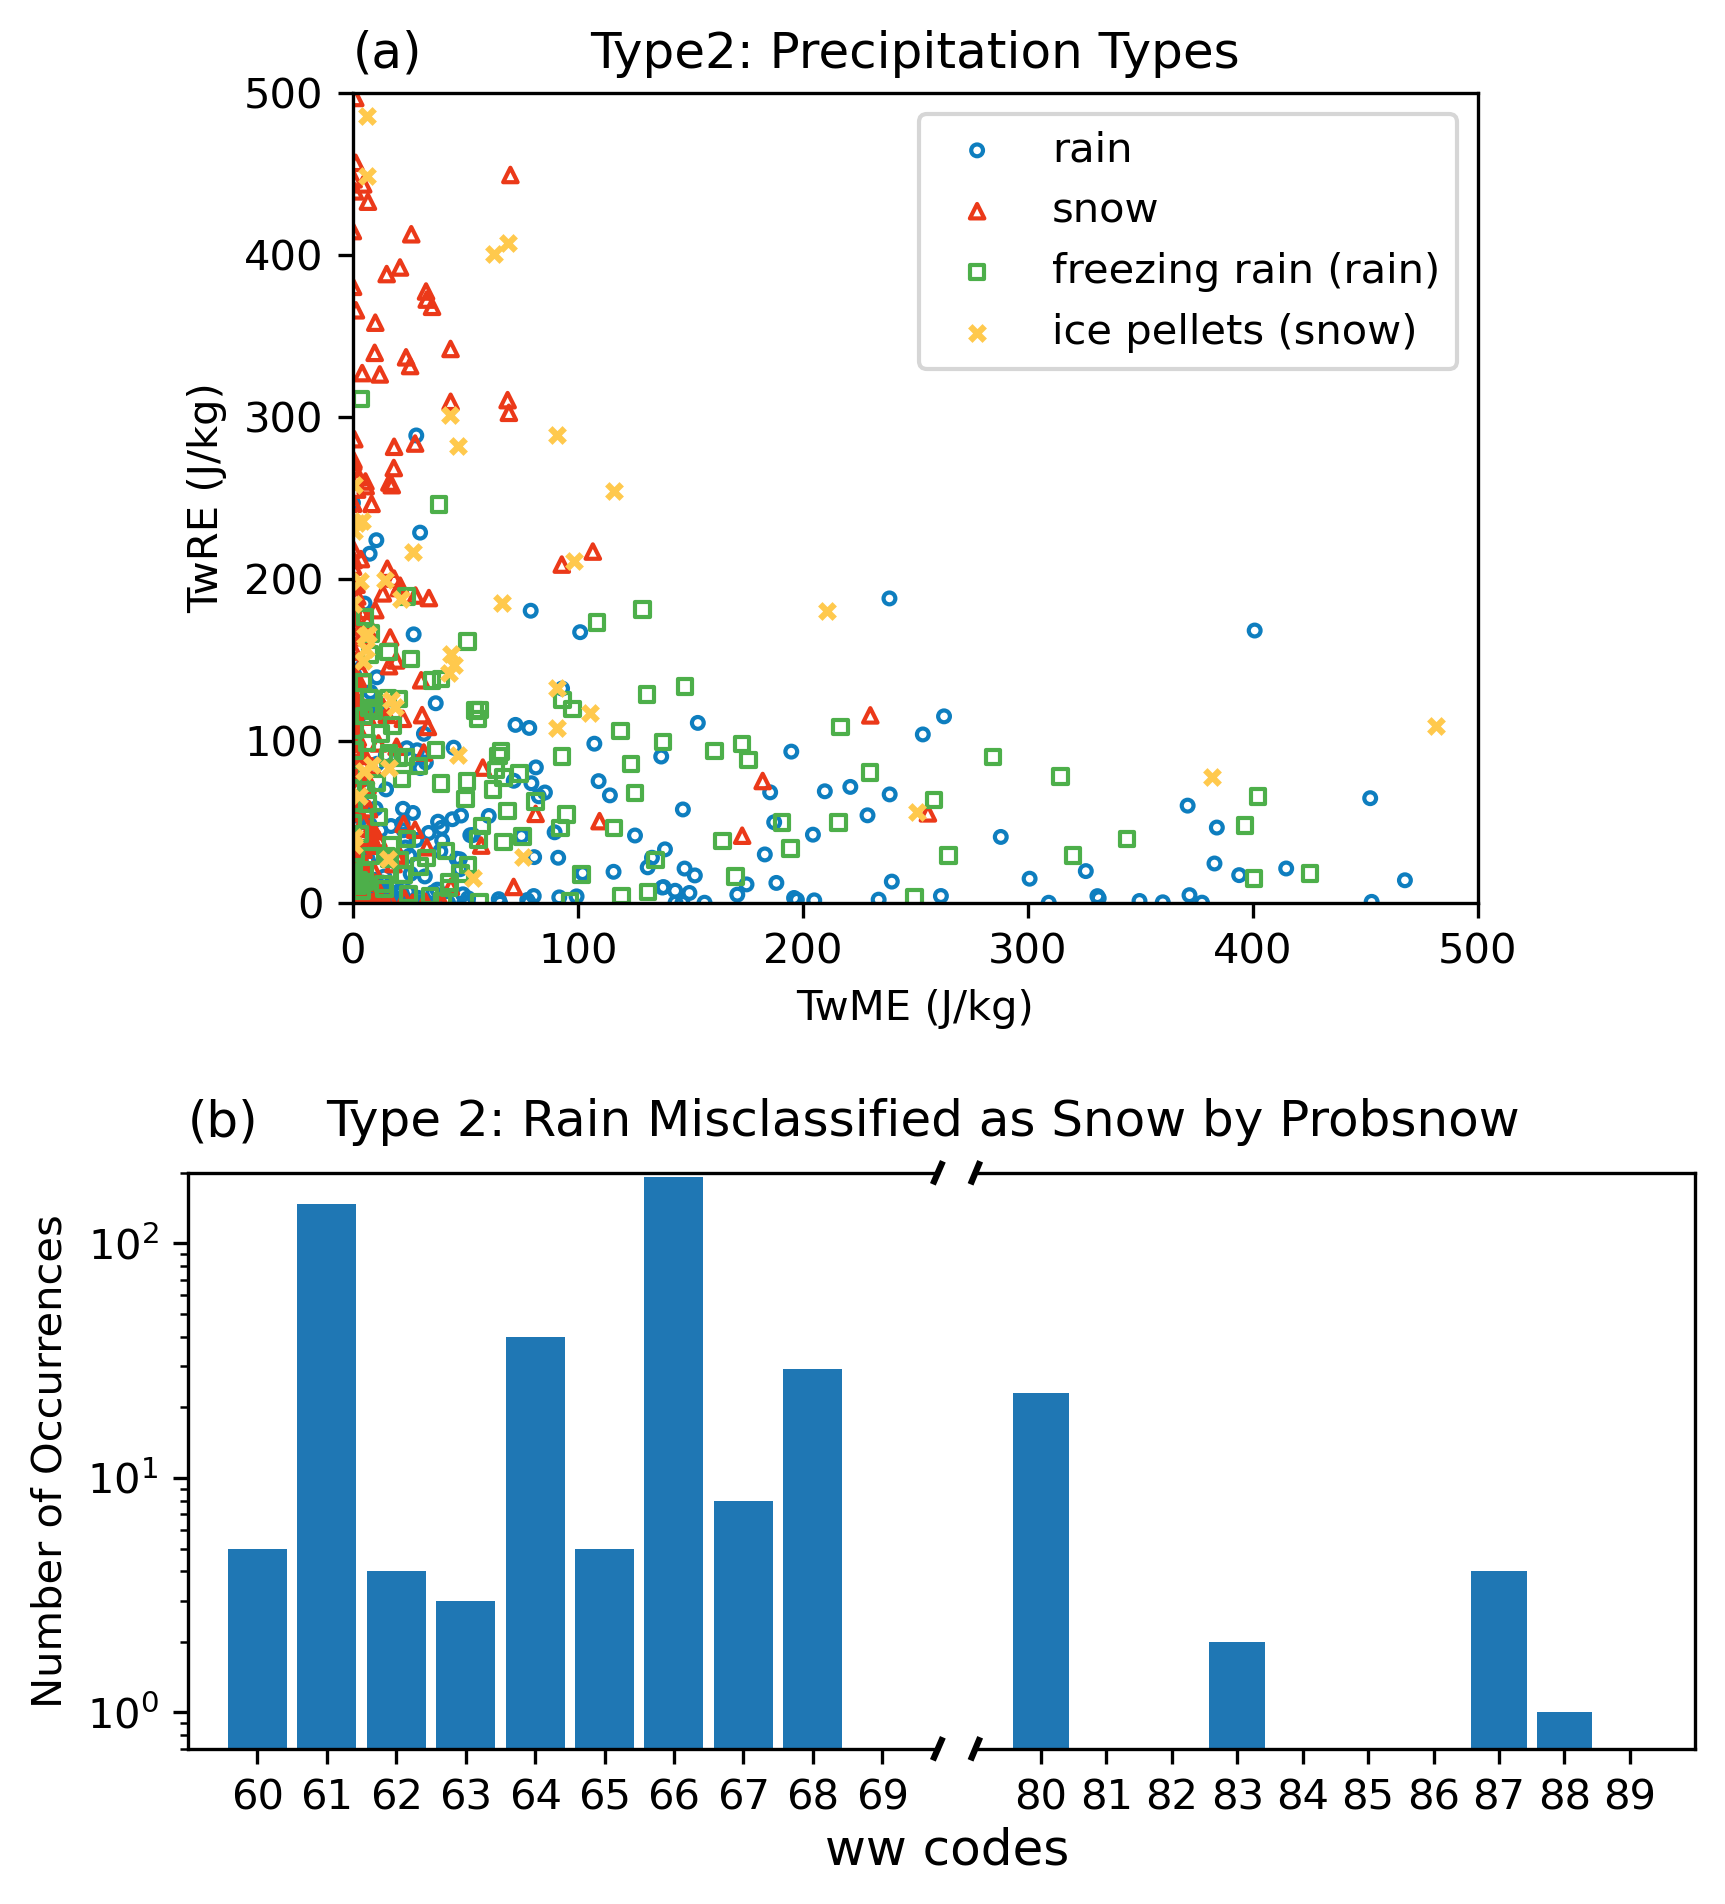

In [292]:
fig = plt.figure(figsize=(5, 6), dpi=300)
ax = fig.add_axes([0.16, 0.52, 0.75, 0.45])

PA = 'posi_area1'
NA = 'nega_area1'
ax.scatter(df_rain[PA], df_rain[NA], color=blue, marker='o', facecolor='none', s=8)
ax.scatter(df_snow[PA], df_snow[NA], color=red, marker='^', facecolor='none', s=12)
ax.scatter(df_fr[PA], df_fr[NA], color =green, marker='s', facecolor='none', s=12)
ax.scatter(df_pl[PA], df_pl[NA], color=yellow, marker='x', s=12)
ax.set_xlim([0, 500])
ax.set_ylim([0, 500])
ax.set_xlabel('TwME (J/kg)')
ax.set_ylabel('TwRE (J/kg)')
ax.legend(['rain', 'snow', 'freezing rain (rain)', 'ice pellets (snow)'])
ax.set_title('Type2: Precipitation Types')
ax.set_title('(a)', loc='left',  fontsize=12)
#----------------------------------------
missnow = pd.read_csv(datapath + 'probsnow_missnow.txt', index_col=0)

bins1 = np.arange(60, 70)
bins2 = np.arange(80, 90)

ax1 = fig.add_axes([0.05, 0.05, 0.5, 0.32])
ax2 = fig.add_axes([0.575, 0.05, 0.48, 0.32])

ax1.hist(missnow.ww, bins1, align='left',rwidth=0.85)
ax2.hist(missnow.ww, bins2, align='left',rwidth=0.85)


ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.tick_params(left=False, labelleft=False) 


ax1.set_xticks(bins1)
ax2.set_xticks(bins2)
ax1.set_xlim([59, 69.8])
ax2.set_xlim([79, 90])
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_ylim([0.7, 200])
ax2.set_ylim([0.7, 200])
ax2.minorticks_off()



d = .015  # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((0.98+d,1.02-d), (0-d, 0+d), **kwargs)        # bottom-left diagonal
ax1.plot((0.98+d,1.02-d), (1-d, 1+d), **kwargs)        # top-left diagonal
kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-0.02+d,0.02-d), (0-d, 0+d), **kwargs)        # bottom-right diagonal
ax2.plot((-0.02+d,0.02-d), (1-d, 1+d), **kwargs)        # top-right diagonal

ax1.text(0.85,-0.2,'ww codes', fontsize=12,transform=ax1.transAxes)
ax1.xaxis.set_label_coords(0.8, -.1)
ax1.set_ylabel('Number of Occurrences', fontsize=10)
ax1.set_title('Type 2: Rain Misclassified as Snow by Probsnow', x = 0.98, y=1.02)
ax1.set_title('(b)', loc='left',  fontsize=12, y=1.02)

fig.savefig(figpath+'Figure8', dpi=300, bbox_inches='tight')
fig.savefig(figpath+'Figure8.eps', format='eps', bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


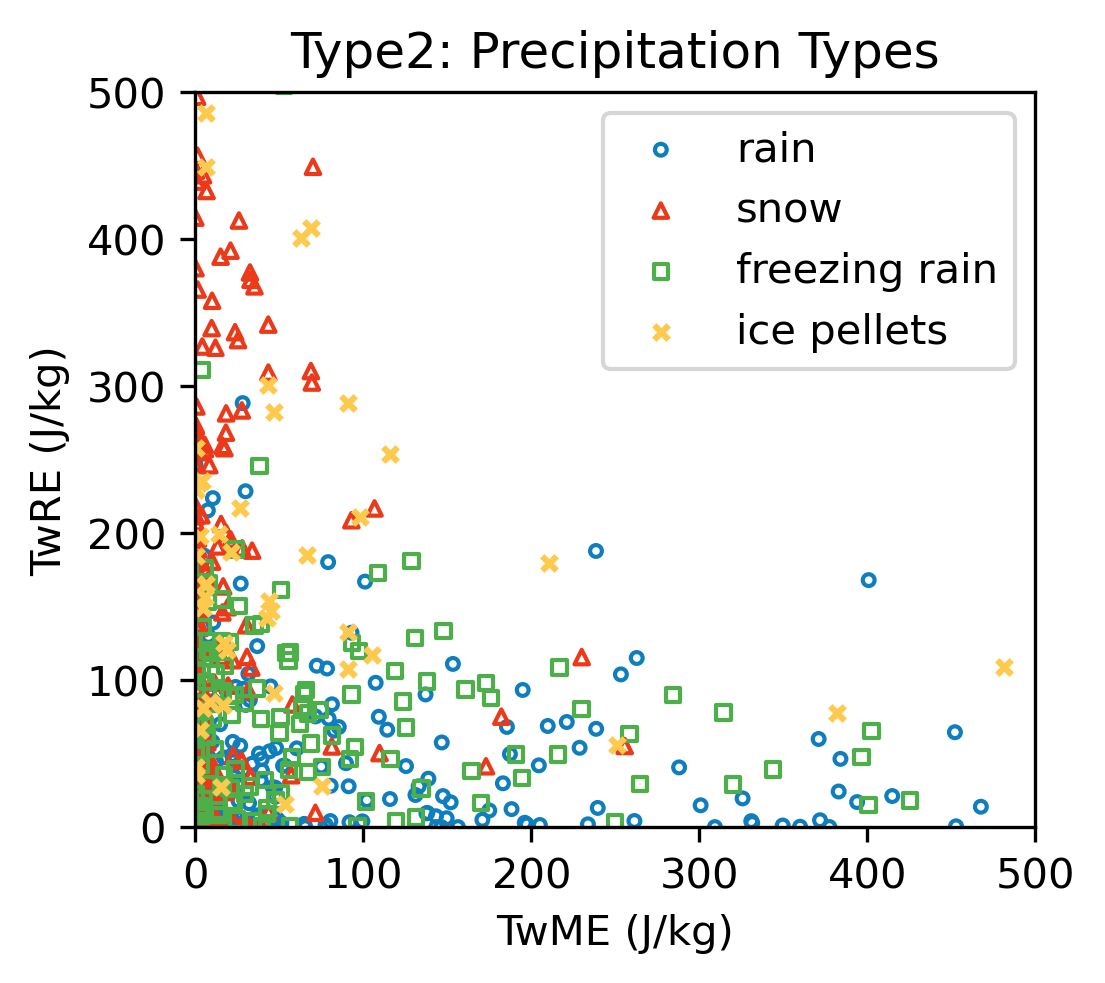

In [220]:

                                                          

fig.savefig(figpath+'type2_precip_types', dpi=300, bbox_inches='tight')
fig.savefig(figpath+'type2_precip_types.eps', format='eps', dpi=300, bbox_inches='tight')

# Figure 8: Hist false snow by probsnow

Text(0.78, 1.02, 'Type 2: Rain Misclassified as Snow by Probsnow')

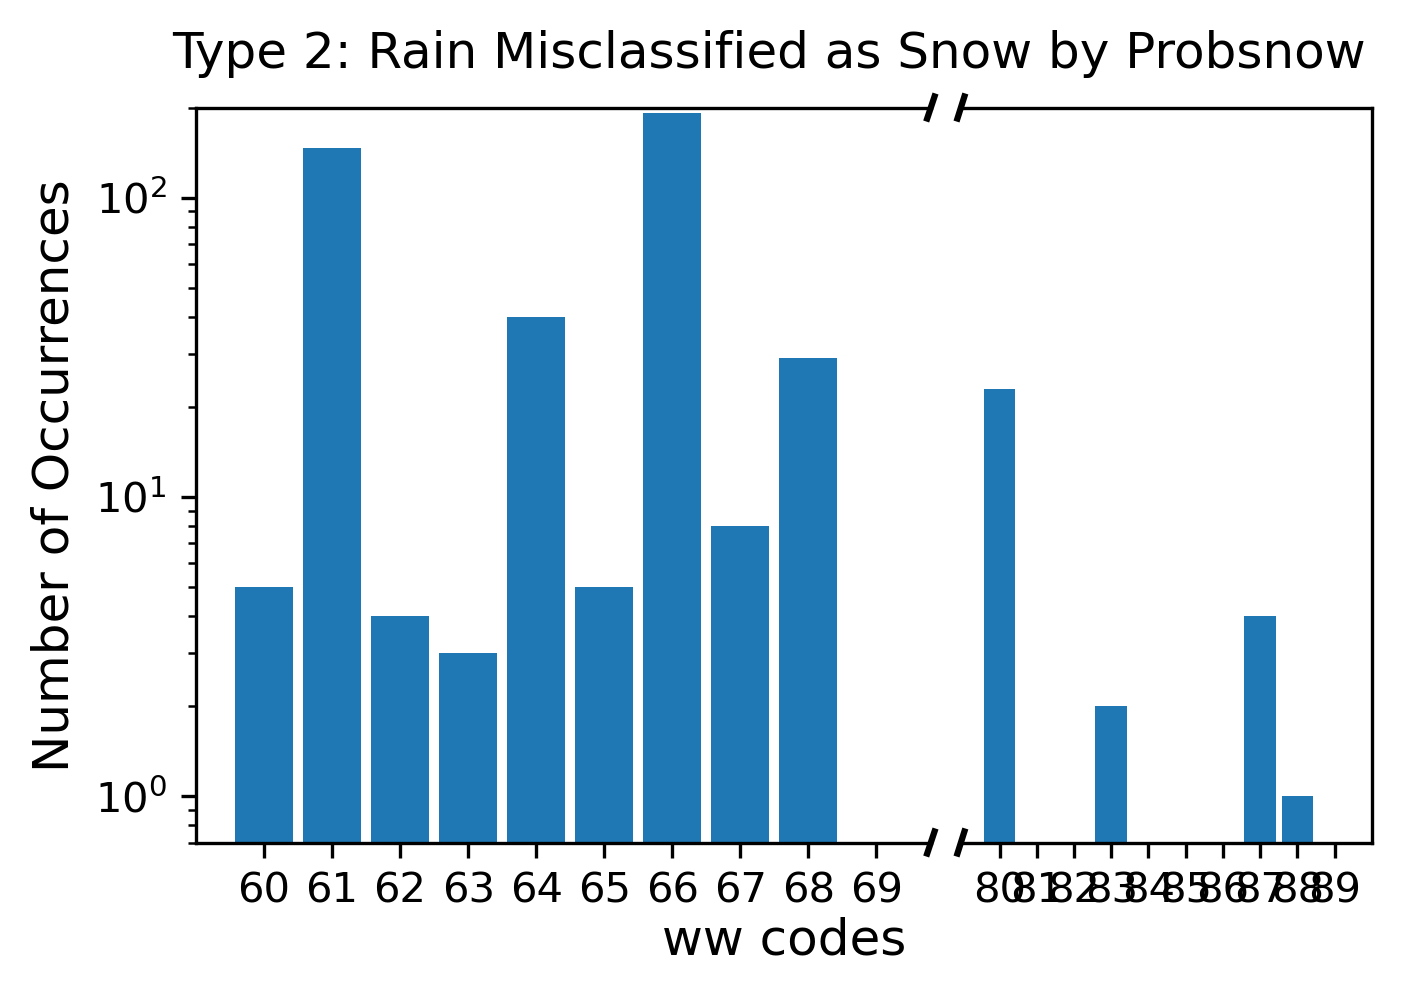

In [249]:

# plt.savefig(figpath+'probsnow', bbox_inches='tight', dpi=300)
# plt.savefig(figpath+'probsnow.eps', format='eps', bbox_inches='tight', dpi=300)


# ---------- Evaluation ----------

# data

Type1: 4.34 * exp(-0.35*x + -0.70)

Type2: -41.15 + 28.71 * ln( 1.82*x - 1.15)

intercept:2.94


In [71]:
lnco = np.array([-41.15, 28.71, 1.82])
pa_intercept = 2.94

In [108]:
lnco

array([-41.15,  28.71,   1.82])

In [109]:
pa_intercept

2.94

In [72]:
def type1_exp(x, m, t, b):
    return m * np.exp(t*x +b) 

def classify_one_layer(test):
    '''
    Seperation for soundings with only one melting at the bottom
    '''
    popt = [4.34, -0.35, -0.7]
    pre_snow = test[test.tw <= type1_exp(test.posi_area1, *popt)]['wwflag']
    pre_rain = test[test.tw > type1_exp(test.posi_area1, *popt)]['wwflag']
    return pre_rain, pre_snow

def type2_ln(x, a, b, c):
    pa_intercept = 2.94
    return a+b*np.log(c*x+ np.exp(-a/b)-pa_intercept*c)

def classify_two_layers(test):
    '''
    Separation for soundings with a melting layer and a refreezing layer
    '''
    params = [-41.15, 28.71, 1.82]
    pa_intercept = 2.94
    
    PA = 'posi_area1'
    NA = 'nega_area1'

    pre_snow0 = test[test[PA] <= pa_intercept]
    
    test1 = test[test[PA] > pa_intercept]
    pre_rain = test1[test1[NA] < type2_ln(test1[PA], *params)]
    pre_snow1 = test1[test1[NA] >= type2_ln(test1[PA], *params)]
    pre_snow = pd.concat([pre_snow0, pre_snow1])
    
    return pre_rain.wwflag, pre_snow.wwflag
    
def metrics(pre_rain, pre_snow):
    TP = sum(pre_snow==2)
    FP = sum(pre_snow==1)
    P = len(pre_snow)
    TN = sum(pre_rain==1)
    FN = sum(pre_rain==2)
    N = len(pre_rain)
    
    accuracy = (TP+TN)/(P+N)
    if TP+FN == 0:
        recall = np.nan
    else:
        recall = TP/(TP+FN)
    
    if TP+FP ==0:
        precision = np.nan
    else:
        precision = np.divide(TP, (TP+FP))
        
    if TP==0:
        f1score = np.nan
    else:
        f1score = 1 /((TP+FN)/TP+(TP+FP)/TP) 
    return accuracy, recall, precision, f1score
    

In [212]:
df = pd.read_csv(datapath + 'final_all_cleaned_data.txt', index_col=0)
df = df.set_index('ID')
df.nega_area1_t *= -1
df.nega_area1_tw *= -1

test = df[  ~df.t.isna() & 
            ~df.td.isna() & 
            ~df.p.isna() & 
            ~df.lapse_rate_tw.isna() &
            ~df.posi_area1_tw.isna() &
            ~df.lapse_rate_t.isna() &
            ~df.posi_area1_t.isna() &
            df.posi_area2_t.isna() & df.nega_area3_t.isna() &
            df.posi_area2_tw.isna() & df.nega_area3_tw.isna()]


In [213]:
IDs = test.index.unique()
test = rename_df_columns(test, 'tw')
scores = pd.DataFrame(index=IDs, columns=['ndata', 'nrain', 'nsnow', 'accuracy', 'recall', 'precision', 'f1score'])
bias_energy = pd.DataFrame(index=IDs, columns=['absolute'])
for ID in IDs:
    test_station = test.loc[[ID]]
    test_one = test_station[test_station.nega_area1.isna()]
    test_two = test_station[~test_station.nega_area1.isna()]
    
    pre_rain_one, pre_snow_one = classify_one_layer(test_one)
    pre_rain_two, pre_snow_two = classify_two_layers(test_two)
    
    pre_rain = pd.concat([pre_rain_one, pre_rain_two])
    pre_snow = pd.concat([pre_snow_one, pre_snow_two])   
    
    scores.loc[ID, 'ndata'] = len(test)
    scores.loc[ID, 'nrain'] = sum(test.wwflag==1)
    scores.loc[ID, 'nsnow'] = sum(test.wwflag==2)
    scores.loc[ID, 'accuracy'], scores.loc[ID, 'recall'], scores.loc[ID, 'precision'], scores.loc[ID, 'f1score'] = metrics(pre_rain, pre_snow)
    
    n_pre_rain = len(pd.concat([pre_rain]))
    n_pre_snow = len(pd.concat([pre_snow]))
    snowp_pre = n_pre_snow/len(test_station)
    snowp_obs = len(test_station[test_station.wwflag==2])/len(test_station)
    bias_energy.loc[ID, 'absolute'] = snowp_pre-snowp_obs 

In [126]:
abs(bias_energy).mean()

absolute    0.015902
dtype: float64

In [127]:
bias_energy.mean()

absolute   -0.001766
dtype: float64

In [78]:
bias_energy.mean()

absolute   -0.010891
dtype: float64

In [77]:
bias.mean()

t              0.037184
tw             0.023290
probsnow_t     0.011819
probsnow_tw   -0.001074
dtype: float64

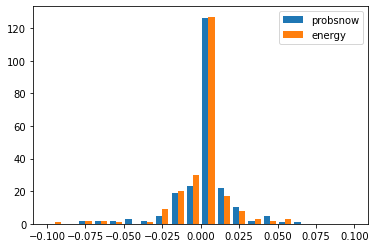

In [129]:
plt.hist([bias.probsnow_tw, bias_energy.absolute], np.arange(-0.1, 0.11, 0.01))
plt.legend(['probsnow', 'energy'])

# Figure 9: Station snow hit percentage

In [151]:
# lat and lon of the stations
bias_loc = stations.loc[bias_energy.index]
bias_loc = bias_loc[~bias_loc.index.duplicated()]


rgb = pd.read_csv('diff_16colors.txt', delim_whitespace=True, header=None).values/255
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       'mymap', rgb[1:-1], len(rgb)-2)
cmap.set_under(rgb[0])
cmap.set_over(rgb[-1])

bounds = [-6, -5,-4, -3, -2, -1, -0.1, 0, 0.1, 1, 2, 3, 4, 5, 6]
norms = colors.BoundaryNorm(boundaries=bounds, ncolors=len(rgb)-2)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_iches" which is no longer supported as of 3.3 and will become an error in 3.6
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


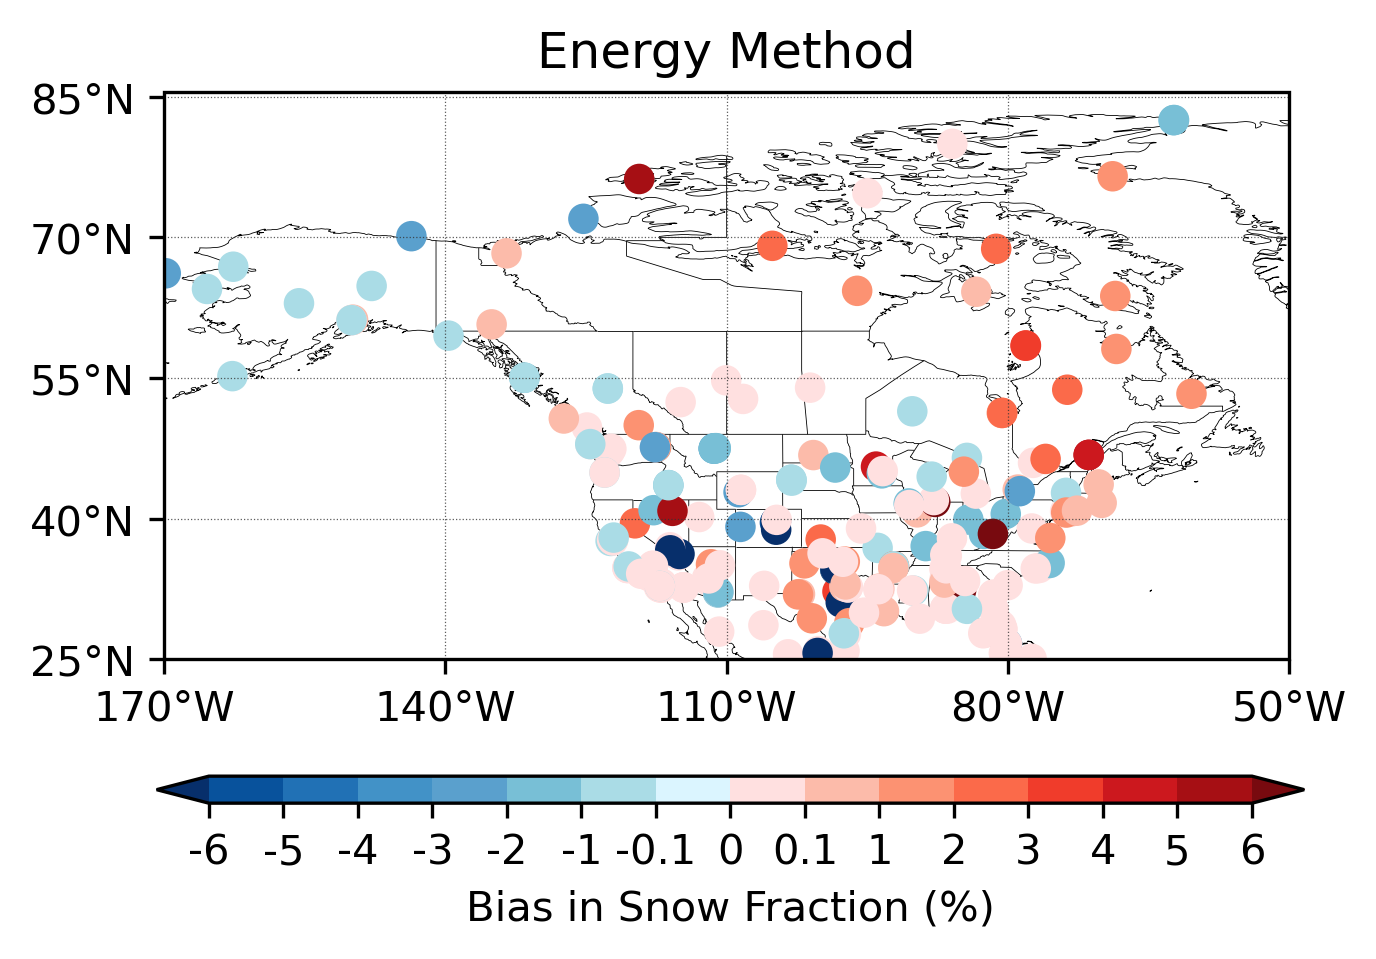

In [153]:
fig = plt.figure(figsize=(5, 3), dpi=300)  
ax1  = fig.add_axes([0.1, 0.18, 0.75, 0.75], projection=proj)
position1 = fig.add_axes([0.095, 0.08, 0.765, 0.03])

dlon=30
dlat=15
plot_basemap(ax1, img_extent, dlon, dlat)
sct1= ax1.scatter(bias_loc['LON'], bias_loc['LAT'],
                  c=bias_energy['absolute']*100,
                  s=40,
                  cmap=cmap,
                  norm=norms)
ax1.set_title('Energy Method', fontsize=12)
cb = plt.colorbar(sct1, cax=position1 ,orientation='horizontal', fraction=.1, extend='both')
cb.ax.tick_params(labelsize=10)
cb.set_ticks(bounds)
cb.set_ticklabels(bounds)
cb.ax.set_xlabel('Bias in Snow Fraction (%)')

plt.savefig(figpath+'Figure9', dpi=300, bbox_inches='tight')
plt.savefig(figpath+'Figure9.eps', format='eps', dpi=300, bbox_iches='tight')

(array([[  0.,   0.,   0.,   1.,  22., 181.,  15.,   8.,   4.,   1.],
        [  0.,   0.,   0.,   1.,  26., 192.,   9.,   1.,   2.,   1.],
        [  0.,   0.,   0.,   3.,  51., 166.,   8.,   1.,   2.,   1.],
        [  0.,   0.,   2.,   2.,  58., 167.,   2.,   0.,   1.,   0.],
        [  1.,   0.,   0.,   2.,  66., 160.,   1.,   1.,   1.,   0.]]),
 array([-50.0, -40.0, -30.0, -20.0, -10.0, 0.0, 10.0, 20.0, 30.0, 40.0,
        50.0], dtype=object),
 <a list of 5 BarContainer objects>)

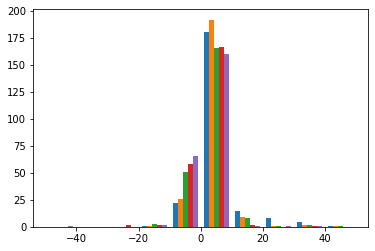

In [168]:

bias['energy'] = bias_energy['absolute']
bias*=100
plt.hist(bias)

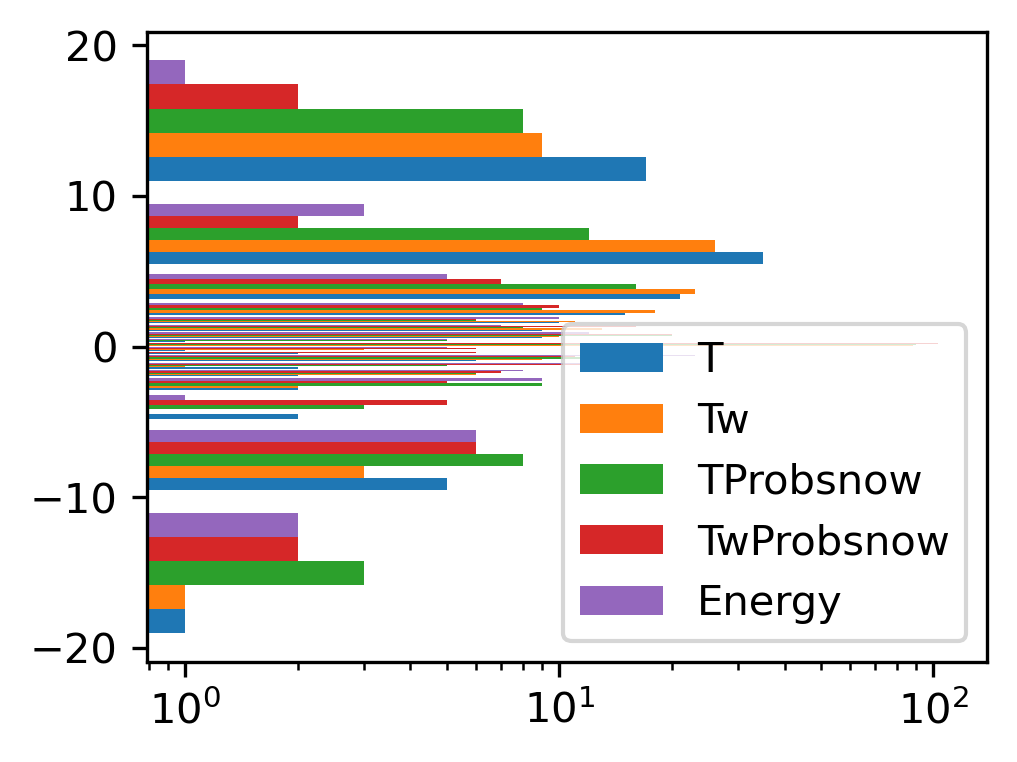

In [178]:
bins = [-20, -10, -5, -3, -2, -1.5, -1, -0.5, -0.3, 0,
       0.3, 0.5, 1, 1.5, 2, 3, 5, 10, 20 ]

fig = plt.figure(figsize=(4,3), dpi=300)  
ax = fig.add_axes([0.15, 0.15, 0.7, 0.7])
ax.hist(bias, bins, log=True, orientation='horizontal')
ax.legend(['T', 'Tw', 'TProbsnow', 'TwProbsnow', 'Energy'])

# Figure 10: Four metrics energy method

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


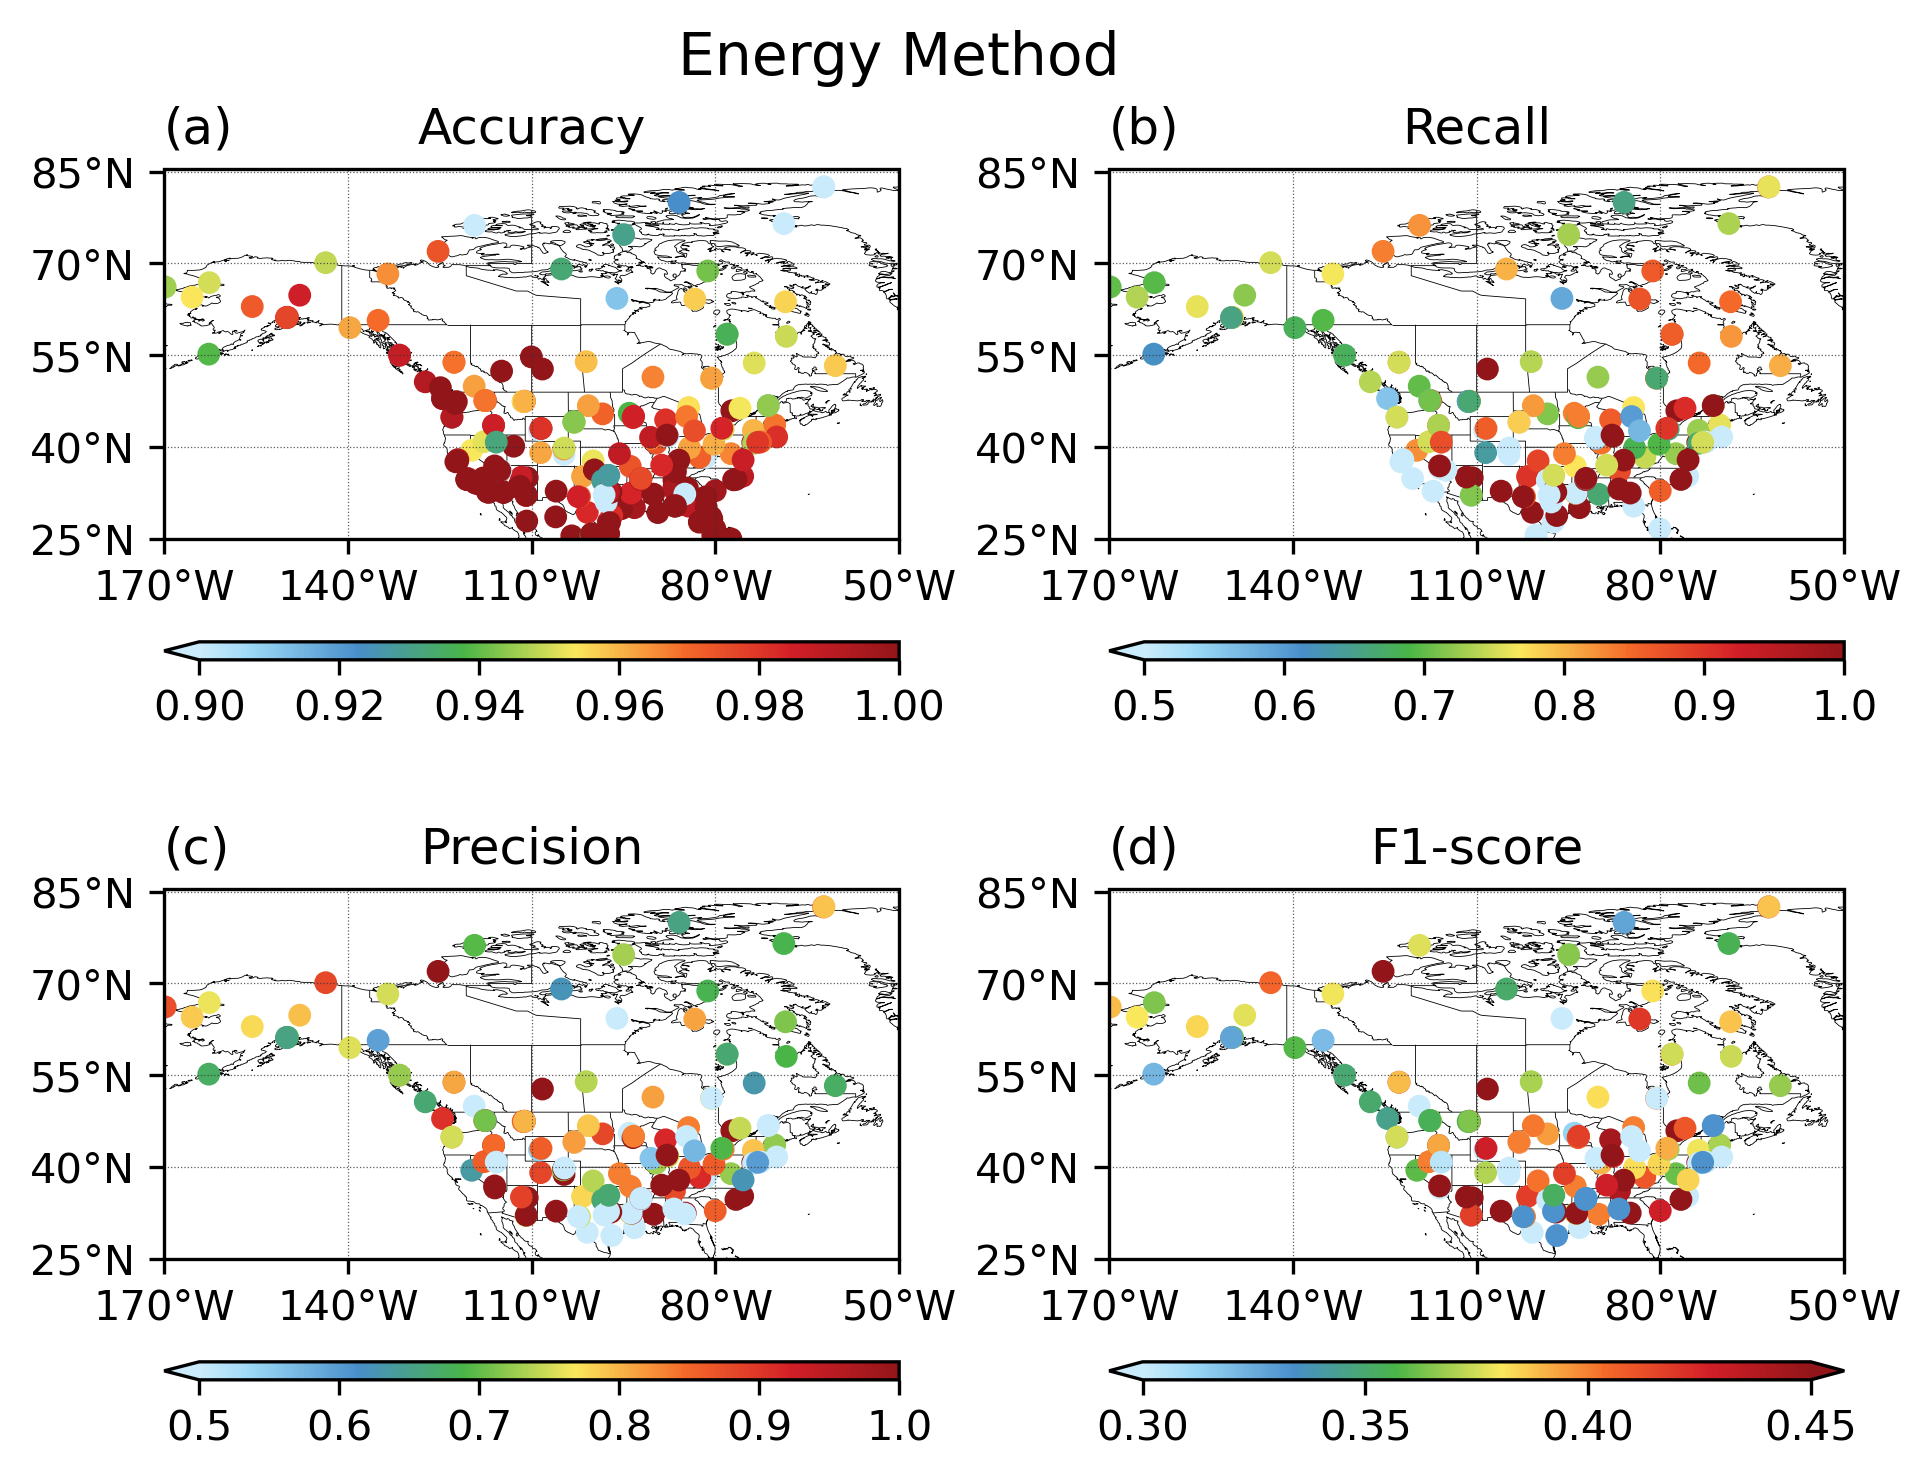

In [301]:
wbgyr = pd.read_csv(r'C:\Files\Research\Colormaps\WhiteBlueGreenYellowRed.txt', delim_whitespace=True, header=None)/255
bgyr = wbgyr[20:]
mycmap = colors.ListedColormap(bgyr.values, name='mycmap')


proj = ccrs.PlateCarree(central_longitude=0)
leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 85.5)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15

fig = plt.figure(figsize=(7, 6), dpi=300)  
ax1  = fig.add_axes([0.15, 0.55, 0.35, 0.3], projection=proj)
ax2  = fig.add_axes([0.60, 0.55, 0.35, 0.3], projection=proj)
ax3  = fig.add_axes([0.15, 0.15, 0.35, 0.3], projection=proj)
ax4  = fig.add_axes([0.60, 0.15, 0.35, 0.3], projection=proj)
plot_basemap(ax1, img_extent, dlon, dlat)
plot_basemap(ax2, img_extent, dlon, dlat)
plot_basemap(ax3, img_extent, dlon, dlat)
plot_basemap(ax4, img_extent, dlon, dlat)

sct1 = ax1.scatter(stations.loc[scores.index, 'LON'], stations.loc[scores.index, 'LAT'], c=scores.accuracy, s=20, cmap=mycmap, vmin = 0.90)
sct2 = ax2.scatter(stations.loc[scores.index, 'LON'], stations.loc[scores.index, 'LAT'], c=scores.recall, s=20, cmap=mycmap, vmin=0.5)
sct3 = ax3.scatter(stations.loc[scores.index, 'LON'], stations.loc[scores.index, 'LAT'], c=scores.precision, s=20, cmap=mycmap, vmin=0.5)
sct4 = ax4.scatter(stations.loc[scores.index, 'LON'], stations.loc[scores.index, 'LAT'], c=scores.f1score, s=20, cmap=mycmap, vmin=0.3, vmax=0.45)

position1 = fig.add_axes([0.15, 0.53, 0.35, 0.01])
position2 = fig.add_axes([0.60, 0.53, 0.35, 0.01])
position3 = fig.add_axes([0.15, 0.13, 0.35, 0.01])
position4 = fig.add_axes([0.60, 0.13, 0.35, 0.01])
plt.colorbar(sct1, cax=position1, orientation='horizontal', extend='min')
plt.colorbar(sct2, cax=position2, orientation='horizontal', extend='min')
plt.colorbar(sct3, cax=position3, orientation='horizontal', extend='min')
plt.colorbar(sct4, cax=position4, orientation='horizontal', extend='both')

ax1.set_title('Accuracy', fontsize=12)
ax2.set_title('Recall', fontsize=12)
ax3.set_title('Precision', fontsize=12)
ax4.set_title('F1-score', fontsize=12)

ax1.set_title('(a)', loc='left', fontsize=12)
ax2.set_title('(b)', loc='left', fontsize=12)
ax3.set_title('(c)', loc='left', fontsize=12)
ax4.set_title('(d)', loc='left', fontsize=12)
plt.suptitle('Energy Method', y=0.88, fontsize=14)

plt.savefig(figpath+'Figure10', bbox_inches='tight', dpi=300)
plt.savefig(figpath+'Figure10.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure 11: Four metrics diff, energy-probsnow

probsnow score

In [262]:
scores_probsnow = pd.read_csv('../02-Output/NA/TwProbsnow_score_map.txt')
scores_probsnow.set_index(scores_probsnow.NCEP_ID, inplace=True)
scores.sort_index(inplace=True)
score = scores - scores_probsnow

# if difference=0, don't plot the dot
diff = {}
strings = ['accuracy', 'recall', 'precision', 'f1score']
for var in strings:
    score.loc[score[var]==0, var]=np.nan
    diff[var] = score.loc[~score[var].isna(), var]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


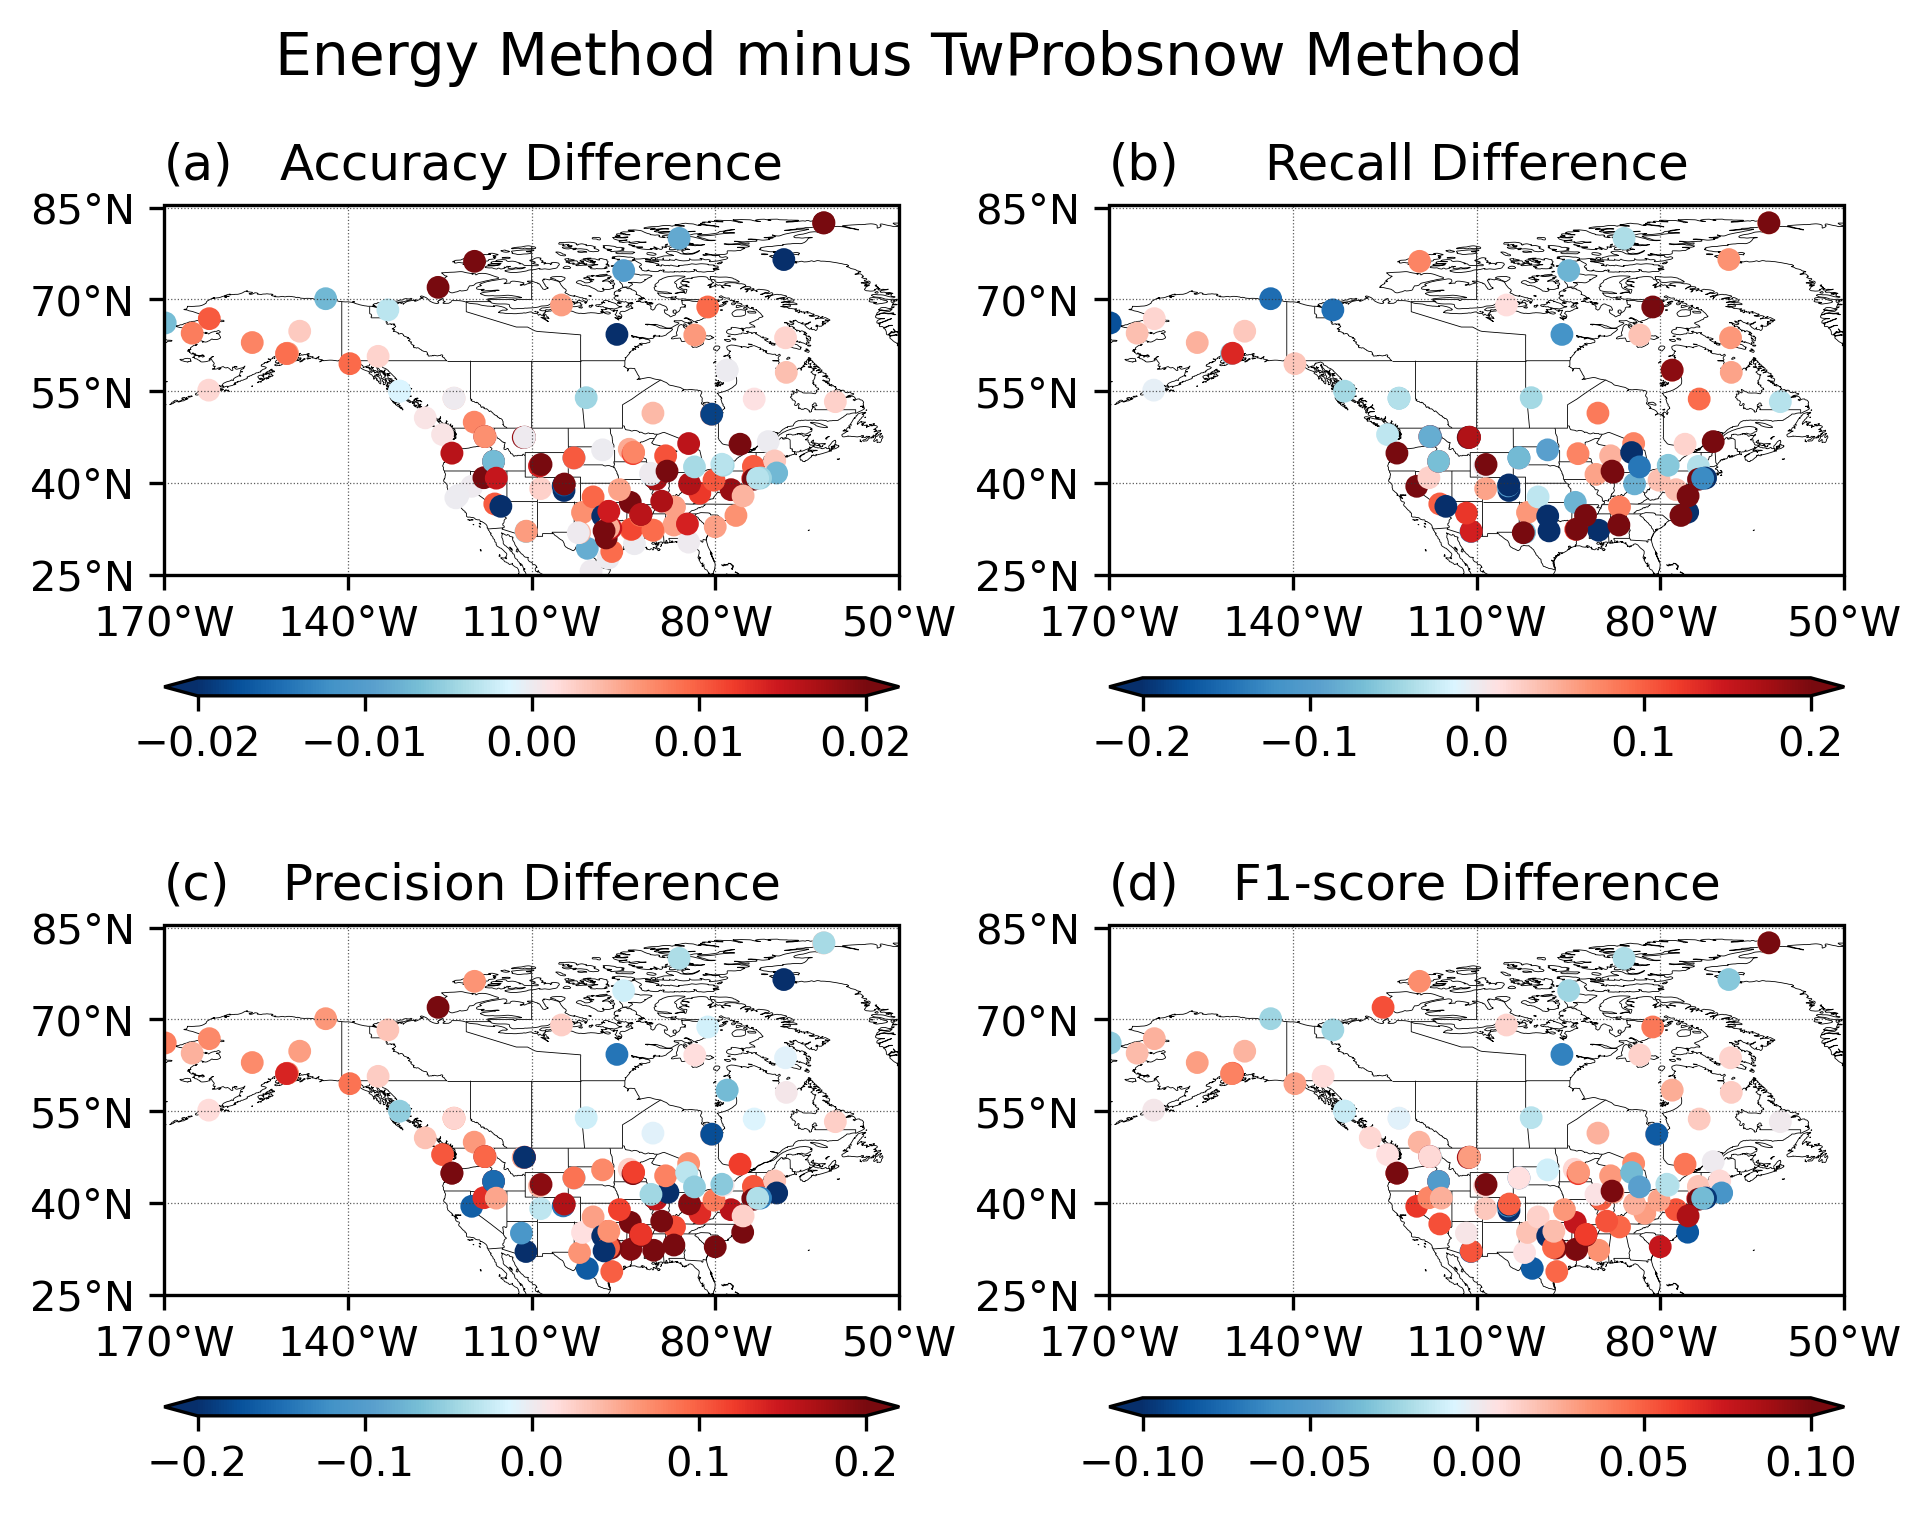

In [312]:
dfcmap = pd.read_csv(r'C:\Files\Research\Colormaps\NCV_BlueRed.txt', delim_whitespace=True, header=None)

dfcmap = pd.read_csv('diff_16colors.txt', header=None, dtype=int, delim_whitespace=True).values/255
dfcmap = pd.read_csv('darkbluedarkred.txt', header=None).values/255
cmap = colors.ListedColormap(dfcmap[1:-1])
cmap.set_under(dfcmap[0, :])
cmap.set_over(dfcmap[-1, :])


proj = ccrs.PlateCarree(central_longitude=0)
leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 85.5)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15


fig = plt.figure(figsize=(7, 6), dpi=300)  
ax1  = fig.add_axes([0.15, 0.55, 0.35, 0.3], projection=proj)
ax2  = fig.add_axes([0.60, 0.55, 0.35, 0.3], projection=proj)
ax3  = fig.add_axes([0.15, 0.15, 0.35, 0.3], projection=proj)
ax4  = fig.add_axes([0.60, 0.15, 0.35, 0.3], projection=proj)
plot_basemap(ax1, img_extent, dlon, dlat)
plot_basemap(ax2, img_extent, dlon, dlat)
plot_basemap(ax3, img_extent, dlon, dlat)
plot_basemap(ax4, img_extent, dlon, dlat)


bounds1 = [-0.01 , -0.008, -0.006, -0.004, -0.002, -0.001, 0., 0.001   ,  0.002,  0.004, 0.006,  0.008,  0.01 ]
boundlabels=bounds1
norms = colors.BoundaryNorm(boundaries=bounds1, ncolors=len(dfcmap)-2)

sct1 = ax1.scatter(stations.loc[diff['accuracy'].index, 'LON'],  stations.loc[diff['accuracy'].index, 'LAT'],  c=diff['accuracy'],  cmap=cmap, s=20, vmin=-0.02, vmax=0.02)
sct2 = ax2.scatter(stations.loc[diff['recall'].index, 'LON'],    stations.loc[diff['recall'].index, 'LAT'],    c=diff['recall'],    cmap=cmap, s=20, vmin=-0.2, vmax=0.2)
sct3 = ax3.scatter(stations.loc[diff['precision'].index, 'LON'], stations.loc[diff['precision'].index, 'LAT'], c=diff['precision'], cmap=cmap, s=20, vmin=-0.2, vmax=0.2)
sct4 = ax4.scatter(stations.loc[diff['f1score'].index, 'LON'],   stations.loc[diff['f1score'].index, 'LAT'],   c=diff['f1score'],   cmap=cmap, s=20, vmin=-0.1, vmax=0.1)

position1 = fig.add_axes([0.15, 0.53, 0.35, 0.01])
position2 = fig.add_axes([0.60, 0.53, 0.35, 0.01])
position3 = fig.add_axes([0.15, 0.13, 0.35, 0.01])
position4 = fig.add_axes([0.60, 0.13, 0.35, 0.01])
plt.colorbar(sct1, cax=position1, orientation='horizontal', extend='both')
plt.colorbar(sct2, cax=position2, orientation='horizontal', extend='both')
plt.colorbar(sct3, cax=position3, orientation='horizontal', extend='both')
plt.colorbar(sct4, cax=position4, orientation='horizontal', extend='both')

ax1.set_title('Accuracy Difference', fontsize=12)
ax2.set_title('Recall Difference', fontsize=12)
ax3.set_title('Precision Difference', fontsize=12)
ax4.set_title('F1-score Difference', fontsize=12)

ax1.set_title('(a)', loc='left', fontsize=12)
ax2.set_title('(b)', loc='left', fontsize=12)
ax3.set_title('(c)', loc='left', fontsize=12)
ax4.set_title('(d)', loc='left', fontsize=12)
plt.suptitle('Energy Method minus TwProbsnow Method', y=0.9, fontsize=14)


plt.savefig(figpath+'Figure11', bbox_inches='tight', dpi=300)
plt.savefig(figpath+'Figure11.eps', format='eps', bbox_inches='tight', dpi=300)

# Figure: Satellite

## snowfall rate and difference

In [286]:
file1 = '../02-Output/NA/1by1_5day_annual_sf_probsnow.txt'
file2 = '../02-Output/NA/1by1_5day_annual_sf_energy.txt'
df_prob = pd.read_csv(file1, index_col=0)
df_energy = pd.read_csv(file2, index_col=0)

df_prob /= 5
df_energy /=5

(array([[6., 0., 2., 1., 1., 0., 3., 0., 0.],
        [6., 0., 1., 3., 1., 1., 1., 0., 0.],
        [6., 1., 0., 2., 2., 2., 0., 0., 0.],
        [6., 1., 0., 2., 3., 0., 0., 0., 0.],
        [6., 2., 0., 3., 0., 1., 0., 0., 0.],
        [6., 1., 2., 2., 1., 0., 0., 0., 0.],
        [7., 0., 1., 1., 2., 2., 0., 0., 0.],
        [7., 0., 0., 2., 3., 0., 0., 0., 0.],
        [6., 0., 2., 0., 1., 2., 0., 1., 0.],
        [4., 0., 3., 3., 0., 2., 0., 0., 0.],
        [3., 1., 4., 2., 2., 0., 0., 0., 1.],
        [3., 3., 3., 2., 0., 2., 0., 0., 0.],
        [3., 1., 6., 1., 2., 0., 0., 0., 0.],
        [5., 3., 3., 2., 0., 0., 0., 0., 0.],
        [4., 4., 1., 3., 1., 0., 0., 0., 0.],
        [4., 2., 2., 4., 1., 0., 0., 0., 0.],
        [4., 3., 2., 2., 2., 0., 0., 0., 0.],
        [4., 0., 3., 3., 2., 1., 0., 0., 0.],
        [4., 0., 4., 2., 0., 1., 1., 1., 0.],
        [4., 1., 1., 3., 2., 1., 0., 1., 0.],
        [5., 0., 1., 3., 1., 3., 0., 0., 0.],
        [4., 1., 1., 1., 3., 1., 1

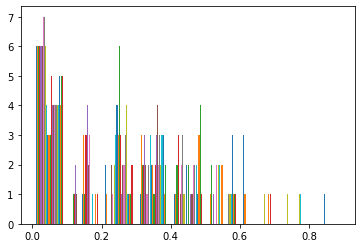

In [263]:
plt.hist(df_prob5/5, np.arange(0, 1, 0.1))

In [287]:
# sum into 5 by 5
df_prob5 = pd.DataFrame(data=0, index=np.arange(25, 90, 5), columns = np.arange(-170, -50, 5))
df_energy5 = pd.DataFrame(data=0, index=np.arange(25, 90, 5), columns = np.arange(-170, -50, 5))
for idx in range(0, 65, 5):
    for icol in range(0, 120, 5):
        df_prob5.iloc[int(idx/5), int(icol/5)] = df_prob.iloc[idx:idx+4, icol:icol+4].sum().sum()
        df_energy5.iloc[int(idx/5), int(icol/5)] = df_energy.iloc[idx:idx+4, icol:icol+4].sum().sum()

df_prob2 = pd.DataFrame(data=0, index=np.arange(25, 90, 2), columns = np.arange(-170, -50, 2))
df_energy2 = pd.DataFrame(data=0, index=np.arange(25, 90, 2), columns = np.arange(-170, -50, 2))
for idx in range(0, 65, 2):
    for icol in range(0, 120, 2):
        df_prob2.iloc[int(idx/2), int(icol/2)] = df_prob.iloc[idx:idx+1, icol:icol+1].sum().sum()
        df_energy2.iloc[int(idx/2), int(icol/2)] = df_energy.iloc[idx:idx+1, icol:icol+1].sum().sum()

In [ ]:
## create a pacific and atlantic ocean mask

In [301]:
ocean = pd.DataFrame(data=False, index=np.arange(25, 90, 5), columns = np.arange(-170, -50, 5))

ocean.loc[55, [-155, -150, -145, -55]] = True
ocean.loc[50, np.arange(-170, -130, 5)] = True
ocean.loc[45, np.arange(-170, -125, 5)] = True
ocean.loc[40, np.arange(-170, -125, 5)] = True
ocean.loc[35, np.arange(-170, -125, 5)] = True
ocean.loc[30, np.arange(-170, -120, 5)] = True
ocean.loc[25, np.arange(-170, -115, 5)] = True


ocean.loc[40, np.arange(-60, -50, 5)] = True
ocean.loc[35, np.arange(-75, -50, 5)] = True
ocean.loc[30, np.arange(-75, -50, 5)] = True
ocean.loc[25, np.arange(-80, -50, 5)] = True
ocean.loc[25, np.arange(-95, -80, 5)] = True

In [358]:


diff = (df_energy5-df_prob5)
per = ((df_energy5-df_prob5)/df_prob5)

df_energy5 = df_energy5.mask(ocean)
df_prob5 = df_prob5.mask(ocean)
diff = diff.mask(ocean).values
per = per.mask(ocean).values

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


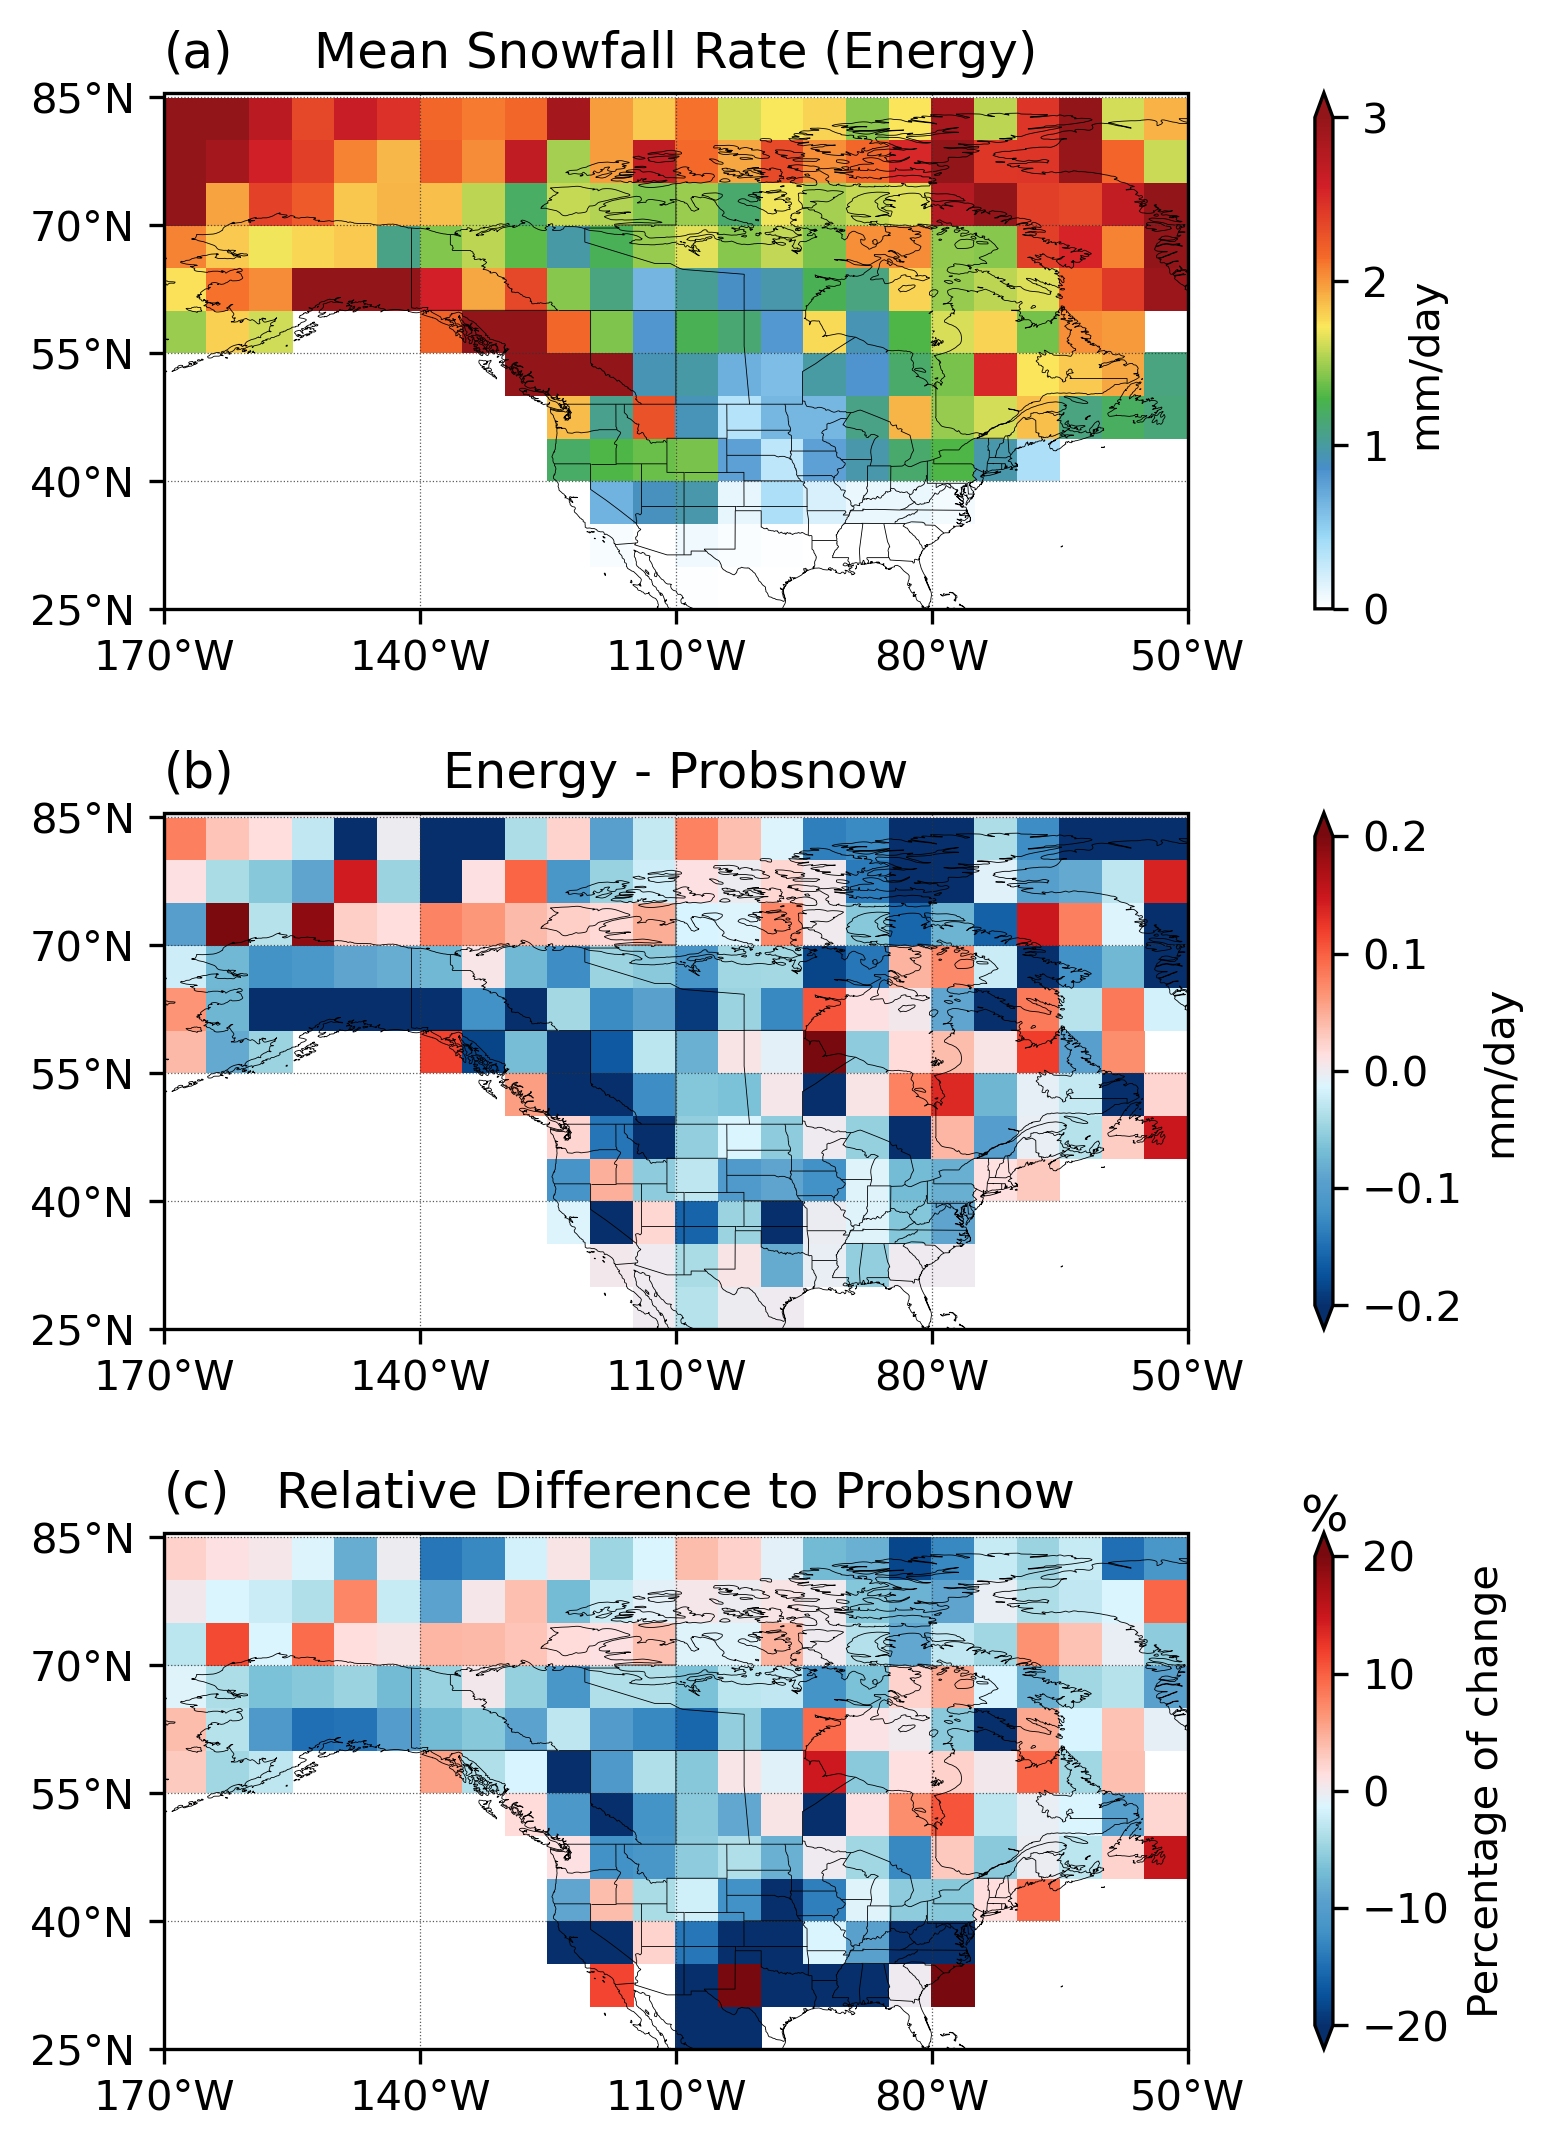

In [362]:
wbgyr = pd.read_csv('C:\Files\Research\Colormaps\WhiteBlueGreenYellowRed.txt',
                    header=None, delim_whitespace=True)
wbgyr /= 255
wbgyr = wbgyr.values
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       'mymap', wbgyr, len(wbgyr))

dfcmap = pd.read_csv('darkbluedarkred.txt', header=None).values/255
br = colors.ListedColormap(dfcmap[1:-1])
br.set_under(dfcmap[0, :])
br.set_over(dfcmap[-1, :])


leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 85.5)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15

fig = plt.figure(figsize=(6, 8), dpi=300)  
ax1  = fig.add_axes([0.12, 0.65, 0.65, 0.215], projection=proj)
ax2  = fig.add_axes([0.12, 0.35, 0.65, 0.215], projection=proj)
ax3  = fig.add_axes([0.12, 0.05, 0.65, 0.215], projection=proj)

position1 = fig.add_axes([0.8, 0.65, 0.01, 0.215])
position2 = fig.add_axes([0.8, 0.35, 0.01, 0.215])
position3 = fig.add_axes([0.8, 0.05, 0.01, 0.215])

lon = np.arange(-167.5, -50, 5)
lat = np.arange(27.5, 90, 5)
p1 = ax1.pcolor(lon, lat, df_energy5.values, cmap=cmap, vmin=0, vmax=3)
plot_basemap(ax1, img_extent, dlon, dlat)

p2 = ax2.pcolor(lon, lat, diff, cmap=br, vmin=-0.2, vmax=0.2)
plot_basemap(ax2, img_extent, dlon, dlat)
             
p3 = ax3.pcolor(lon, lat, per*100, cmap=br, vmin=-20, vmax=20)
plot_basemap(ax3, img_extent, dlon, dlat)

cb1 = plt.colorbar(p1, cax=position1, orientation='vertical', extend='max')
cb2 = plt.colorbar(p2, cax=position2, orientation='vertical', extend='both')
cb3 = plt.colorbar(p3, cax=position3, orientation='vertical', extend='both')
cb1.ax.set_ylabel('mm/day')
cb2.ax.set_ylabel('mm/day')
cb3.ax.set_ylabel('Percentage of change')
cb3.ax.set_title('%')

ax1.set_title('Mean Snowfall Rate (Energy)')
ax2.set_title('Energy - Probsnow')
ax3.set_title('Relative Difference to Probsnow')

ax1.set_title('(a)', loc='left')
ax2.set_title('(b)', loc='left')
ax3.set_title('(c)', loc='left')

fig.savefig(figpath+'Figure12', dpi=300, bbox_inches='tight')
fig.savefig(figpath+'Figure12.eps', format='eps', bbox_inches='tight')

## percentage change

(array([[0., 0., 0., 0., 0., 0., 6., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 5., 1., 0., 0.],
        [0., 0., 0., 0., 0., 2., 4., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 3., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 3., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 3., 0., 0., 0.],
        [0., 0., 0., 0., 0., 3., 3., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 4., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 6., 0., 0., 0.],
        [1., 0., 0., 0., 1., 4., 4., 0., 0., 0.],
        [0., 0., 0., 0., 2., 3., 5., 1., 0., 0.],
        [0., 0., 0., 0., 0., 3., 7., 0., 0., 0.],
        [0., 1., 0., 0., 1., 6., 4., 0., 0., 0.],
        [1., 0., 0., 0., 1., 2., 7., 0., 0., 1.],
        [1., 0., 0., 0., 2., 2., 6., 0., 0., 0.],
        [1., 0., 0., 0., 1., 3., 5., 1., 0., 0.],
        [1., 0., 0., 0., 0., 5., 5., 0., 0., 0.],
        [0., 0., 0., 1., 0., 5., 5., 0., 0., 0.],
        [0., 0., 1., 0., 0., 4., 4., 1., 0., 1.],
        [0., 0., 0., 0., 1., 1., 7., 0., 0., 0.],


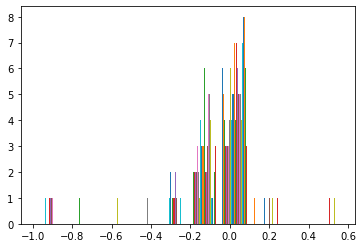

In [335]:
plt.hist(per)

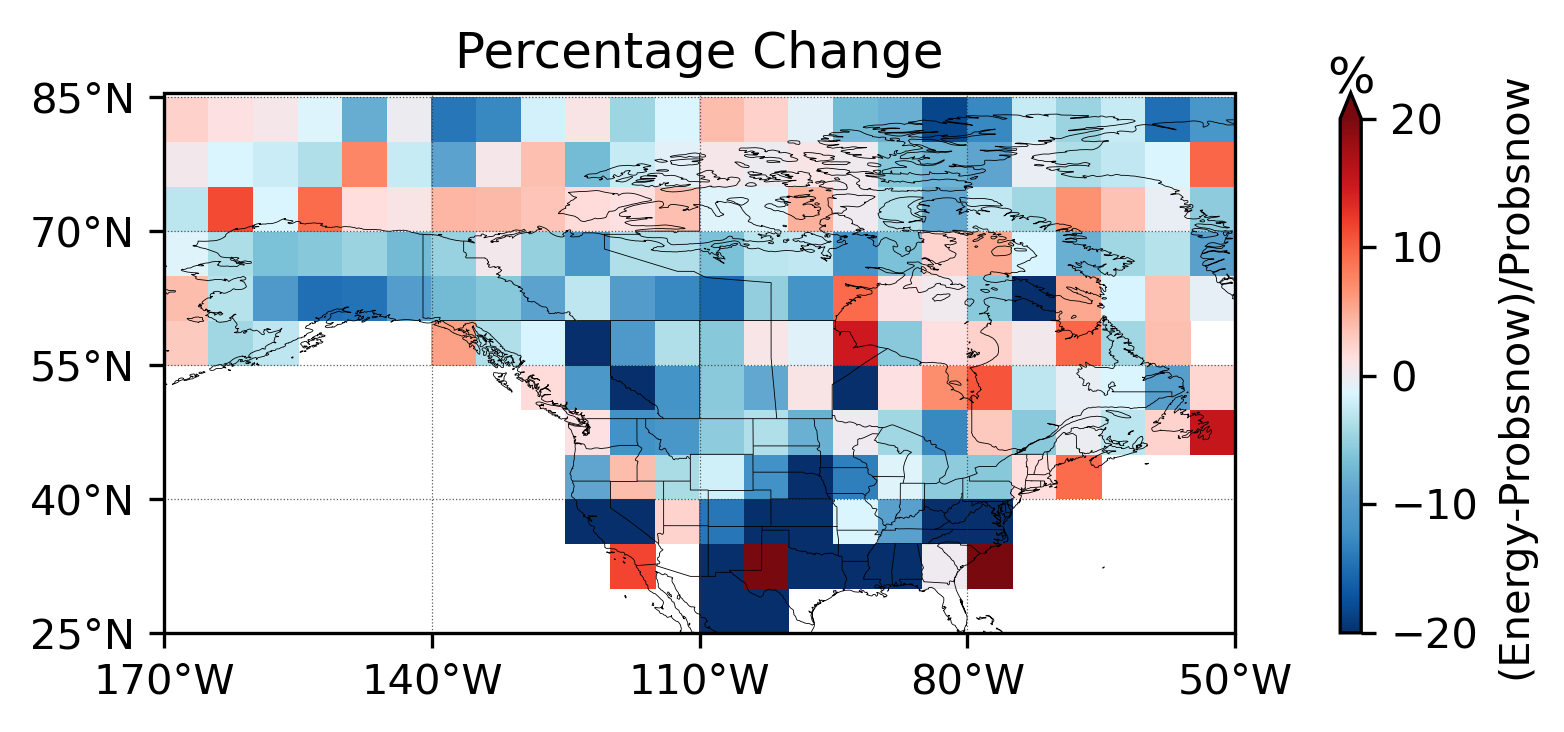

In [342]:

wbgyr = pd.read_csv('C:\Files\Research\Colormaps\WhiteBlueGreenYellowRed.txt',
                    header=None, delim_whitespace=True)
wbgyr /= 255
wbgyr = wbgyr.values
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       'mymap', wbgyr, len(wbgyr))

dfcmap = pd.read_csv('darkbluedarkred.txt', header=None).values/255
br = colors.ListedColormap(dfcmap[1:-1])
br.set_under(dfcmap[0, :])
br.set_over(dfcmap[-1, :])


leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 85.5)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15



per = ((df_energy5-df_prob5)/df_prob5).values

fig = plt.figure(figsize=(7, 6), dpi=300)  
ax1  = fig.add_axes([0.15, 0.55, 0.65, 0.3], projection=proj)
position1 = fig.add_axes([0.78, 0.55, 0.01, 0.3])

lon = np.arange(-167.5, -50, 5)
lat = np.arange(27.5, 90, 5)
p1 = ax1.pcolor(lon, lat, per*100, cmap=br, vmin=-20, vmax=20)
plot_basemap(ax1, img_extent, dlon, dlat)

             
cb1 = plt.colorbar(p1, cax=position1, orientation='vertical', extend='max')

cb1.ax.set_ylabel('(Energy-Probsnow)/Probsnow')
cb1.ax.set_title('%')

ax1.set_title('Percentage Change')


fig.savefig(figpath+'percentage_change', dpi=300, bbox_inches='tight')
# fig.savefig(figpath+'Figure12.eps', format='eps', bbox_inches='tight')

## number of different type observations

In [290]:

def regrid_5by5(n0):
    # sum into 5 by 5
    df5 = pd.DataFrame(data=0, index=np.arange(25, 90, 5), columns = np.arange(-170, -50, 5))
    for idx in range(0, 65, 5):
        for icol in range(0, 120, 5):
            df5.iloc[int(idx/5), int(icol/5)] = n0.iloc[idx:idx+4, icol:icol+4].sum().sum()
    return df5

In [289]:
n0 = pd.read_csv(datapath+'n_type0.txt', index_col=0)
n1 = pd.read_csv(datapath+'n_type1.txt', index_col=0)
n2 = pd.read_csv(datapath+'n_type2.txt', index_col=0)
n0 = regrid_5by5(n0)
n1 = regrid_5by5(n1)
n2 = regrid_5by5(n2)

frac1 = n1/(n1+n2)
frac2 = n2/(n1+n2)

(array([[4., 0., 1., 3., 1., 0., 0., 0., 0., 0.],
        [5., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
        [4., 1., 1., 1., 1., 0., 1., 0., 0., 0.],
        [6., 1., 0., 0., 1., 0., 0., 0., 1., 0.],
        [7., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
        [6., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
        [6., 0., 0., 0., 1., 0., 0., 0., 0., 2.],
        [6., 0., 0., 0., 0., 1., 0., 0., 2., 0.],
        [5., 2., 0., 0., 0., 0., 1., 0., 0., 1.],
        [4., 3., 0., 0., 0., 0., 0., 1., 1., 0.],
        [8., 1., 0., 1., 0., 0., 1., 0., 0., 0.],
        [8., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [9., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
        [6., 2., 3., 0., 0., 0., 1., 0., 0., 0.],
        [7., 0., 1., 1., 0., 0., 1., 1., 1., 0.],
        [6., 2., 3., 0., 0., 0., 0., 0., 0., 0.],
        [5., 4., 2., 0., 0., 0., 0., 0., 0., 0.],
        [6., 2., 3., 0., 0., 0., 0., 0., 0., 0.],
        [6., 2., 1., 1., 1., 0., 0., 0., 0., 0.],
        [7., 3., 0., 0., 0., 0., 0., 0., 0., 0.],


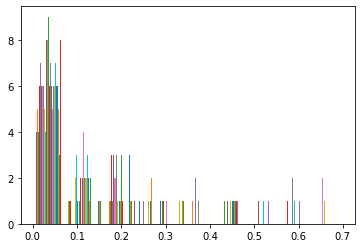

In [192]:
plt.hist(frac2)

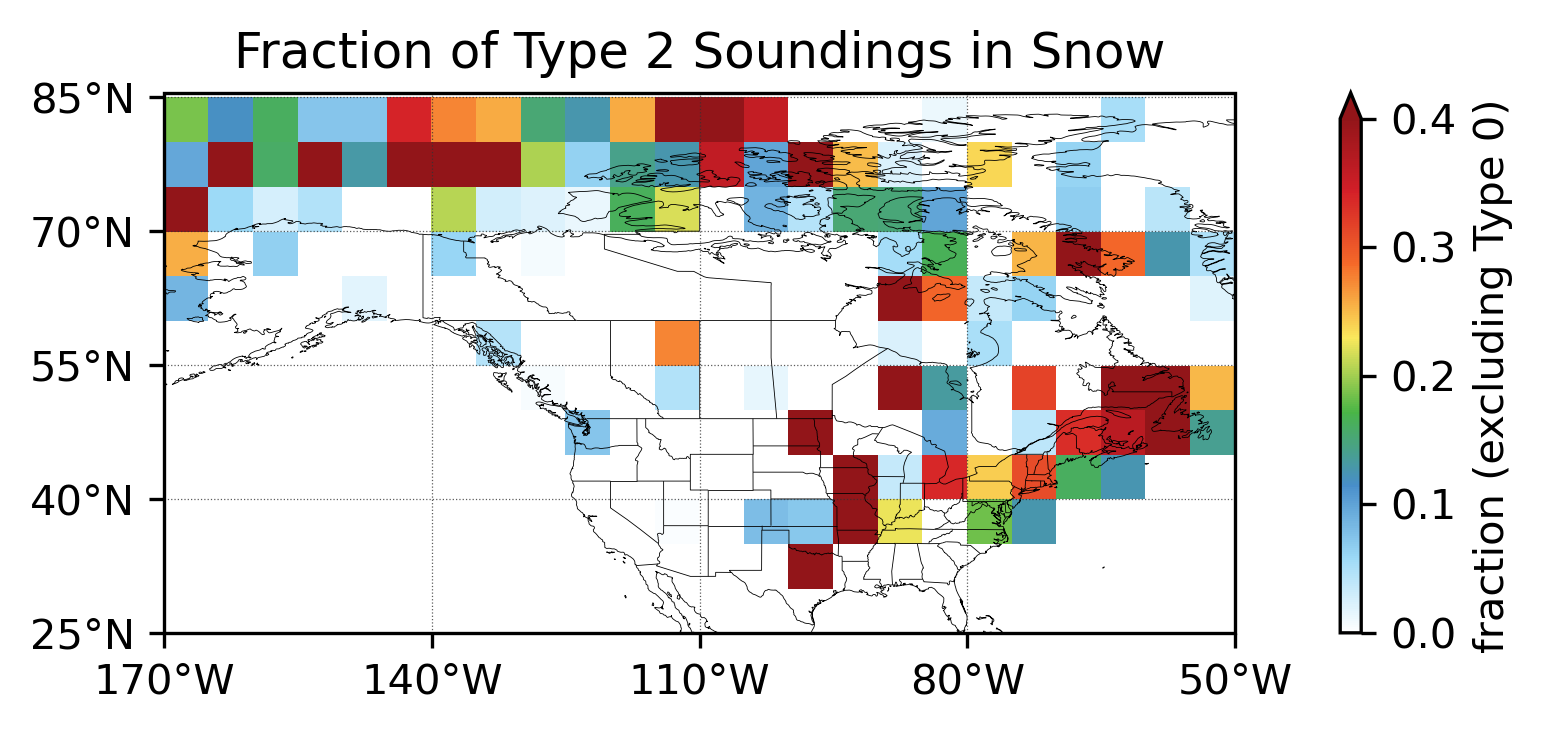

In [293]:
wbgyr = pd.read_csv('C:\Files\Research\Colormaps\WhiteBlueGreenYellowRed.txt',
                    header=None, delim_whitespace=True)
wbgyr /= 255
wbgyr = wbgyr.values
cmap = mpl.colors.LinearSegmentedColormap.from_list(
       'mymap', wbgyr, len(wbgyr))

dfcmap = pd.read_csv('darkbluedarkred.txt', header=None).values/255
br = colors.ListedColormap(dfcmap[1:-1])
br.set_under(dfcmap[0, :])
br.set_over(dfcmap[-1, :])


leftlon, rightlon, lowerlat, upperlat = (-170, -50, 25, 85.5)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
dlon, dlat = 30, 15

fig = plt.figure(figsize=(7, 6), dpi=300)  
ax1  = fig.add_axes([0.15, 0.55, 0.65, 0.3], projection=proj)
position1 = fig.add_axes([0.78, 0.55, 0.01, 0.3])

lon = np.arange(-167.5, -50, 5)
lat = np.arange(27.5, 90, 5)
p1 = ax1.pcolor(lon, lat, frac2.values, cmap=cmap, vmin=0, vmax=0.4)
plot_basemap(ax1, img_extent, dlon, dlat)

             
cb1 = plt.colorbar(p1, cax=position1, orientation='vertical', extend='max')

cb1.ax.set_ylabel('fraction (excluding Type 0)')

ax1.set_title('Fraction of Type 2 Soundings in Snow')


fig.savefig(figpath+'era5_frac_type2', dpi=300, bbox_inches='tight')
# fig.savefig(figpath+'Figure12.eps', format='eps', bbox_inches='tight')

## correlation between diff and frac_type2

In [344]:
frac1d = np.reshape(frac2.values, (1, 13*24))[0]
diff1d = np.reshape((df_energy5-df_prob5).values, (1, 13*24))[0]

frac1d = (frac1d-np.nanmean(frac1d))/np.nanstd(frac1d)
diff1d = (diff1d-np.nanmean(diff1d))/np.nanstd(diff1d)

loc = np.where(~np.isnan(frac1d) & ~np.isnan(diff1d))
x = frac1d[loc]
y = diff1d[loc]

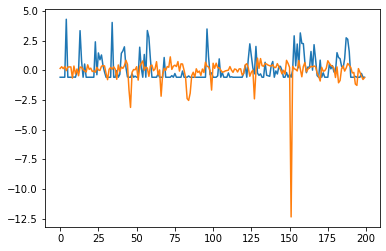

In [345]:
plt.plot(x)
plt.plot(y)
plt.savefig('1d_fracType2_diff')

In [346]:
np.corrcoef(x, y)

array([[1.       , 0.0938981],
       [0.0938981, 1.       ]])

In [338]:
frac1d = np.reshape(frac2.values, (1, 13*24))[0]
diff1d = np.reshape(per, (1, 13*24))[0]

frac1d = (frac1d-np.nanmean(frac1d))/np.nanstd(frac1d)
diff1d = (diff1d-np.nanmean(diff1d))/np.nanstd(diff1d)

loc = np.where(~np.isnan(frac1d) & ~np.isnan(diff1d))
x = frac1d[loc]
y = diff1d[loc]

array([[ 1.        , -0.05072146],
       [-0.05072146,  1.        ]])

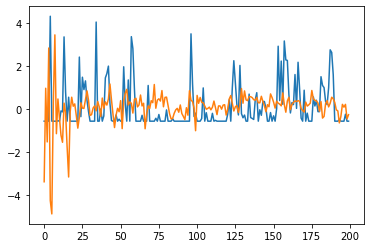

In [339]:
plt.plot(x)
plt.plot(y)
np.corrcoef(x, y)